In [1]:
# --- Parámetros (se pueden sobreescribir en CI) ---
from pathlib import Path
from datetime import datetime
import os
import pandas as pd
import pytz

# Zona horaria para "hoy"
TZ = pytz.timezone("Europe/Madrid")

def _today_tz(tz=TZ) -> str:
    return datetime.now(tz).date().strftime("%Y-%m-%d")

# RUN_DATE: prioridad -> valor ya definido (papermill/globals) -> env -> hoy (Europe/Madrid)
_run_injected = globals().get("RUN_DATE", None)
if _run_injected not in (None, "", "auto", "today"):
    RUN_DATE = str(_run_injected)
else:
    RUN_DATE = os.environ.get("RUN_DATE", _today_tz())

# Normaliza a YYYY-MM-DD
RUN_DATE = pd.to_datetime(RUN_DATE, errors="coerce").date().strftime("%Y-%m-%d")

# SEASON: si no viene dada, se calcula a partir de RUN_DATE (formato 2025_26)
if "SEASON" in globals() and globals()["SEASON"]:
    SEASON = globals()["SEASON"]
else:
    _dt = pd.to_datetime(RUN_DATE)
    _y = int(_dt.year) if _dt.month >= 7 else int(_dt.year) - 1
    SEASON = f"{_y}_{(_y+1) % 100:02d}"

# MATCHDAY (jornada): permite inyección externa; por defecto None
MATCHDAY = globals().get("MATCHDAY", os.environ.get("MATCHDAY", None))

# Versión de modelo: respeta inyección / env, si no usa por defecto
MODEL_VERSION = globals().get("MODEL_VERSION", os.environ.get("MODEL_VERSION", "xgb-local"))

# --- Rutas coherentes local/CI ---
ROOT   = Path.cwd()
DATA   = ROOT / "data"
RAW    = DATA / "01_raw"
PROC   = DATA / "02_processed"
FEAT   = DATA / "03_features"
MODELS = DATA / "04_models"
OUT    = ROOT / "outputs"

for p in [RAW, PROC, FEAT, MODELS, OUT]:
    p.mkdir(parents=True, exist_ok=True)

# Reproducibilidad
import random, numpy as np
random.seed(42); np.random.seed(42)

print(f"RUN_DATE = {RUN_DATE} | SEASON = {SEASON} | MATCHDAY = {MATCHDAY} | MODEL_VERSION = {MODEL_VERSION}")
print(f"ROOT = {ROOT}")

RUN_DATE = 2025-09-27 | SEASON = 2025_26 | MATCHDAY = None | MODEL_VERSION = xgb-local
ROOT = /content


In [2]:
import pandas as pd, json

def load_feat(name: str):
    return pd.read_parquet(FEAT / name)

def save_model(obj, name: str):
    from joblib import dump
    MODELS.mkdir(parents=True, exist_ok=True)
    dump(obj, MODELS / name)

def save_predictions(df: pd.DataFrame, name: str = "predictions_next.csv"):
    OUT.mkdir(parents=True, exist_ok=True)
    df.to_csv(OUT / name, index=False)

def save_json(obj, name: str = "metrics_overview.json"):
    OUT.mkdir(parents=True, exist_ok=True)
    with open(OUT / name, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

# **MODELOS**

In [3]:
import json
from collections import defaultdict
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, log_loss
from imblearn.over_sampling import SMOTE
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

# **PREDICCIÓN: Logistic Regression multinomial**

In [4]:
IN_PATH = FEAT / "df_final.parquet"
df = pd.read_parquet(IN_PATH)

print("Leído:", IN_PATH, "· filas=", len(df), "· cols=", df.shape[1])
df.head(2)

Leído: /content/data/03_features/df_final.parquet · filas= 7290 · cols= 76


,B365A,B365D,B365H,Date,FTR,HomeTeam_norm,AwayTeam_norm,h_elo,a_elo,Season,...,a_squad_size_prev_season,a_pct_foreigners_prev_season,has_xg_data,target,home_playstyle_defensivo,home_playstyle_equilibrado,home_playstyle_ofensivo,away_playstyle_defensivo,away_playstyle_equilibrado,away_playstyle_ofensivo
0,6.00,3.6,1.57,2006-08-26,H,valencia,betis,1857.375122,1726.076904,2006,...,33.0,24.24,0,2.0,False,False,True,True,False,False
1,3.75,3.2,2.00,2006-08-27,D,ath bilbao,sociedad,1755.359253,1701.137573,2006,...,31.0,22.58,0,1.0,False,True,False,False,True,False


Sin SMOTE:

In [5]:
# =========================
# PREDICCIÓN (BASELINE, sin SMOTE) + B365 + export (sin df_old)
# =========================

# --- Detectar automáticamente la próxima jornada COMPLETA (10) ---
def _season_from_run_date(run_date_str: str) -> int:
    d = pd.to_datetime(run_date_str)
    return int(d.year) if d.month >= 7 else int(d.year) - 1

# df_final ya cargado como df
_df_dates = df.copy()
_df_dates["Date"] = pd.to_datetime(_df_dates["Date"]).dt.date

season_auto = _season_from_run_date(RUN_DATE)
today_d = pd.to_datetime(RUN_DATE).date()

# 1) Intento con lo que ya hay en df (sin filtrar por fecha para no perder el viernes)
grp_all = (_df_dates[_df_dates["Season"] == season_auto]
           .groupby("Wk")
           .agg(n=("Wk","size"), dmin=("Date","min"), dmax=("Date","max"))
           .reset_index()
           .sort_values(["dmin","Wk"]))

wk_next = None; start_date = None; end_date = None
if not grp_all.empty:
    cand = grp_all[(grp_all["n"] >= 10) & (grp_all["dmax"] >= today_d)]
    if len(cand):
        row = cand.iloc[0]
        wk_next = int(row["Wk"])
        start_date = row["dmin"]; end_date = row["dmax"]

# 2) Fallback: parquet de jornadas si aún no está completo en df
if wk_next is None:
    PROC = Path(PROC) if "PROC" in globals() else Path("./data/02_processed")
    for wk_path in [PROC/"wk_actualizado_2005_2025.parquet", PROC/"wk_2005_2025.parquet"]:
        if wk_path.exists():
            wk = pd.read_parquet(wk_path)
            wk = wk[wk["Season"] == season_auto].copy()
            wk["Date"] = pd.to_datetime(wk["Date"], errors="coerce").dt.date
            g = (wk.groupby("Wk")
                   .agg(n=("Wk","size"), dmin=("Date","min"), dmax=("Date","max"))
                   .reset_index()
                   .sort_values(["dmin","Wk"]))
            cand2 = g[(g["n"] >= 10) & (g["dmax"] >= today_d)]
            if len(cand2):
                row = cand2.iloc[0]
                wk_next = int(row["Wk"])
                start_date = row["dmin"]; end_date = row["dmax"]
                break

assert wk_next is not None, "No pude detectar la próxima jornada."
PRED_SEASON = season_auto
print(f"[AUTO] Próxima jornada: Season={PRED_SEASON}  Wk={wk_next}  ({start_date}–{end_date})")

# --- Normaliza fechas en df (df_final ya cargado) ---
df = df.copy()
df["Date"] = pd.to_datetime(df["Date"]).dt.date

# --- Índices a predecir: por jornada completa (no por fechas) ---
mask_pred = (
    (df["Season"] == PRED_SEASON) &
    (df["Wk"] == wk_next)
)
pred_idx_sorted = (
    df.loc[mask_pred]
      .assign(_idx=lambda x: x.index)
      .sort_values(["Date","_idx"]).index.tolist()
)
print(f"[BASE] partidos a predecir: {len(pred_idx_sorted)} en jornada {wk_next}")

# --- X,y evitando fugas (añadimos los nombres para NO usarlos como features) ---
drop_cols = [
    'FTR','target','Date','has_xg_data','overround','pimp2','B365D',
    'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6',
    'HomeTeam_norm','AwayTeam_norm',  # excluir nombres del modelo
    'row_id'
]
drop_cols = [c for c in drop_cols if c in df.columns]

X = df.drop(columns=drop_cols)
y = df["target"]

df_dates = pd.to_datetime(df["Date"], errors="coerce").dt.date
mask_train = (y.notna()) & (df_dates < start_date)
X_train = X.loc[mask_train].copy()
y_train = y.loc[mask_train].astype(int)

# X de predicción en el MISMO orden que exportaremos
X_pred  = X.loc[pred_idx_sorted].copy()

# quitar 'Season' si queda y alinear columnas
for D in (X_train, X_pred):
    if "Season" in D.columns:
        D.drop(columns=["Season"], inplace=True)
X_pred = X_pred.reindex(columns=X_train.columns, fill_value=np.nan)

# --- Modelo baseline ---
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
    ("logreg",  LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42))
])
pipe.fit(X_train, y_train)

# --- Predicción (ya en orden final) ---
proba_pred  = pipe.predict_proba(X_pred)
pred_labels = pipe.predict(X_pred)

# map de clases a 1X2
class_map = {0:"A", 1:"D", 2:"H"}
classes    = list(pipe.named_steps["logreg"].classes_)  # e.g. [0,1,2]
pred_1x2   = pd.Series(pred_labels).map(class_map).values

# probabilidades por H/D/A robustas a orden de clases
proba_df = pd.DataFrame(proba_pred, columns=[class_map[c] for c in classes])
for lab in ["H","D","A"]:
    if lab not in proba_df.columns:
        proba_df[lab] = np.nan
proba_df = proba_df[["H","D","A"]].reset_index(drop=True)

# --- Nombres, cuotas, jornada y fechas del df en el orden de predicción ---
need_cols = ["Date","HomeTeam_norm","AwayTeam_norm","Wk","B365H","B365D","B365A"]
missing = [c for c in need_cols if c not in df.columns]
assert not missing, f"Faltan columnas en df_final: {missing}"

meta_ord = df.loc[pred_idx_sorted, need_cols].copy().reset_index(drop=True)
meta_ord = meta_ord.rename(columns={"Wk": "jornada"})

# probabilidades implícitas y overround
with np.errstate(divide="ignore", invalid="ignore"):
    inv = 1.0 / meta_ord[["B365H","B365D","B365A"]]
overround = inv.sum(axis=1)
imp = inv.div(overround, axis=0)
imp.columns = ["Imp_H","Imp_D","Imp_A"]

# --- Resultado final + export ---
out_base = pd.concat([
    meta_ord[["Date","jornada","HomeTeam_norm","AwayTeam_norm","B365H","B365D","B365A"]],
    pd.Series(pred_1x2, name="Pred"),
    proba_df.rename(columns={"H":"Prob_H","D":"Prob_D","A":"Prob_A"}),
    imp,
    overround.rename("Overround"),
], axis=1)

# Asegura carpeta OUT
try:
    OUT
except NameError:
    ROOT = Path(".")
    OUT = ROOT / "outputs"
OUT.mkdir(parents=True, exist_ok=True)

suffix = f"{PRED_SEASON}_{start_date}_{end_date}"

# con sufijo (histórico)
out_base.to_csv( OUT / f"predictions_{suffix}_base.csv", index=False)
out_base.to_json(OUT / f"predictions_{suffix}_base.json", orient="records", force_ascii=False, indent=2)

# “current” (para la app)
out_base.to_csv( OUT / "predictions_current_base.csv", index=False)
out_base.to_json(OUT / "predictions_current_base.json", orient="records", force_ascii=False, indent=2)

display(out_base.head(10))
print("Exportado BASE en:", OUT)

[AUTO] Próxima jornada: Season=2025  Wk=7  (2025-09-26–2025-09-29)
[BASE] partidos a predecir: 10 en jornada 7


,Date,jornada,HomeTeam_norm,AwayTeam_norm,B365H,B365D,B365A,Pred,Prob_H,Prob_D,Prob_A,Imp_H,Imp_D,Imp_A,Overround
0,2025-09-26,7,girona,espanol,2.55,3.30,2.75,D,0.284438,0.406349,0.309214,0.370370,0.286195,0.343434,1.058824
1,2025-09-27,7,getafe,levante,2.05,3.10,4.10,D,0.330293,0.348261,0.321446,0.462687,0.305970,0.231343,1.054288
2,2025-09-27,7,ath madrid,real madrid,3.00,3.60,2.25,A,0.236097,0.340303,0.423600,0.315789,0.263158,0.421053,1.055556
3,2025-09-27,7,villarreal,ath bilbao,2.10,3.25,3.70,H,0.400736,0.355985,0.243279,0.451728,0.291886,0.256386,1.054153
4,2025-09-27,7,mallorca,alaves,2.35,3.00,3.40,D,0.394830,0.402340,0.202830,0.404120,0.316561,0.279319,1.052983
5,2025-09-28,7,vallecano,sevilla,2.00,3.30,4.00,H,0.467457,0.345514,0.187029,0.474820,0.287770,0.237410,1.053030
6,2025-09-28,7,betis,osasuna,1.75,3.80,4.50,H,0.458432,0.338874,0.202694,0.540711,0.249012,0.210277,1.056809
7,2025-09-28,7,elche,celta,2.87,3.10,2.60,A,0.263479,0.317903,0.418618,0.330071,0.305582,0.364347,1.055628
8,2025-09-28,7,barcelona,sociedad,1.30,5.50,9.50,H,0.739343,0.178818,0.081839,0.728223,0.172125,0.099652,1.056312
9,2025-09-29,7,valencia,real oviedo,1.70,3.50,5.50,H,0.479510,0.359695,0.160795,0.557164,0.270622,0.172214,1.055768


Exportado BASE en: /content/outputs


Con SMOTE:

In [7]:
# =========================
# PREDICCIÓN (SMOTE) + B365 + export (sin df_old)
# =========================

# --- Detectar automáticamente la próxima jornada COMPLETA (10), como en baseline actualizado ---
def _season_from_run_date(run_date_str: str) -> int:
    d = pd.to_datetime(run_date_str)
    return int(d.year) if d.month >= 7 else int(d.year) - 1

_df_dates = df.copy()
_df_dates["Date"] = pd.to_datetime(_df_dates["Date"]).dt.date

season_auto = _season_from_run_date(RUN_DATE)
today_d = pd.to_datetime(RUN_DATE).date()

# 1) Primero con lo que ya hay en df (sin filtrar por futuro para no perder el viernes)
grp_all = (_df_dates[_df_dates["Season"] == season_auto]
           .groupby("Wk")
           .agg(n=("Wk","size"), dmin=("Date","min"), dmax=("Date","max"))
           .reset_index()
           .sort_values(["dmin","Wk"]))

wk_next = None; start_date = None; end_date = None
if not grp_all.empty:
    cand = grp_all[(grp_all["n"] >= 10) & (grp_all["dmax"] >= today_d)]
    if len(cand):
        row = cand.iloc[0]
        wk_next = int(row["Wk"])
        start_date = row["dmin"]; end_date = row["dmax"]

# 2) Fallback: parquet de jornadas si df no está completo
if wk_next is None:
    PROC = Path(PROC) if "PROC" in globals() else Path("./data/02_processed")
    for wk_path in [PROC/"wk_actualizado_2005_2025.parquet", PROC/"wk_2005_2025.parquet"]:
        if wk_path.exists():
            wk = pd.read_parquet(wk_path)
            wk = wk[wk["Season"] == season_auto].copy()
            wk["Date"] = pd.to_datetime(wk["Date"], errors="coerce").dt.date
            g = (wk.groupby("Wk")
                   .agg(n=("Wk","size"), dmin=("Date","min"), dmax=("Date","max"))
                   .reset_index()
                   .sort_values(["dmin","Wk"]))
            cand2 = g[(g["n"] >= 10) & (g["dmax"] >= today_d)]
            if len(cand2):
                row = cand2.iloc[0]
                wk_next = int(row["Wk"])
                start_date = row["dmin"]; end_date = row["dmax"]
                break

assert wk_next is not None, "No pude detectar la próxima jornada."
PRED_SEASON = season_auto
print(f"[AUTO] Próxima jornada: Season={PRED_SEASON}  Wk={wk_next}  ({start_date}–{end_date})")

# --- Normaliza fechas en df (df_final ya cargado) ---
df = df.copy()
df["Date"] = pd.to_datetime(df["Date"]).dt.date

# --- Índices a predecir: por jornada completa (no por rango de fechas) ---
mask_pred = (
    (df["Season"] == PRED_SEASON) &
    (df["Wk"] == wk_next)
)
pred_idx_sorted = (
    df.loc[mask_pred]
      .assign(_idx=lambda x: x.index)
      .sort_values(["Date","_idx"]).index.tolist()
)
print(f"[SMOTE] partidos a predecir: {len(pred_idx_sorted)} en jornada {wk_next}")

# --- X,y evitando fugas (excluye nombres de equipos de las features) ---
drop_cols = [
    'FTR','target','Date','has_xg_data','overround','pimp2','B365D',
    'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6',
    'HomeTeam_norm','AwayTeam_norm',  # <- excluir nombres del modelo
    'row_id'
]
drop_cols = [c for c in drop_cols if c in df.columns]

X = df.drop(columns=drop_cols)
y = df["target"]

# === CAMBIO CLAVE (alineado con baseline): ENTRENAR SOLO CON PASADO ===
df_dates = pd.to_datetime(df["Date"], errors="coerce").dt.date
mask_train = (y.notna()) & (df_dates < start_date)

X_train = X.loc[mask_train].copy()
y_train = y.loc[mask_train].astype(int)

# X de predicción en el MISMO orden de export
X_pred  = X.loc[pred_idx_sorted].copy()

# quitar 'Season' si queda y alinear columnas
for D in (X_train, X_pred):
    if "Season" in D.columns:
        D.drop(columns=["Season"], inplace=True)
X_pred = X_pred.reindex(columns=X_train.columns, fill_value=np.nan)

# --- Modelo SMOTE ---
pipe_sm = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
    ("smote",   SMOTE(random_state=42)),
    ("logreg",  LogisticRegression(solver="saga", penalty="l2", max_iter=1000, random_state=42))
])
pipe_sm.fit(X_train, y_train)

# --- Predicción (ya en orden final) ---
proba_pred_sm  = pipe_sm.predict_proba(X_pred)
pred_labels_sm = pipe_sm.predict(X_pred)

class_map = {0:"A", 1:"D", 2:"H"}
classes_sm = list(pipe_sm.named_steps["logreg"].classes_)
pred_1x2_sm = pd.Series(pred_labels_sm).map(class_map).values

proba_df_sm = pd.DataFrame(proba_pred_sm, columns=[class_map[c] for c in classes_sm])
for lab in ["H","D","A"]:
    if lab not in proba_df_sm.columns:
        proba_df_sm[lab] = np.nan
proba_df_sm = proba_df_sm[["H","D","A"]].reset_index(drop=True)

# --- Nombres, cuotas, jornada y fechas directamente de df (orden pred_idx_sorted) ---
need_cols = ["Date","HomeTeam_norm","AwayTeam_norm","Wk","B365H","B365D","B365A"]
missing = [c for c in need_cols if c not in df.columns]
assert not missing, f"Faltan columnas en df_final: {missing}"

meta_ord = df.loc[pred_idx_sorted, need_cols].copy().reset_index(drop=True)
meta_ord = meta_ord.rename(columns={"Wk": "jornada"})

# probabilidades implícitas y overround
with np.errstate(divide="ignore", invalid="ignore"):
    inv = 1.0 / meta_ord[["B365H","B365D","B365A"]]
overround = inv.sum(axis=1)
imp = inv.div(overround, axis=0)
imp.columns = ["Imp_H","Imp_D","Imp_A"]

# --- Resultado final + export ---
out_sm = pd.concat([
    meta_ord[["Date","jornada","HomeTeam_norm","AwayTeam_norm","B365H","B365D","B365A"]],
    pd.Series(pred_1x2_sm, name="Pred"),
    proba_df_sm.rename(columns={"H":"Prob_H","D":"Prob_D","A":"Prob_A"}),
    imp,
    overround.rename("Overround"),
], axis=1)

# Asegura carpeta OUT (misma que baseline)
try:
    OUT
except NameError:
    ROOT = Path(".")
    OUT = ROOT / "outputs"
OUT.mkdir(parents=True, exist_ok=True)

suffix = f"{PRED_SEASON}_{start_date}_{end_date}"

# con sufijo (histórico)
out_sm.to_csv( OUT / f"predictions_{suffix}_smote.csv", index=False)
out_sm.to_json(OUT / f"predictions_{suffix}_smote.json", orient="records", force_ascii=False, indent=2)

# “current” (para la app)
out_sm.to_csv( OUT / "predictions_current_smote.csv", index=False)
out_sm.to_json(OUT / "predictions_current_smote.json", orient="records", force_ascii=False, indent=2)

display(out_sm.head(10))
print("Exportado SMOTE en:", OUT)

[AUTO] Próxima jornada: Season=2025  Wk=7  (2025-09-26–2025-09-29)
[SMOTE] partidos a predecir: 10 en jornada 7


,Date,jornada,HomeTeam_norm,AwayTeam_norm,B365H,B365D,B365A,Pred,Prob_H,Prob_D,Prob_A,Imp_H,Imp_D,Imp_A,Overround
0,2025-09-26,7,girona,espanol,2.55,3.30,2.75,D,0.165208,0.534987,0.299805,0.370370,0.286195,0.343434,1.058824
1,2025-09-27,7,getafe,levante,2.05,3.10,4.10,D,0.199491,0.447436,0.353072,0.462687,0.305970,0.231343,1.054288
2,2025-09-27,7,ath madrid,real madrid,3.00,3.60,2.25,D,0.120587,0.472663,0.406750,0.315789,0.263158,0.421053,1.055556
3,2025-09-27,7,villarreal,ath bilbao,2.10,3.25,3.70,D,0.228825,0.519527,0.251649,0.451728,0.291886,0.256386,1.054153
4,2025-09-27,7,mallorca,alaves,2.35,3.00,3.40,D,0.240100,0.557328,0.202573,0.404120,0.316561,0.279319,1.052983
5,2025-09-28,7,vallecano,sevilla,2.00,3.30,4.00,D,0.278788,0.536563,0.184649,0.474820,0.287770,0.237410,1.053030
6,2025-09-28,7,betis,osasuna,1.75,3.80,4.50,D,0.281199,0.501805,0.216996,0.540711,0.249012,0.210277,1.056809
7,2025-09-28,7,elche,celta,2.87,3.10,2.60,A,0.153430,0.415525,0.431045,0.330071,0.305582,0.364347,1.055628
8,2025-09-28,7,barcelona,sociedad,1.30,5.50,9.50,H,0.570768,0.306818,0.122414,0.728223,0.172125,0.099652,1.056312
9,2025-09-29,7,valencia,real oviedo,1.70,3.50,5.50,D,0.314457,0.515624,0.169919,0.557164,0.270622,0.172214,1.055768


Exportado SMOTE en: /content/outputs


# **EVALUACIÓN HISTÓRICA: Logistic Regression multinomial**

In [8]:
IN_PATH = FEAT / "df_final.parquet"
df = pd.read_parquet(IN_PATH)

Sin SMOTE:

In [10]:
# ============================================
# Eval LogReg (SIN SMOTE) walk-forward por jornada → métricas POR TEMPORADA
# ============================================

# --- si df no existe, intenta cargarlo del proyecto ---
try:
    df
except NameError:
    try:
        ROOT
    except NameError:
        ROOT = Path(".")
    try:
        DATA
    except NameError:
        DATA = ROOT / "data"
    FEAT = DATA / "03_features"
    df = pd.read_parquet(FEAT / "df_final.parquet").reset_index(drop=True)

# ---------- util: asegurar orden [0,1,2] en y_proba ----------
def _ensure_probs_012(y_proba: np.ndarray, classes_model: np.ndarray) -> np.ndarray:
    """Devuelve matriz (N,3) en orden fijo [0,1,2]; si falta alguna clase en el modelo, rellena con NaN."""
    pos = {int(c): i for i, c in enumerate(classes_model)}
    out = np.full((y_proba.shape[0], 3), np.nan, dtype=float)
    for cls in (0, 1, 2):
        if cls in pos:
            out[:, cls] = y_proba[:, pos[cls]]
    return out

# ===== Eval: LogReg SIN SMOTE (walk-forward por jornada, salida por temporada) =====
def run_logreg_eval_no_smote(
    df: pd.DataFrame,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    random_state: int = 42,
):
    """
    SALIDA (igual que antes): métricas agregadas POR TEMPORADA.
    NOVEDAD: el TEST se evalúa jornada a jornada (walk-forward).
    Para cada jornada del test, se entrena SOLO con partidos anteriores a la fecha mínima de esa jornada.
    """

    # --- columnas a excluir de X (mismas reglas que usas en todo el notebook) ---
    drop_cols_common = [
        'FTR','target','Date','has_xg_data',
        'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6',
        'HomeTeam_norm','AwayTeam_norm','row_id'
    ]
    drop_cols_mode = (['overround','pimp2','B365D'] if with_odds else
                      ['fase_temporada_inicio','fase_temporada_mitad',
                       'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_cols_common + drop_cols_mode))

    # --- X/y + filas válidas ---
    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        # si usamos cuotas como features (H y A), exige que existan
        for c in ['B365H','B365A']:
            if c in df.columns:
                valid &= df[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' en los datos.")
    if 'Wk' not in df.columns:
        raise ValueError("Falta 'Wk' para el walk-forward por jornada.")

    # fechas reales para el corte temporal
    dates_all = pd.to_datetime(df.loc[X_all.index, 'Date'], errors='coerce')

    # --- seasons de test (como en tu código original) ---
    test_mask_season = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask_season &= (X_all['Season'] <= test_until_season)
    seasons_test = sorted(X_all.loc[test_mask_season, 'Season'].dropna().astype(int).unique())

    if not seasons_test:
        print("⚠️ TEST vacío tras filtrar seasons.")
        return None, None, None, None, None, None, None

    # acumuladores (test de toda la season)
    all_idx_test, all_y_true, all_y_pred, all_y_proba = [], [], [], []
    train_metrics_per_wk = []
    last_model = None
    last_scaler = None

    for seas in seasons_test:
        idx_season = X_all.index[X_all['Season'] == seas]
        wk_info = (pd.DataFrame({
                        'idx': idx_season,
                        'Wk':  df.loc[idx_season, 'Wk'].values,
                        'Date': dates_all.loc[idx_season].values
                   })
                   .dropna(subset=['Wk','Date']))
        if wk_info.empty:
            continue

        # orden de jornadas según la fecha mínima (y Wk como desempate natural del groupby)
        wk_order = (wk_info.groupby('Wk')['Date']
                            .min()
                            .sort_values(kind='mergesort')
                            .index.tolist())

        for wk in wk_order:
            idx_wk = wk_info.loc[wk_info['Wk'] == wk, 'idx'].tolist()
            if not idx_wk:
                continue

            cut_date = pd.to_datetime(wk_info.loc[wk_info['Wk'] == wk, 'Date']).min()

            # TRAIN: todo lo anterior al primer partido de la jornada
            train_mask = (dates_all < cut_date)
            X_tr_full = X_all.loc[train_mask].copy()
            y_tr_full = y_all.loc[train_mask].copy()

            # TEST: solo la jornada wk
            X_te_full = X_all.loc[idx_wk].copy()
            y_te_full = y_all.loc[idx_wk].copy()

            # quitar Season de features
            X_tr = X_tr_full.drop(columns=['Season']) if 'Season' in X_tr_full.columns else X_tr_full
            X_te = X_te_full.drop(columns=['Season']) if 'Season' in X_te_full.columns else X_te_full

            if (len(X_tr) == 0) or (len(np.unique(y_tr_full)) < 2):
                continue

            # escalado + modelo de la jornada
            scaler = StandardScaler()
            X_tr_s = scaler.fit_transform(X_tr)
            X_te_s = scaler.transform(X_te)

            model = LogisticRegression(solver='saga', penalty='l2', max_iter=1000, random_state=random_state)
            model.fit(X_tr_s, y_tr_full)

            # métricas de TRAIN (por jornada)
            ytr_pred  = model.predict(X_tr_s)
            ytr_proba = model.predict_proba(X_tr_s)
            classes_used = model.classes_
            ytr_bin  = label_binarize(y_tr_full, classes=classes_used)
            brier_tr = float(np.mean(np.sum((ytr_proba - ytr_bin)**2, axis=1)))
            acc_tr   = float(accuracy_score(y_tr_full, ytr_pred))
            ll_tr    = float(log_loss(y_tr_full, ytr_proba, labels=classes_used))
            train_metrics_per_wk.append({
                "n_train": int(len(y_tr_full)),
                "accuracy": acc_tr,
                "log_loss": ll_tr,
                "brier": brier_tr
            })

            # predicción TEST (jornada)
            yte_pred  = model.predict(X_te_s)
            yte_proba = model.predict_proba(X_te_s)
            yte_proba_012 = _ensure_probs_012(yte_proba, classes_model=classes_used)

            all_idx_test.extend(idx_wk)
            all_y_true.extend(y_te_full.tolist())
            all_y_pred.extend(yte_pred.tolist())
            all_y_proba.append(yte_proba_012)

            last_model = model
            last_scaler = scaler

    if not all_idx_test:
        print("⚠️ No hubo jornadas válidas en test.")
        return None, None, None, None, None, None, None

    # agregación de TEST por temporada (formato idéntico al original)
    y_test_concat  = np.array(all_y_true, dtype=int)
    y_pred_concat  = np.array(all_y_pred, dtype=int)
    y_proba_concat = np.vstack(all_y_proba)  # (N,3) con posibles NaN si faltó alguna clase

    # proba segura para log_loss (sin NaN y normalizada por fila)
    proba_safe = y_proba_concat.copy()
    proba_safe[np.isnan(proba_safe)] = 0.0
    row_sums = proba_safe.sum(axis=1, keepdims=True)
    zero_rows = (row_sums == 0).ravel()
    if zero_rows.any():
        proba_safe[zero_rows, :] = 1.0/3.0
        row_sums[zero_rows, :] = 1.0
    proba_safe = proba_safe / row_sums

    y_bin_full = label_binarize(y_test_concat, classes=[0,1,2])
    brier_te = float(np.mean(np.sum((proba_safe - y_bin_full)**2, axis=1)))
    acc_te   = float(accuracy_score(y_test_concat, y_pred_concat))
    ll_te    = float(log_loss(y_test_concat, proba_safe, labels=[0,1,2]))

    # TRAIN agregado (promedio ponderado por nº de train de cada jornada)
    if train_metrics_per_wk:
        w = np.array([m["n_train"] for m in train_metrics_per_wk], dtype=float)
        w /= w.sum()
        acc_tr_w = float(np.sum([m["accuracy"] * w[i] for i, m in enumerate(train_metrics_per_wk)]))
        ll_tr_w  = float(np.sum([m["log_loss"] * w[i]  for i, m in enumerate(train_metrics_per_wk)]))
        br_tr_w  = float(np.sum([m["brier"] * w[i]     for i, m in enumerate(train_metrics_per_wk)]))
        n_tr_last = int(train_metrics_per_wk[-1]["n_train"])
    else:
        acc_tr_w = ll_tr_w = br_tr_w = np.nan
        n_tr_last = 0

    metrics_train = {
        "accuracy": acc_tr_w,
        "log_loss": ll_tr_w,
        "brier":    br_tr_w,
        "n_train":  n_tr_last
    }
    seasons_text = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
    metrics_test = {
        "accuracy": acc_te,
        "log_loss": ll_te,
        "brier":    brier_te,
        "n_test":   int(len(y_test_concat)),
        "season_min": int(min(seasons_test)),
        "season_max": int(max(seasons_test)),
    }

    print("Logistic Regression (sin SMOTE)", "(con cuotas)" if with_odds else "(sin cuotas)")
    print("\n=== Train (promedio ponderado por jornada) ==="); print(metrics_train)
    print(f"\n=== Test (Seasons {seasons_text}, walk-forward por jornada) ==="); print(metrics_test)

    return last_model, last_scaler, (metrics_train, metrics_test), \
           pd.Series(y_test_concat, index=all_idx_test), \
           y_pred_concat, proba_safe, np.array(all_idx_test)

# ===== Bucle que guarda eval_grid.json y metrics_by_season.csv =====
ROOT = Path(".")
OUT = ROOT / "outputs"
OUT.mkdir(parents=True, exist_ok=True)

seasons_all = sorted(df["Season"].dropna().astype(int).unique())

rows = []
for test_season in seasons_all:
    train_until = test_season - 1
    if train_until < seasons_all[0]:
        continue

    try:
        model, scaler, (mtr_tr, mtr_te), y_test, yte_pred, yte_proba, idx_test = run_logreg_eval_no_smote(
            df,
            train_until_season=train_until,
            test_until_season=test_season,
            with_odds=True,
            random_state=42
        )
        if mtr_te is None:
            continue

        # rango de jornadas presentes en el test de esa season (para referencia)
        wk_min = wk_max = None
        if "Wk" in df.columns and len(idx_test):
            wks = pd.to_numeric(df.loc[idx_test, "Wk"], errors="coerce").dropna().astype(int)
            if len(wks):
                wk_min = int(wks.min())
                wk_max = int(wks.max())

        rows.append({
            "train_until": int(train_until),
            "test_season": int(test_season),
            "metrics_train": {
                "accuracy": float(mtr_tr["accuracy"]),
                "log_loss": float(mtr_tr["log_loss"]),
                "brier":    float(mtr_tr["brier"]),
                "n_train":  int(mtr_tr["n_train"]),
            },
            "metrics_test": {
                "accuracy": float(mtr_te["accuracy"]),
                "log_loss": float(mtr_te["log_loss"]),
                "brier":    float(mtr_te["brier"]),
                "n_test":   int(mtr_te["n_test"]),
                "season_min": int(mtr_te["season_min"]),
                "season_max": int(mtr_te["season_max"]),
                "wk_min": wk_min,
                "wk_max": wk_max,
            }
        })
    except Exception as e:
        print(f"[SKIP] test={test_season} → {e}")

# guardar salidas (mismo formato que ya usabas)
with open(OUT / "eval_grid.json", "w", encoding="utf-8") as f:
    json.dump(rows, f, ensure_ascii=False, indent=2)

if rows:
    flat = []
    for r in rows:
        te = r["metrics_test"]
        flat.append({
            "test_season": r["test_season"],
            "train_until": r["train_until"],
            "acc_test":    te["accuracy"],
            "logloss_test":te["log_loss"],
            "brier_test":  te["brier"],
            "n_test":      te["n_test"],
            "wk_min":      te["wk_min"],
            "wk_max":      te["wk_max"],
        })
    pd.DataFrame(flat).sort_values("test_season").to_csv(
        OUT / "metrics_by_season.csv", index=False
    )

print(f"Guardados:\n- {OUT/'eval_grid.json'}\n- {OUT/'metrics_by_season.csv'}")

Logistic Regression (sin SMOTE) (con cuotas)

=== Train (promedio ponderado por jornada) ===
{'accuracy': 0.6, 'log_loss': 0.8503040399360499, 'brier': 0.5104307269727479, 'n_train': 380}

=== Test (Seasons 2007..2007, walk-forward por jornada) ===
{'accuracy': 0.4263157894736842, 'log_loss': 1.2349125387397448, 'brier': 0.7084656252008951, 'n_test': 380, 'season_min': 2007, 'season_max': 2007}
Logistic Regression (sin SMOTE) (con cuotas)

=== Train (promedio ponderado por jornada) ===
{'accuracy': 0.5565789473684211, 'log_loss': 0.9214888832439952, 'brier': 0.552017798278286, 'n_train': 760}

=== Test (Seasons 2008..2008, walk-forward por jornada) ===
{'accuracy': 0.48157894736842105, 'log_loss': 1.0946781196370998, 'brier': 0.6514989943768685, 'n_test': 380, 'season_min': 2008, 'season_max': 2008}
Logistic Regression (sin SMOTE) (con cuotas)

=== Train (promedio ponderado por jornada) ===
{'accuracy': 0.5482456140350878, 'log_loss': 0.9341333936534477, 'brier': 0.5582402681906519, 'n

In [11]:
# LOCAL
model, scaler, (mtr_tr, mtr_te), y_test, y_pred, y_proba, idx_test = \
    run_logreg_eval_no_smote(df, train_until_season=2023, test_until_season=2024, with_odds=True)

Logistic Regression (sin SMOTE) (con cuotas)

=== Train (promedio ponderado por jornada) ===
{'accuracy': 0.5497076023391813, 'log_loss': 0.9484854524823103, 'brier': 0.562807791558073, 'n_train': 6840}

=== Test (Seasons 2024..2024, walk-forward por jornada) ===
{'accuracy': 0.5736842105263158, 'log_loss': 0.9582196819419253, 'brier': 0.5659048337474383, 'n_test': 380, 'season_min': 2024, 'season_max': 2024}


Con SMOTE:

In [13]:
# ============================================
# Eval LogReg (CON SMOTE) walk-forward por jornada → métricas POR TEMPORADA
# ============================================

# --- SMOTE (imbalanced-learn) ---
try:
    from imblearn.over_sampling import SMOTE
except Exception as e:
    raise ImportError("⚠️ Necesitas 'imbalanced-learn' para usar SMOTE. Instálalo e inténtalo de nuevo.") from e

# --- si df no existe, intenta cargarlo del proyecto ---
try:
    df
except NameError:
    try:
        ROOT
    except NameError:
        ROOT = Path(".")
    try:
        DATA
    except NameError:
        DATA = ROOT / "data"
    FEAT = DATA / "03_features"
    df = pd.read_parquet(FEAT / "df_final.parquet").reset_index(drop=True)

# ---------- util: asegurar orden [0,1,2] en y_proba ----------
def _ensure_probs_012(y_proba: np.ndarray, classes_model: np.ndarray) -> np.ndarray:
    """Devuelve matriz (N,3) en orden fijo [0,1,2]; si falta alguna clase en el modelo, rellena con NaN."""
    pos = {int(c): i for i, c in enumerate(classes_model)}
    out = np.full((y_proba.shape[0], 3), np.nan, dtype=float)
    for cls in (0, 1, 2):
        if cls in pos:
            out[:, cls] = y_proba[:, pos[cls]]
    return out

# ===== Eval: LogReg CON SMOTE (walk-forward por jornada, salida por temporada) =====
def run_logreg_eval(
    df: pd.DataFrame,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    random_state: int = 42,
):
    """
    SALIDA (igual que tu versión previa): métricas agregadas POR TEMPORADA.
    NOVEDAD: el TEST se evalúa jornada a jornada (walk-forward).
      - Para cada jornada de la season de test, entrena SOLO con partidos anteriores a la fecha mínima de esa jornada.
      - Usa SMOTE en el set de entrenamiento de cada jornada (después de escalar).
    Devuelve:
      last_model, last_scaler, (metrics_train, metrics_test),
      y_test_series(index=idx_test), y_pred_test(np.ndarray), proba_test(np.ndarray Nx3), idx_test(np.ndarray)
    """

    # --- columnas a excluir de X (coherente con tus otras celdas) ---
    drop_cols_common = [
        'FTR','target','Date','has_xg_data',
        'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6',
        'HomeTeam_norm','AwayTeam_norm','row_id'
    ]
    drop_cols_mode = (['overround','pimp2','B365D'] if with_odds else
                      ['fase_temporada_inicio','fase_temporada_mitad',
                       'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_cols_common + drop_cols_mode))

    # --- X/y + filas válidas ---
    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in df.columns:
                valid &= df[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' en los datos.")
    if 'Wk' not in df.columns:
        raise ValueError("Falta 'Wk' en df para el walk-forward por jornada.")

    # fechas reales para el corte temporal
    dates_all = pd.to_datetime(df.loc[X_all.index, 'Date'], errors='coerce')

    # --- seasons de test (como antes) ---
    test_mask_season = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask_season &= (X_all['Season'] <= test_until_season)
    seasons_test = sorted(X_all.loc[test_mask_season, 'Season'].dropna().astype(int).unique())
    if not seasons_test:
        print("⚠️ TEST vacío tras filtrar seasons.")
        return None, None, None, None, None, None, None

    # acumuladores del TEST de toda la (s) season(s)
    all_idx_test, all_y_true, all_y_pred, all_y_proba = [], [], [], []
    train_metrics_per_wk = []
    last_model = None
    last_scaler = None

    for seas in seasons_test:
        idx_season = X_all.index[X_all['Season'] == seas]
        wk_info = (pd.DataFrame({
                        'idx': idx_season,
                        'Wk':  df.loc[idx_season, 'Wk'].values,
                        'Date': dates_all.loc[idx_season].values
                   })
                   .dropna(subset=['Wk','Date']))
        if wk_info.empty:
            continue

        # orden de jornadas según la fecha mínima
        wk_order = (wk_info.groupby('Wk')['Date']
                            .min()
                            .sort_values(kind='mergesort')
                            .index.tolist())

        for wk in wk_order:
            idx_wk = wk_info.loc[wk_info['Wk'] == wk, 'idx'].tolist()
            if not idx_wk:
                continue

            cut_date = pd.to_datetime(wk_info.loc[wk_info['Wk'] == wk, 'Date']).min()

            # TRAIN: todo lo anterior a la primera fecha de la jornada
            train_mask = (dates_all < cut_date)
            X_tr_full = X_all.loc[train_mask].copy()
            y_tr_full = y_all.loc[train_mask].copy()

            # TEST: solo esa jornada
            X_te_full = X_all.loc[idx_wk].copy()
            y_te_full = y_all.loc[idx_wk].copy()

            # quitar Season de features
            X_tr = X_tr_full.drop(columns=['Season']) if 'Season' in X_tr_full.columns else X_tr_full
            X_te = X_te_full.drop(columns=['Season']) if 'Season' in X_te_full.columns else X_te_full

            if (len(X_tr) == 0) or (len(np.unique(y_tr_full)) < 2):
                continue

            # escalado
            scaler = StandardScaler()
            X_tr_s = scaler.fit_transform(X_tr)
            X_te_s = scaler.transform(X_te)

            # SMOTE robusto (elige k según la clase minoritaria)
            _, counts = np.unique(y_tr_full, return_counts=True)
            min_count = int(counts.min()) if len(counts) else 0
            if min_count <= 1:
                X_res, y_res = X_tr_s, y_tr_full
            else:
                k = max(1, min(5, min_count - 1))
                try:
                    sm = SMOTE(random_state=random_state, k_neighbors=k)
                    X_res, y_res = sm.fit_resample(X_tr_s, y_tr_full)
                except Exception:
                    X_res, y_res = X_tr_s, y_tr_full

            # modelo
            model = LogisticRegression(
                solver='saga', penalty='l2', max_iter=1000, random_state=random_state
            )
            model.fit(X_res, y_res)

            # métricas de TRAIN (del modelo ya entrenado con SMOTE)
            ytr_pred  = model.predict(X_tr_s)
            ytr_proba = model.predict_proba(X_tr_s)
            classes_used = model.classes_
            ytr_bin  = label_binarize(y_tr_full, classes=classes_used)
            brier_tr = float(np.mean(np.sum((ytr_proba - ytr_bin)**2, axis=1)))
            acc_tr   = float(accuracy_score(y_tr_full, ytr_pred))
            ll_tr    = float(log_loss(y_tr_full, ytr_proba, labels=classes_used))
            train_metrics_per_wk.append({
                "n_train": int(len(y_tr_full)),
                "accuracy": acc_tr,
                "log_loss": ll_tr,
                "brier": brier_tr
            })

            # predicción TEST (jornada)
            yte_pred  = model.predict(X_te_s)
            yte_proba = model.predict_proba(X_te_s)
            yte_proba_012 = _ensure_probs_012(yte_proba, classes_model=classes_used)

            all_idx_test.extend(idx_wk)
            all_y_true.extend(y_te_full.tolist())
            all_y_pred.extend(yte_pred.tolist())
            all_y_proba.append(yte_proba_012)

            last_model = model
            last_scaler = scaler

    if not all_idx_test:
        print("⚠️ No hubo jornadas válidas en test.")
        return None, None, None, None, None, None, None

    # agregación de TEST por temporada (formato idéntico al de tu pipeline original)
    y_test_concat  = np.array(all_y_true, dtype=int)
    y_pred_concat  = np.array(all_y_pred, dtype=int)
    y_proba_concat = np.vstack(all_y_proba)  # (N,3) con posibles NaN si faltó una clase

    # proba segura para log_loss/brier (sin NaN; normalizada por fila)
    proba_safe = y_proba_concat.copy()
    proba_safe[np.isnan(proba_safe)] = 0.0
    row_sums = proba_safe.sum(axis=1, keepdims=True)
    zero_rows = (row_sums == 0).ravel()
    if zero_rows.any():
        proba_safe[zero_rows, :] = 1.0/3.0
        row_sums[zero_rows, :] = 1.0
    proba_safe = proba_safe / row_sums

    y_bin_full = label_binarize(y_test_concat, classes=[0,1,2])
    brier_te = float(np.mean(np.sum((proba_safe - y_bin_full)**2, axis=1)))
    acc_te   = float(accuracy_score(y_test_concat, y_pred_concat))
    ll_te    = float(log_loss(y_test_concat, proba_safe, labels=[0,1,2]))

    # TRAIN agregado (promedio ponderado por nº de train de cada jornada)
    if train_metrics_per_wk:
        w = np.array([m["n_train"] for m in train_metrics_per_wk], dtype=float)
        w /= w.sum()
        acc_tr_w = float(np.sum([m["accuracy"] * w[i] for i, m in enumerate(train_metrics_per_wk)]))
        ll_tr_w  = float(np.sum([m["log_loss"] * w[i]  for i, m in enumerate(train_metrics_per_wk)]))
        br_tr_w  = float(np.sum([m["brier"] * w[i]     for i, m in enumerate(train_metrics_per_wk)]))
        n_tr_last = int(train_metrics_per_wk[-1]["n_train"])
    else:
        acc_tr_w = ll_tr_w = br_tr_w = np.nan
        n_tr_last = 0

    metrics_train = {
        "accuracy": acc_tr_w,
        "log_loss": ll_tr_w,
        "brier":    br_tr_w,
        "n_train":  n_tr_last
    }
    seasons_text = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
    metrics_test = {
        "accuracy": acc_te,
        "log_loss": ll_te,
        "brier":    brier_te,
        "n_test":   int(len(y_test_concat)),
        "season_min": int(min(seasons_test)),
        "season_max": int(max(seasons_test)),
    }

    print("Logistic Regression con SMOTE", "(con cuotas)" if with_odds else "(sin cuotas)")
    print("\n=== Train (promedio ponderado por jornada) ==="); print(metrics_train)
    print(f"\n=== Test (Seasons {seasons_text}, walk-forward por jornada) ==="); print(metrics_test)

    return last_model, last_scaler, (metrics_train, metrics_test), \
           pd.Series(y_test_concat, index=all_idx_test), \
           y_pred_concat, proba_safe, np.array(all_idx_test)


# ===== Bucle que guarda eval_grid_smote.json y metrics_by_season_smote.csv =====
try:
    ROOT
except NameError:
    ROOT = Path(".")
OUT = ROOT / "outputs"
OUT.mkdir(parents=True, exist_ok=True)

seasons_all = sorted(df["Season"].dropna().astype(int).unique())

rows_sm = []
for test_season in seasons_all:
    train_until = test_season - 1
    if train_until < seasons_all[0]:
        continue
    try:
        model, scaler, (mtr_tr, mtr_te), y_test, yte_pred, yte_proba, idx_test = run_logreg_eval(
            df,
            train_until_season=train_until,
            test_until_season=test_season,
            with_odds=True,
            random_state=42
        )
        if mtr_te is None:
            continue

        # rango de jornadas presentes en el test de esa season (solo informativo)
        wk_min = wk_max = None
        if "Wk" in df.columns and idx_test is not None and len(idx_test):
            wks = pd.to_numeric(df.loc[idx_test, "Wk"], errors="coerce").dropna().astype(int)
            if len(wks):
                wk_min = int(wks.min())
                wk_max = int(wks.max())

        rows_sm.append({
            "train_until": int(train_until),
            "test_season": int(test_season),
            "metrics_train": {
                "accuracy": float(mtr_tr["accuracy"]),
                "log_loss": float(mtr_tr["log_loss"]),
                "brier":    float(mtr_tr["brier"]),
                "n_train":  int(mtr_tr["n_train"]),
            },
            "metrics_test": {
                "accuracy": float(mtr_te["accuracy"]),
                "log_loss": float(mtr_te["log_loss"]),
                "brier":    float(mtr_te["brier"]),
                "n_test":   int(mtr_te["n_test"]),
                "season_min": int(mtr_te["season_min"]),
                "season_max": int(mtr_te["season_max"]),
                "wk_min": wk_min,
                "wk_max": wk_max,
            }
        })
    except Exception as e:
        print(f"[SMOTE SKIP] test={test_season} → {e}")

# guardar salidas (mismo formato que ya usabas para SMOTE)
with open(OUT / "eval_grid_smote.json", "w", encoding="utf-8") as f:
    json.dump(rows_sm, f, ensure_ascii=False, indent=2)

if rows_sm:
    flat_sm = []
    for r in rows_sm:
        te = r["metrics_test"]
        flat_sm.append({
            "test_season": r["test_season"],
            "train_until": r["train_until"],
            "acc_test":    te["accuracy"],
            "logloss_test":te["log_loss"],
            "brier_test":  te["brier"],
            "n_test":      te["n_test"],
            "wk_min":      te["wk_min"],
            "wk_max":      te["wk_max"],
        })
    pd.DataFrame(flat_sm).sort_values("test_season").to_csv(
        OUT / "metrics_by_season_smote.csv", index=False
    )

print("Guardados:\n- outputs/eval_grid_smote.json\n- outputs/metrics_by_season_smote.csv")

Logistic Regression con SMOTE (con cuotas)

=== Train (promedio ponderado por jornada) ===
{'accuracy': 0.6052631578947368, 'log_loss': 0.8793798310218244, 'brier': 0.523692392112868, 'n_train': 380}

=== Test (Seasons 2007..2007, walk-forward por jornada) ===
{'accuracy': 0.3973684210526316, 'log_loss': 1.3494414120417446, 'brier': 0.7661194141297701, 'n_test': 380, 'season_min': 2007, 'season_max': 2007}
Logistic Regression con SMOTE (con cuotas)

=== Train (promedio ponderado por jornada) ===
{'accuracy': 0.5210526315789473, 'log_loss': 0.9647718217284392, 'brier': 0.582134391362193, 'n_train': 760}

=== Test (Seasons 2008..2008, walk-forward por jornada) ===
{'accuracy': 0.3973684210526316, 'log_loss': 1.1495529048749027, 'brier': 0.6940270060264039, 'n_test': 380, 'season_min': 2008, 'season_max': 2008}
Logistic Regression con SMOTE (con cuotas)

=== Train (promedio ponderado por jornada) ===
{'accuracy': 0.5140350877192983, 'log_loss': 0.9766692149791395, 'brier': 0.5859414553822

In [15]:
# LOCAL
model_sm, scaler_sm, (mtr_tr_sm, mtr_te_sm), y_test_sm, y_pred_sm, y_proba_sm, idx_test_sm = \
    run_logreg_eval(df, train_until_season=2024, test_until_season=2025, with_odds=True)

Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5013850415512465, 'log_loss': 0.9841414945443792, 'brier': 0.5860157980797667, 'n_train': 7220}

=== Test (Seasons 2025..2025) ===
{'accuracy': 0.43333333333333335, 'log_loss': 1.0173246489644299, 'brier': 0.6160581127766295, 'n_test': 60, 'season_min': 2025, 'season_max': 2025}


Con este modelo obtengo el mejor **Accuracy** (porcentaje de aciertos totales), pero esta métrica ignora como de seguras son esas esas predicciones.

$$
\text{Accuracy} = \frac{\text{Número de aciertos}}{\text{Número total de predicciones}}
$$

Para ello se utiliza el **Log Loss** (Cross-Entropy Loss), métrica que mide qué tan buenas son las probabilidades que predice mi modelo de clasificación. A esta métrica no solo le importa acertar la clase, sino cuán seguro está el modelo.

$$
\text{LogLoss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{K} y_{ij} \cdot \log(p_{ij})
$$

donde:

- $y_{ij}$ = 1 si la clase real del ejemplo $i$ es la clase $j$, y 0 en caso contrario.
- $p_{ij}$ es la probabilidad predicha por el modelo de que el ejemplo $i$ pertenezca a la clase $j$.

Tener un Log Loss alto en este caso significaría dar una probabilidad alta a la clase incorrecta, o lo que es lo mismo, dar una probabilidad baja a la clase correcta.

Por último añadí también el **Brier Score**, que es una métrica que evalúa cuán cercanas están las probabilidades predichas por tu modelo respecto a la realidad, comparando la distribución de probabilidades contra la clase real (codificada en one-hot). Es como un error cuadrático medio (MSE) para probabilidades.

$$
\text{Brier Score} = \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{K} (p_{ij} - y_{ij})^2
$$

donde:

- $N$ es el número de ejemplos.
- $K$ es el número de clases (en este caso 3: victoria local, empate, victoria visitante).
- $p_{ij}$ es la probabilidad predicha por el modelo de que el ejemplo $i$ pertenezca a la clase $j$.
- $y_{ij}$ es 1 si la clase real del ejemplo $i$ es la clase $j$, y 0 en caso contrario.

Un Brier Score de 0 significa que las probabilidades dadas por el modelo son perfectas, mientras que uno del 0.66 en nuestro caso sería un modelo completamente aleatorio.


## Selección de variables

La función `forward_selection` implementa un algoritmo clásico de selección de variables hacia adelante (**forward feature selection**) sobre un modelo de regresión logística multiclase con escalado de variables.

Va añadiendo sucesivamente la variable que mejor mejora el rendimiento del modelo (según accuracy o log_loss), una por una.





In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
# from sklearn.metrics import accuracy_score, log_loss
# import numpy as np

# def forward_selection(X, y, max_features=20, scoring='accuracy'):
#     selected_features = []
#     remaining_features = list(X.columns)
#     scores = []

#     for i in range(min(max_features, len(remaining_features))):
#         best_score = -np.inf if scoring == 'accuracy' else np.inf
#         best_feature = None

#         for feature in remaining_features:
#             current_features = selected_features + [feature]

#             model = make_pipeline(
#                 StandardScaler(),
#                 LogisticRegression(max_iter=1000, solver='lbfgs')
#             )

#             model.fit(X[current_features], y)
#             y_pred = model.predict(X[current_features])
#             y_proba = model.predict_proba(X[current_features])

#             if scoring == 'accuracy':
#                 score = accuracy_score(y, y_pred)
#                 if score > best_score:
#                     best_score = score
#                     best_feature = feature
#             elif scoring == 'log_loss':
#                 score = log_loss(y, y_proba)
#                 if score < best_score:
#                     best_score = score
#                     best_feature = feature
#             else:
#                 raise ValueError("scoring debe ser 'accuracy' o 'log_loss'.")

#         if best_feature is not None:
#             selected_features.append(best_feature)
#             remaining_features.remove(best_feature)
#             scores.append(best_score)

#         print(f"[{i+1}] Añadida: {best_feature} | Score: {best_score:.4f}")

#     return selected_features, scores

In [ ]:
# selected, scores = forward_selection(X_train, y_train, max_features=81, scoring='accuracy')

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Suponemos que tienes las listas: selected (variables) y scores (métricas acumuladas)

# # Calcular diferencia respecto al valor anterior
# deltas = np.diff([0] + scores)
# colors = ['blue' if delta >= 0 else 'red' for delta in deltas]

# plt.figure(figsize=(12,6))
# bar_width = 0.6  # Reducir ancho de barra para separarlas
# indices = np.arange(len(selected))

# plt.bar(indices, scores, color=colors, width=bar_width)
# plt.xticks(indices, selected, rotation=90)
# plt.xlabel('Variables añadidas')
# plt.ylabel('Valor de la métrica')
# plt.title('Evolución del rendimiento al añadir variables')

# plt.ylim(min(scores) - 0.01, max(scores) + 0.01)
# plt.tight_layout()
# plt.show()


Se implementó un proceso de selección hacia adelante (forward selection) sobre el modelo de regresión logística con variables estandarizadas. Este procedimiento consiste en partir sin predictores y añadir, en cada iteración, la variable que mayor mejora produce en el rendimiento del modelo. Se evaluaron dos métricas complementarias como criterio de selección: el accuracy (para priorizar aciertos de clasificación) y el log loss (para priorizar la calibración de las probabilidades). Esta técnica permitió reducir la dimensionalidad del conjunto original y determinar el orden de relevancia de las variables desde el punto de vista predictivo.

# **Resultados**

## **MATRIZ DE CONFUSIÓN**

In [16]:
# ---------- Split de TEST con tope de temporada ----------
def _prep_test_split(
    df: pd.DataFrame,
    train_until_season: int,
    with_odds: bool,
    test_until_season: int | None = None
):
    # Excluimos también los nombres y posibles IDs para que NO entren en X
    drop_common = [
        'FTR','target','Date','has_xg_data',
        'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6',
        'HomeTeam_norm','AwayTeam_norm','row_id'  # <- añadido
    ]
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    # válidas: sin NaN en y ni en X; si with_odds, exige cuotas clave
    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para el split temporal.")

    test_mask  = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    idx_test = X_all.loc[test_mask].index  # <- AÑADIDO: índices del df original (tras el filtrado de válidos)
    X_test = X_all.loc[test_mask].drop(columns=['Season'])
    y_test = y_all.loc[test_mask]
    return X_test, y_test, idx_test

# ---------- Alinear columnas de X a las usadas en el fit ----------
def _align_to_fit_columns(X: pd.DataFrame, fitter, feature_names: list[str] | None = None) -> pd.DataFrame:
    """
    Alinea X para que tenga EXACTAMENTE las columnas usadas en el fit.
    - Usa feature_names si se proporcionan; si no, intenta fitter.feature_names_in_.
    - Elimina columnas extra.
    - Lanza error si faltan columnas del fit.
    """
    cols_fit = feature_names if feature_names is not None else getattr(fitter, "feature_names_in_", None)
    if cols_fit is None:
        return X  # si el scaler/model se entrenó con arrays numpy sin nombres

    cols_fit = list(cols_fit)
    missing = [c for c in cols_fit if c not in X.columns]
    extra   = [c for c in X.columns   if c not in cols_fit]
    if extra:
        X = X.drop(columns=extra)
    if missing:
        raise ValueError(
            "X_test no contiene columnas usadas al entrenar:\n"
            f"- Faltan: {missing}\n"
            "Asegúrate de usar el MISMO esquema (with_odds / drop_cols) que en el fit, "
            "o pasa explícitamente 'feature_names' del entrenamiento."
        )
    return X[cols_fit]

# ---------- Matriz de confusión con rango de test configurable ----------
def plot_confusion_for_logreg(
    df: pd.DataFrame,
    model,
    scaler,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    feature_names: list[str] | None = None   # opcional: forzar lista de features del fit
):
    # 1) reconstruir TEST
    X_test, y_test, idx_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        rango = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
        print(f"⚠️ No hay TEST disponible tras filtrar (Seasons {rango}).")
        return

    # 2) alinear columnas a las del fit
    X_test = _align_to_fit_columns(X_test, scaler, feature_names=feature_names)

    # 3) predecir
    X_test_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_test_scaled)

    # 4) plot
    class2label = {0:'Away', 1:'Draw', 2:'Home'}
    classes_used = model.classes_
    display_labels = [class2label.get(c, str(c)) for c in classes_used]

    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        labels=classes_used,
        display_labels=display_labels,
        cmap='Blues', colorbar=False
    )
    rango = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"

    # --- AÑADIDO: mostrar rango de jornadas del test en el título si existe Wk ---
    wk_txt = ""
    if "Wk" in df.columns and len(idx_test):
        wks = pd.to_numeric(df.loc[idx_test, "Wk"], errors="coerce").dropna().astype(int)
        if len(wks):
            wk_txt = f" | Jornadas {int(wks.min())}–{int(wks.max())}"

    plt.title(f'Confusion Matrix (Seasons {rango}){wk_txt}')
    plt.tight_layout()
    plt.show()

# ---------- Grid de matrices por temporada (guarda JSON para la app) ----------
def build_confusion_grid(df: pd.DataFrame, out_dir: Path, model: str = "base", random_state: int = 42):
    """
    Genera matrices de confusión por temporada y las guarda en:
      outputs/confusion_grid_<model>.json
    - model: "base" (sin SMOTE) | "smote"
    - Split: train ≤ S-1, test = S
    - Usa with_odds=True
    """
    seasons_all = sorted(df["Season"].dropna().astype(int).unique())
    rows = []
    for test_season in seasons_all:
        train_until = test_season - 1
        if train_until < seasons_all[0]:
            continue

        try:
            if model == "base":
                _, _, (_, mtr_te), y_test, y_pred, _, idx_test = run_logreg_eval_no_smote(
                    df,
                    train_until_season=train_until,
                    test_until_season=test_season,
                    with_odds=True,
                    random_state=random_state
                )
            elif model == "smote":
                _, _, (_, mtr_te), y_test, y_pred, _, idx_test = run_logreg_eval(
                    df,
                    train_until_season=train_until,
                    test_until_season=test_season,
                    with_odds=True,
                    random_state=random_state
                )
            else:
                raise ValueError("model debe ser 'base' o 'smote'.")

            if (mtr_te is None) or (y_test is None) or (y_pred is None) or (len(y_test) == 0):
                continue

            # y_test / y_pred pueden venir como Series -> convertir
            y_true = np.asarray(y_test)
            y_hat  = np.asarray(y_pred)

            cm = confusion_matrix(y_true, y_hat, labels=[0, 1, 2]).tolist()  # 0=A,1=D,2=H

            # --- AÑADIDO: rango de jornadas del set de test ---
            wk_min = wk_max = None
            if "Wk" in df.columns and idx_test is not None and len(idx_test):
                wks = pd.to_numeric(df.loc[idx_test, "Wk"], errors="coerce").dropna().astype(int)
                if len(wks):
                    wk_min = int(wks.min())
                    wk_max = int(wks.max())

            rows.append({
                "model": model,
                "train_until": int(train_until),
                "test_season": int(test_season),
                "labels": ["A","D","H"],
                "matrix": cm,
                "n_test": int(mtr_te["n_test"]),
                # ---- AÑADIDO ----
                "wk_min": wk_min,
                "wk_max": wk_max,
            })
        except Exception as e:
            print(f"[CONF {model.upper()} SKIP] test={test_season} → {e}")

    out_path = out_dir / f"confusion_grid_{model}.json"
    out_path.write_text(json.dumps(rows, ensure_ascii=False, indent=2), encoding="utf-8")
    print(f"Guardado: {out_path}  ({len(rows)} temporadas)")

# --- EJECUCIÓN ---
# Asegúrate de tener OUT definido:
# OUT = ROOT / "outputs"
OUT.mkdir(parents=True, exist_ok=True)

build_confusion_grid(df, OUT, model="base")
build_confusion_grid(df, OUT, model="smote")

Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.6, 'log_loss': 0.8503040399360499, 'brier': 0.5104307269727479, 'n_train': 380}

=== Test (Seasons 2007..2007) ===
{'accuracy': 0.4263157894736842, 'log_loss': 1.234912538739745, 'brier': 0.7084656252008951, 'n_test': 380, 'season_min': 2007, 'season_max': 2007}
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5565789473684211, 'log_loss': 0.9214888832439952, 'brier': 0.552017798278286, 'n_train': 760}

=== Test (Seasons 2008..2008) ===
{'accuracy': 0.48157894736842105, 'log_loss': 1.0946781196370998, 'brier': 0.6514989943768685, 'n_test': 380, 'season_min': 2008, 'season_max': 2008}
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5482456140350878, 'log_loss': 0.9341333936534477, 'brier': 0.5582402681906519, 'n_train': 1140}

=== Test (Seasons 2009..2009) ===
{'accuracy': 0.531578947368421, 'log_loss': 0.9731693801920157, 'brier': 0.5740858195095201, 'n_test':

In [20]:
# EJECUTAR EN LOCAL
# plot_confusion_for_logreg(df, model, scaler, train_until_season=2023, test_until_season=2024, with_odds=True)

## **METRICAS DE CLASIFICACIÓN**

In [21]:
# -------- split TEST con tope de temporada --------
def _prep_test_split(
    df: pd.DataFrame,
    train_until_season: int,
    with_odds: bool,
    test_until_season: int | None = None
):
    # Excluimos también nombres de equipo (y row_id si existiese) para que NO entren como features
    drop_common = [
        'FTR','target','Date','has_xg_data',
        'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6',
        'HomeTeam_norm','AwayTeam_norm','row_id'
    ]
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para hacer el split temporal.")

    test_mask  = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    idx_test = X_all.loc[test_mask].index  # <- índices de las filas usadas en TEST
    X_test = X_all.loc[test_mask].drop(columns=['Season'])
    y_test = y_all.loc[test_mask]
    return X_test, y_test, idx_test

# -------- alinear columnas a las usadas en el fit --------
def _align_to_fit_columns(X: pd.DataFrame, fitter, feature_names: list[str] | None = None) -> pd.DataFrame:
    cols_fit = feature_names if feature_names is not None else getattr(fitter, "feature_names_in_", None)
    if cols_fit is None:
        # si se entrenó con arrays, no hay nombres; asumimos que X ya coincide
        return X
    cols_fit = list(cols_fit)
    missing = [c for c in cols_fit if c not in X.columns]
    extra   = [c for c in X.columns   if c not in cols_fit]
    if extra:
        X = X.drop(columns=extra)
    if missing:
        raise ValueError(
            "X_test no contiene columnas usadas al entrenar:\n"
            f"- Faltan: {missing}\n"
            "Asegúrate de usar el MISMO esquema (with_odds / drop_cols) que en el fit, "
            "o pasa explícitamente 'feature_names' del entrenamiento."
        )
    return X[cols_fit]

# -------- classification_report con rango de test configurable --------
def print_classification_report_for_logreg(
    df: pd.DataFrame, model, scaler,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    digits: int = 3,
    feature_names: list[str] | None = None   # opcional: columnas del fit
):
    from sklearn.metrics import classification_report

    X_test, y_test, idx_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        rango = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
        print(f"⚠️ No hay TEST disponible tras filtrar (Seasons {rango}).")
        return

    # Alinear a columnas de entrenamiento
    X_test = _align_to_fit_columns(X_test, scaler, feature_names=feature_names)

    # Predecir
    X_test_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_test_scaled)

    # Etiquetas (orden estable 0=A,1=D,2=H)
    class2label = {0:'Away', 1:'Draw', 2:'Home'}
    classes_used = getattr(model, "classes_", np.array([0,1,2]))
    classes_used = [c for c in [0,1,2] if c in classes_used]
    target_names = [class2label[c] for c in classes_used]

    # Mostrar rango de jornadas si existe Wk
    wk_txt = ""
    if "Wk" in df.columns and len(idx_test):
        wks = pd.to_numeric(df.loc[idx_test, "Wk"], errors="coerce").dropna().astype(int)
        if len(wks):
            wk_txt = f" | Jornadas {int(wks.min())}–{int(wks.max())}"

    rango = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
    print(f"[Classification report] Seasons {rango}{wk_txt}\n")

    print(
        classification_report(
            y_test, y_pred,
            labels=classes_used,
            target_names=target_names,
            zero_division=0,
            digits=digits
        )
    )

# EJECUTAR EN LOCAL
# print_classification_report_for_logreg(df, model, scaler, train_until_season=2024, test_until_season=2025, with_odds=True)

def build_classification_grid(
    df: pd.DataFrame,
    out_dir: Path,
    model: str = "base",       # "base" (sin SMOTE) | "smote"
    with_odds: bool = True,    # como acordamos para la app
    random_state: int = 42
):
    """
    Exporta métricas de clasificación por temporada (train ≤ S-1, test = S).
    Guarda: outputs/classification_grid_<model>.json
            outputs/classification_by_season_<model>.csv (resumen tabular)
    """
    from sklearn.metrics import classification_report

    label_name = {0:"A", 1:"D", 2:"H"}  # tu codificación

    seasons_all = sorted(df["Season"].dropna().astype(int).unique())
    rows = []
    flat = []

    for test_season in seasons_all:
        train_until = test_season - 1
        if train_until < seasons_all[0]:
            continue

        try:
            if model == "base":
                _, _, (_, mtr_te), y_test, y_pred, _, idx_test = run_logreg_eval_no_smote(
                    df,
                    train_until_season=train_until,
                    test_until_season=test_season,
                    with_odds=with_odds,
                    random_state=random_state
                )
            else:
                _, _, (_, mtr_te), y_test, y_pred, _, idx_test = run_logreg_eval(
                    df,
                    train_until_season=train_until,
                    test_until_season=test_season,
                    with_odds=with_odds,
                    random_state=random_state
                )

            if (mtr_te is None) or (y_test is None) or (y_pred is None) or (len(y_test) == 0):
                continue

            # Orden de clases estable basado en el modelo (0,1,2)
            classes_used = getattr(model, "classes_", np.array([0,1,2]))
            classes_used = [c for c in [0,1,2] if c in classes_used]
            target_names = [label_name[c] for c in classes_used]

            rep = classification_report(
                y_test, y_pred,
                labels=classes_used,
                target_names=target_names,
                output_dict=True,
                zero_division=0
            )

            per_class = {}
            for c in classes_used:
                nm = label_name[c]
                if nm in rep:
                    per_class[nm] = {
                        "precision": float(rep[nm]["precision"]),
                        "recall":    float(rep[nm]["recall"]),
                        "f1":        float(rep[nm]["f1-score"]),
                        "support":   int(rep[nm]["support"]),
                    }

            # --- AÑADIDO: rango de jornadas del set de test ---
            wk_min = wk_max = None
            if "Wk" in df.columns and idx_test is not None and len(idx_test):
                wks = pd.to_numeric(df.loc[idx_test, "Wk"], errors="coerce").dropna().astype(int)
                if len(wks):
                    wk_min = int(wks.min())
                    wk_max = int(wks.max())

            overall = {
                "accuracy":     float(rep.get("accuracy", mtr_te.get("accuracy", float("nan")))),
                "macro_avg": {
                    "precision": float(rep["macro avg"]["precision"]),
                    "recall":    float(rep["macro avg"]["recall"]),
                    "f1":        float(rep["macro avg"]["f1-score"]),
                    "support":   int(rep["macro avg"]["support"]),
                },
                "weighted_avg": {
                    "precision": float(rep["weighted avg"]["precision"]),
                    "recall":    float(rep["weighted avg"]["recall"]),
                    "f1":        float(rep["weighted avg"]["f1-score"]),
                    "support":   int(rep["weighted avg"]["support"]),
                },
                "n_test": int(mtr_te["n_test"]),
                # ---- AÑADIDO ----
                "wk_min": wk_min,
                "wk_max": wk_max,
            }

            rows.append({
                "model": model,
                "train_until": int(train_until),
                "test_season": int(test_season),
                "per_class": per_class,
                "overall": overall,
            })

            row_flat = {
                "test_season": int(test_season),
                "train_until": int(train_until),
                "accuracy": overall["accuracy"],
                "macro_f1": overall["macro_avg"]["f1"],
                "n_test": overall["n_test"],
                # ---- AÑADIDO ----
                "wk_min": overall["wk_min"],
                "wk_max": overall["wk_max"],
            }
            for nm in ["A","D","H"]:
                if nm in per_class:
                    row_flat[f"precision_{nm}"] = per_class[nm]["precision"]
                    row_flat[f"recall_{nm}"]    = per_class[nm]["recall"]
                    row_flat[f"f1_{nm}"]        = per_class[nm]["f1"]
                    row_flat[f"support_{nm}"]   = per_class[nm]["support"]
            flat.append(row_flat)

        except Exception as e:
            print(f"[CLASS {model.upper()} SKIP] test={test_season} → {e}")

    out_dir.mkdir(parents=True, exist_ok=True)
    (out_dir / f"classification_grid_{model}.json").write_text(
        json.dumps(rows, ensure_ascii=False, indent=2),
        encoding="utf-8"
    )
    print(f"Guardado: {out_dir / f'classification_grid_{model}.json'}  ({len(rows)} temporadas)")

    if flat:
        pd.DataFrame(flat).sort_values("test_season").to_csv(
            out_dir / f"classification_by_season_{model}.csv", index=False
        )
        print(f"Guardado: {out_dir / f'classification_by_season_{model}.csv'}")

# --- EJECUCIÓN ---
OUT.mkdir(parents=True, exist_ok=True)

# Modelo base (sin SMOTE)
build_classification_grid(df, OUT, model="base", with_odds=True)

# También SMOTE:
build_classification_grid(df, OUT, model="smote", with_odds=True)

Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.6, 'log_loss': 0.8503040399360499, 'brier': 0.5104307269727479, 'n_train': 380}

=== Test (Seasons 2007..2007) ===
{'accuracy': 0.4263157894736842, 'log_loss': 1.234912538739745, 'brier': 0.7084656252008951, 'n_test': 380, 'season_min': 2007, 'season_max': 2007}
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5565789473684211, 'log_loss': 0.9214888832439952, 'brier': 0.552017798278286, 'n_train': 760}

=== Test (Seasons 2008..2008) ===
{'accuracy': 0.48157894736842105, 'log_loss': 1.0946781196370998, 'brier': 0.6514989943768685, 'n_test': 380, 'season_min': 2008, 'season_max': 2008}
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5482456140350878, 'log_loss': 0.9341333936534477, 'brier': 0.5582402681906519, 'n_train': 1140}

=== Test (Seasons 2009..2009) ===
{'accuracy': 0.531578947368421, 'log_loss': 0.9731693801920157, 'brier': 0.5740858195095201, 'n_test':

In [26]:
# EJECUTAR EN LOCAL
print_classification_report_for_logreg(df, model, scaler, train_until_season=2024, test_until_season=2025, with_odds=True)

[Classification report] Seasons 2025..2025 | Jornadas 0–0

              precision    recall  f1-score   support

        Away      0.467     0.467     0.467        15
        Draw      0.303     0.556     0.392        18
        Home      0.750     0.333     0.462        27

    accuracy                          0.433        60
   macro avg      0.507     0.452     0.440        60
weighted avg      0.545     0.433     0.442        60



## **AUC Y CURVA ROC**

In [ ]:
# ---------- Split de TEST con tope de temporada (devuelve idx_test para jornadas) ----------
def _prep_test_split(
    df: pd.DataFrame,
    train_until_season: int,
    with_odds: bool,
    test_until_season: int | None = None
):
    # Excluir nombres de equipo/ids para que NO entren como features
    drop_common = [
        'FTR','target','Date','has_xg_data',
        'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6',
        'HomeTeam_norm','AwayTeam_norm','row_id'
    ]
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para el split temporal.")

    test_mask  = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    idx_test = X_all.loc[test_mask].index  # <- para jornadas
    X_test = X_all.loc[test_mask].drop(columns=['Season'])
    y_test = y_all.loc[test_mask]
    return X_test, y_test, idx_test

# ---------- Alinear columnas de X a las usadas en el fit ----------
def _align_to_fit_columns(X: pd.DataFrame, fitter, feature_names: list[str] | None = None) -> pd.DataFrame:
    cols_fit = feature_names if feature_names is not None else getattr(fitter, "feature_names_in_", None)
    if cols_fit is None:
        return X  # entrenaste con arrays; asumimos que X ya coincide
    cols_fit = list(cols_fit)
    missing = [c for c in cols_fit if c not in X.columns]
    extra   = [c for c in X.columns   if c not in cols_fit]
    if extra:
        X = X.drop(columns=extra)
    if missing:
        raise ValueError(
            "X_test no contiene columnas usadas al entrenar:\n"
            f"- Faltan: {missing}\n"
            "Usa el mismo esquema (with_odds/drop_cols) que en el fit, "
            "o pasa 'feature_names' con la lista exacta de columnas del entrenamiento."
        )
    return X[cols_fit]

# ---------- Curvas ROC multiclase (muestra rango de jornadas del TEST) ----------
def plot_multiclass_roc(
    df: pd.DataFrame,
    model,
    scaler,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    feature_names: list[str] | None = None
):
    import matplotlib.pyplot as plt  # lazy import

    # 1) TEST
    X_test, y_test, idx_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        rango = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
        print(f"⚠️ No hay TEST disponible tras filtrar (Seasons {rango}).")
        return

    # 2) Alinear columnas a las del fit
    X_test = _align_to_fit_columns(X_test, scaler, feature_names=feature_names)

    # 3) Probabilidades
    X_test_scaled = scaler.transform(X_test)
    y_proba = model.predict_proba(X_test_scaled)

    # 4) Binarización y etiquetas (usa SIEMPRE el orden real del modelo)
    classes_used = list(getattr(model, "classes_", [0,1,2]))
    y_bin = label_binarize(y_test, classes=classes_used)
    class2label = {0:'Away', 1:'Draw', 2:'Home'}
    labels_text = [class2label.get(c, str(c)) for c in classes_used]

    # Título con rango de jornadas si existe Wk
    wk_txt = ""
    if "Wk" in df.columns and len(idx_test):
        wks = pd.to_numeric(df.loc[idx_test, "Wk"], errors="coerce").dropna().astype(int)
        if len(wks):
            wk_txt = f" | Jornadas {int(wks.min())}–{int(wks.max())}"

    # 5) Curvas por clase
    import matplotlib.pyplot as plt
    plt.figure()
    auc_per_class, weights = [], []
    n = len(y_test)

    for k, cls in enumerate(classes_used):
        y_true_k = y_bin[:, k]
        y_score_k = y_proba[:, k]
        pos = int(y_true_k.sum())
        neg = n - pos
        if pos > 0 and neg > 0:
            fpr, tpr, _ = roc_curve(y_true_k, y_score_k)
            auc_k = roc_auc_score(y_true_k, y_score_k)
            auc_per_class.append(auc_k)
            weights.append(pos)
            plt.plot(fpr, tpr, label=f"{labels_text[k]} (AUC = {auc_k:.2f})")
        else:
            print(f"Nota: '{labels_text[k]}' no tiene suficientes positivos/negativos en TEST; omito su curva.")

    plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    rango = (f"{train_until_season+1}..{test_until_season}"
             if test_until_season is not None else f">{train_until_season}")
    plt.title(f"Curvas ROC por clase (Seasons {rango}){wk_txt}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 6) AUC macro y weighted
    if auc_per_class:
        auc_macro = float(np.mean(auc_per_class))
        auc_weighted = float(np.average(auc_per_class, weights=weights)) if sum(weights) > 0 else auc_macro
        print(f"\nAUC macro: {auc_macro:.3f}")
        print(f"AUC weighted: {auc_weighted:.3f}")
    else:
        print("\nNo se pudieron calcular AUCs (todas las clases carecen de positivos/negativos suficientes en TEST).")

# === Util para reducir puntos en curvas guardadas ===
def _downsample_curve(x: np.ndarray, y: np.ndarray, max_points: int = 200):
    if len(x) <= max_points:
        return x.tolist(), y.tolist()
    idx = np.linspace(0, len(x) - 1, max_points).round().astype(int)
    return x[idx].tolist(), y[idx].tolist()

# === ROC por temporada (train ≤ S-1, test = S) → outputs/roc_grid_<modelo>.json ===
def build_roc_grid(
    df: pd.DataFrame,
    out_dir: Path,
    model: str = "base",        # "base" (sin SMOTE) | "smote"
    with_odds: bool = True,
    random_state: int = 42,
    max_points: int = 200       # nº máx. de puntos por curva guardada
):
    label_name = {0: "A", 1: "D", 2: "H"}  # tu codificación 0/1/2

    seasons_all = sorted(df["Season"].dropna().astype(int).unique())
    rows = []
    flat = []

    for test_season in seasons_all:
        train_until = test_season - 1
        if train_until < seasons_all[0]:
            continue

        try:
            if model == "base":
                mdl, _, (mtr_tr, mtr_te), y_test, y_pred, y_proba, idx_test = run_logreg_eval_no_smote(
                    df,
                    train_until_season=train_until,
                    test_until_season=test_season,
                    with_odds=with_odds,
                    random_state=random_state
                )
            else:
                mdl, _, (mtr_tr, mtr_te), y_test, y_pred, y_proba, idx_test = run_logreg_eval(
                    df,
                    train_until_season=train_until,
                    test_until_season=test_season,
                    with_odds=with_odds,
                    random_state=random_state
                )

            if (mtr_te is None) or (y_test is None) or (y_proba is None) or (len(y_test) == 0):
                continue

            # Orden REAL de columnas en y_proba:
            classes_used = list(getattr(mdl, "classes_", [0,1,2]))

            # Curvas por clase (si hay positivos y negativos)
            y_bin = label_binarize(y_test, classes=classes_used)
            per_class = {}
            aucs, weights = [], []

            for k, cls in enumerate(classes_used):
                nm = label_name.get(cls, str(cls))
                y_true_k = y_bin[:, k]
                y_score_k = y_proba[:, k]
                pos = int(y_true_k.sum())
                neg = int(len(y_true_k) - pos)
                if pos > 0 and neg > 0:
                    fpr, tpr, _ = roc_curve(y_true_k, y_score_k)
                    auc_k = float(roc_auc_score(y_true_k, y_score_k))
                    fpr_l, tpr_l = _downsample_curve(fpr, tpr, max_points=max_points)
                    per_class[nm] = {
                        "auc": auc_k,
                        "support_pos": pos,
                        "fpr": fpr_l,
                        "tpr": tpr_l,
                    }
                    aucs.append(auc_k)
                    weights.append(pos)

            if not per_class:
                continue

            auc_macro = float(np.mean(aucs))
            auc_weighted = float(np.average(aucs, weights=weights)) if sum(weights) > 0 else auc_macro

            # --- Añadir rango de jornadas del set de test ---
            wk_min = wk_max = None
            if "Wk" in df.columns and idx_test is not None and len(idx_test):
                wks = pd.to_numeric(df.loc[idx_test, "Wk"], errors="coerce").dropna().astype(int)
                if len(wks):
                    wk_min = int(wks.min())
                    wk_max = int(wks.max())

            rows.append({
                "model": model,
                "train_until": int(train_until),
                "test_season": int(test_season),
                "per_class": per_class,     # dict con A/D/H presentes
                "overall": {
                    "auc_macro": auc_macro,
                    "auc_weighted": auc_weighted,
                    "n_test": int(mtr_te["n_test"]),
                    "wk_min": wk_min,       # <-- jornada
                    "wk_max": wk_max,       # <-- jornada
                }
            })

            # fila plana para CSV (útil en tablas)
            rowf = {
                "test_season": int(test_season),
                "train_until": int(train_until),
                "auc_macro": auc_macro,
                "auc_weighted": auc_weighted,
                "n_test": int(mtr_te["n_test"]),
                "wk_min": wk_min,          # <-- jornada
                "wk_max": wk_max,          # <-- jornada
            }
            for nm in ["A","D","H"]:
                if nm in per_class:
                    rowf[f"auc_{nm}"] = per_class[nm]["auc"]
                    rowf[f"support_pos_{nm}"] = per_class[nm]["support_pos"]
            flat.append(rowf)

        except Exception as e:
            print(f"[ROC {model.upper()} SKIP] test={test_season} → {e}")

    out_dir.mkdir(parents=True, exist_ok=True)
    (out_dir / f"roc_grid_{model}.json").write_text(json.dumps(rows, ensure_ascii=False, indent=2), encoding="utf-8")
    print(f"Guardado: {out_dir / f'roc_grid_{model}.json'}  ({len(rows)} temporadas)")

    if flat:
        pd.DataFrame(flat).sort_values("test_season").to_csv(out_dir / f"roc_by_season_{model}.csv", index=False)
        print(f"Guardado: {out_dir / f'roc_by_season_{model}.csv'}")

# --- EJECUCIÓN ---
OUT.mkdir(parents=True, exist_ok=True)
build_roc_grid(df, OUT, model="base",  with_odds=True)
build_roc_grid(df, OUT, model="smote", with_odds=True)

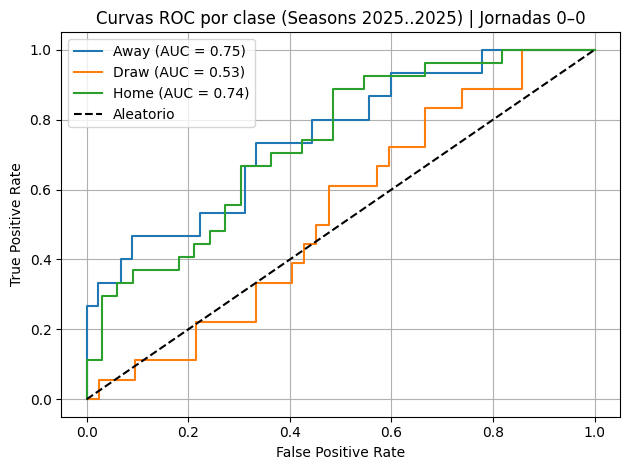


AUC macro: 0.673
AUC weighted: 0.679


In [29]:
# EJECUTAR EN LOCAL
plot_multiclass_roc(df, model, scaler, train_until_season=2024, test_until_season=2025, with_odds=True)

## **BENEFICIOS**

Por último, pero no por ello menos importante vamos a estudiar la última métrica: El **ROI (Return on Investment)**.

$$
ROI = \frac{\text{Beneficio}}{\text{Inversión}}
$$

Con el código siguiente lo que estoy haciendo es simular una apuesta de un euro al resultado que predice mi modelo, en todos los partidos que hay en test. Si se acierta sumamos la cuota que ofrece Bet365 pero si falla se resta la unidad apostada. Con esto calculamos el beneficio neto y el ROI.

In [59]:
# ============================================
# ROI por temporada (sin df_old) - Celda única
# ============================================

# --- Rutas (fallback si no existen variables del proyecto) ---
try:
    ROOT
except NameError:
    ROOT = Path(".")
try:
    DATA
except NameError:
    DATA = ROOT / "data"

FEAT = DATA / "03_features"

# --- Carga base: df_final ya incluye nombres de equipos ---
df = pd.read_parquet(FEAT / "df_final.parquet").reset_index(drop=True)

# --- Constantes útiles ---
CLASS2TXT = {0: "A", 1: "D", 2: "H"}   # 0=Away, 1=Draw, 2=Home
TXT2IDX   = {'A':0, 'D':1, 'H':2}

# ---------- Split de TEST con índices ----------
def _prep_test_split(
    df: pd.DataFrame,
    train_until_season: int,
    with_odds: bool,
    test_until_season: int | None = None
):
    # Importante: excluir variables de nombre de equipos de X
    drop_common = [
        'FTR','target','Date','has_xg_data',
        'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6',
        'HomeTeam_norm','AwayTeam_norm','row_id'  # <- evita fuga de info
    ]
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para el split temporal.")

    test_mask = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    idx_test = X_all.index[test_mask]  # <- AÑADIDO: devolver índices
    X_test = X_all.loc[idx_test].drop(columns=['Season'])
    y_test = y_all.loc[idx_test]
    return X_test, y_test, idx_test

# ---------- Alinear columnas al fit ----------
def _align_to_fit_columns(X: pd.DataFrame, fitter, feature_names: list[str] | None = None) -> pd.DataFrame:
    cols_fit = feature_names if feature_names is not None else getattr(fitter, "feature_names_in_", None)
    if cols_fit is None:
        return X
    cols_fit = list(cols_fit)
    missing = [c for c in cols_fit if c not in X.columns]
    extra   = [c for c in X.columns   if c not in cols_fit]
    if extra:
        X = X.drop(columns=extra)
    if missing:
        raise ValueError(
            "X_test no contiene columnas usadas al entrenar:\n"
            f"- Faltan: {missing}\n"
            "Usa el mismo esquema (with_odds/drop_cols) que en el fit, "
            "o pasa 'feature_names' con la lista exacta del entrenamiento."
        )
    return X[cols_fit]

# ---------- Meta alineada (nombres + cuotas + jornada) desde df ----------
def attach_names_and_odds(df: pd.DataFrame, idx: pd.Index) -> pd.DataFrame:
    # AÑADIDO 'Wk' para llevar la jornada en el resultado
    need = ["Season","Date","HomeTeam_norm","AwayTeam_norm","Wk","B365H","B365D","B365A"]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise ValueError(f"Faltan columnas en df: {missing}")
    meta = df.loc[idx, need].copy()
    meta["Date"] = pd.to_datetime(meta["Date"], errors="coerce")
    return meta

# ---------- Utilidades de reporting ----------
def _max_drawdown(equity: pd.Series):
    """Devuelve drawdown máximo: (mdd_abs, mdd_pct, peak_idx, trough_idx)."""
    if equity.empty:
        return 0.0, 0.0, None, None
    running_max = equity.cummax()
    drawdown = running_max - equity
    trough_idx = drawdown.idxmax()
    peak_idx = equity.loc[:trough_idx].idxmax() if trough_idx is not None else None
    mdd_abs = float(drawdown.max())
    peak_val = float(equity.loc[peak_idx]) if peak_idx is not None else 1.0
    mdd_pct = float(mdd_abs / peak_val) if peak_val > 0 else 0.0
    return mdd_abs, mdd_pct, peak_idx, trough_idx

def _edge_bins(edge: pd.Series, bins=(-np.inf, 0.0, 0.02, 0.05, np.inf),
               labels=("<0%", "0–2%", "2–5%", "≥5%")):
    """Discretiza edge (EV de la PREDICCIÓN) en tramos para analizar ROI."""
    return pd.cut(edge, bins=bins, labels=labels, include_lowest=True, right=False)

# ---------- Simulación ROI (con columnas de "valor" EV por clase) ----------
def simulate_bet365_roi(
    df: pd.DataFrame,
    model,
    scaler,
    train_until_season: int,
    test_until_season: int | None = None,
    with_odds: bool = True,
    stake: float = 1.0,
    feature_names: list[str] | None = None,
    min_edge: float = 0.00,     # filtro por EV mínimo de la PREDICCIÓN
):
    # 1) TEST
    X_test, y_test, idx_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        return None, np.nan, np.nan

    # 2) Alinear columnas y predecir
    X_test = _align_to_fit_columns(X_test, scaler, feature_names=feature_names)
    Xs     = scaler.transform(X_test)
    proba  = model.predict_proba(Xs)
    y_pred = model.predict(Xs)

    # 3) Meta (nombres/fechas/cuotas/jornada) desde df
    res = attach_names_and_odds(df, idx_test)
    res['true_result']      = y_test.loc[res.index].values
    res['predicted_result'] = pd.Series(y_pred, index=idx_test).loc[res.index].values

    # 4) Probs/odds/edge de la predicción y "value" EV por clase
    name_map  = {0:'A',1:'D',2:'H'}
    classes   = list(model.classes_)  # típicamente [0,1,2]
    proba_df  = pd.DataFrame(proba, index=idx_test, columns=[name_map.get(c, str(c)) for c in classes]).loc[res.index]
    proba_fix = proba_df.reindex(columns=['A','D','H'])
    odds_fix  = res[['B365A','B365D','B365H']].rename(columns={'B365A':'A','B365D':'D','B365H':'H'})[['A','D','H']]

    pred_txt = pd.Series(y_pred, index=idx_test).map(name_map).loc[res.index]
    pred_idx = pred_txt.map(TXT2IDX).to_numpy()

    P, O = proba_fix.to_numpy(), odds_fix.to_numpy()

    res['Pred']           = pred_txt
    res['predicted_prob'] = P[np.arange(len(res)), pred_idx]
    res['predicted_odds'] = O[np.arange(len(res)), pred_idx]
    res['edge']           = res['predicted_prob'] * res['predicted_odds'] - 1.0

    # Value betting (mejor EV entre H/D/A, informativo)
    EV = proba_fix * odds_fix - 1.0
    best_idx = EV.to_numpy().argmax(axis=1)
    labels = np.array(['A','D','H'])
    res['value_pick'] = labels[best_idx]
    res['value_ev']   = EV.to_numpy()[np.arange(len(EV)), best_idx]
    res['value_prob'] = P[np.arange(len(P)), best_idx]
    res['value_odds'] = O[np.arange(len(O)), best_idx]

    # 5) Filtros
    mask_odds = res[['B365H','B365D','B365A']].notna().all(axis=1)
    res = res.loc[mask_odds].copy()
    if min_edge > 0:
        res = res.loc[res['edge'] >= min_edge].copy()
    if res.empty:
        return None, np.nan, np.nan

    # 6) Simulación (apuesto SIEMPRE a la predicción)
    res['bet_outcome'] = np.where(
        res['predicted_result'] == res['true_result'],
        res['predicted_odds'] * stake, 0.0
    )
    res['net_profit'] = res['bet_outcome'] - stake

    # Fechas amigables
    res['Date'] = pd.to_datetime(res['Date'], errors='coerce').dt.strftime('%Y-%m-%d')

    total_net = float(res['net_profit'].sum())
    n_bets    = int(len(res))
    roi       = total_net / (stake * n_bets) if n_bets > 0 else np.nan
    return res, roi, total_net

# ===== Refit por temporada (BASE y SMOTE) =====
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
try:
    from imblearn.over_sampling import SMOTE
except Exception:
    SMOTE = None

def _prep_train_test_with_features(
    df: pd.DataFrame,
    train_until_season: int,
    test_until_season: int,
    with_odds: bool = True
):
    drop_common = [
        'FTR','target','Date','has_xg_data',
        'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6',
        'HomeTeam_norm','AwayTeam_norm','row_id'
    ]
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns: valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)
    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para el split temporal.")

    train_mask = X_all['Season'] <= train_until_season
    test_mask  = X_all['Season'] == test_until_season

    features = [c for c in X_all.columns if c != 'Season']
    X_train, y_train = X_all.loc[train_mask, features], y_all.loc[train_mask]
    X_test,  y_test  = X_all.loc[test_mask,  features], y_all.loc[test_mask]
    idx_test = X_all.loc[test_mask].index
    return X_train, y_train, X_test, y_test, idx_test, features

def _refit_base_model_for_season(
    df: pd.DataFrame,
    train_until: int,
    test_season: int,
    with_odds: bool = True,
    random_state: int = 42
):
    X_tr, y_tr, X_te, y_te, idx_te, feat = _prep_train_test_with_features(
        df, train_until_season=train_until, test_until_season=test_season, with_odds=with_odds
    )
    if len(X_te) == 0:
        return None, None
    scaler_local = StandardScaler()
    X_tr_s = scaler_local.fit_transform(X_tr)
    mdl = LogisticRegression(solver='saga', penalty='l2', max_iter=1000, random_state=random_state)
    mdl.fit(X_tr_s, y_tr)
    setattr(scaler_local, "feature_names_in_", np.array(feat, dtype=object))
    setattr(mdl,          "feature_names_in_", np.array(feat, dtype=object))
    return mdl, scaler_local

def _refit_smote_model_for_season(
    df: pd.DataFrame,
    train_until: int,
    test_season: int,
    with_odds: bool = True,
    random_state: int = 42
):
    if SMOTE is None:
        raise ImportError("Para SMOTE necesitas 'imbalanced-learn'.")
    X_tr, y_tr, X_te, y_te, idx_te, feat = _prep_train_test_with_features(
        df, train_until_season=train_until, test_until_season=test_season, with_odds=with_odds
    )
    if len(X_te) == 0:
        return None, None
    scaler_local = StandardScaler()
    X_tr_s = scaler_local.fit_transform(X_tr)

    _, counts = np.unique(y_tr, return_counts=True)
    min_count = int(counts.min()) if len(counts) else 0
    if min_count <= 1:
        X_res, y_res = X_tr_s, y_tr
    else:
        k = max(1, min(5, min_count - 1))
        try:
            sm = SMOTE(random_state=random_state, k_neighbors=k)
            X_res, y_res = sm.fit_resample(X_tr_s, y_tr)
        except Exception:
            X_res, y_res = X_tr_s, y_tr

    mdl = LogisticRegression(solver='saga', penalty='l2', max_iter=1000, random_state=random_state)
    mdl.fit(X_res, y_res)
    setattr(scaler_local, "feature_names_in_", np.array(feat, dtype=object))
    setattr(mdl,          "feature_names_in_", np.array(feat, dtype=object))
    return mdl, scaler_local

# ---------- Rejilla ROI por temporada ----------
def build_roi_grid(
    df: pd.DataFrame,
    model, scaler,
    seasons: list[int] | None = None,
    with_odds: bool = True,
    stake: float = 1.0,
    feature_names: list[str] | None = None,
    min_edge: float = 0.00,
    model_name: str = "base",
    out_dir: Path | None = None
):
    seasons_all = sorted(df["Season"].dropna().astype(int).unique())
    if seasons is None:
        seasons = seasons_all

    OUT = (out_dir or (ROOT / "outputs"))
    OUT.mkdir(parents=True, exist_ok=True)

    rows = []
    flat_for_csv = []

    for test_season in seasons:
        train_until = test_season - 1
        if train_until < seasons_all[0]:
            continue

        # === REFIT CONSISTENTE POR TEMPORADA PARA AMBOS MODELOS ===
        if str(model_name).lower() == "smote":
            use_model, use_scaler = _refit_smote_model_for_season(
                df, train_until=train_until, test_season=test_season, with_odds=with_odds, random_state=42
            )
        else:  # "base"
            use_model, use_scaler = _refit_base_model_for_season(
                df, train_until=train_until, test_season=test_season, with_odds=with_odds, random_state=42
            )
        if (use_model is None) or (use_scaler is None):
            continue

        res, roi, total_net = simulate_bet365_roi(
            df, use_model, use_scaler,
            train_until_season=train_until,
            test_until_season=test_season,
            with_odds=with_odds, stake=stake,
            feature_names=None, min_edge=min_edge
        )
        if res is None or len(res) == 0:
            continue

        # Orden por fecha para equity
        tmp = res.copy()
        tmp['_Date'] = pd.to_datetime(tmp['Date'], errors='coerce')
        tmp = tmp.sort_values('_Date').drop(columns=['_Date'])

        equity = tmp['net_profit'].cumsum()
        mdd_abs, mdd_pct, *_ = _max_drawdown(equity)

        hit_rate = float((tmp['predicted_result'] == tmp['true_result']).mean())
        avg_odds = float(tmp['predicted_odds'].mean())
        avg_edge = float(tmp['edge'].mean())
        avg_value_ev = float(tmp['value_ev'].mean())

        by_class = tmp.groupby(tmp['predicted_result']).agg(
            profit=('net_profit','sum'), n=('net_profit','size')
        )
        profit_by_class = {CLASS2TXT.get(int(k), str(k)): float(v) for k, v in by_class['profit'].items()}

        # --- rango de jornadas en el test ---
        wk_min = wk_max = None
        if 'Wk' in tmp.columns and len(tmp):
            wks = pd.to_numeric(tmp['Wk'], errors='coerce').dropna().astype(int)
            if len(wks):
                wk_min = int(wks.min())
                wk_max = int(wks.max())

        bins = _edge_bins(tmp['edge'])
        by_bin = tmp.groupby(bins, observed=True).agg(
            n=('net_profit','size'),
            profit=('net_profit','sum'),
            avg_prob=('predicted_prob','mean'),
            avg_odds=('predicted_odds','mean'),
            avg_edge=('edge','mean')
        ).reset_index(names='edge_bin')
        by_bin['roi'] = by_bin.apply(lambda r: (r['profit']/(stake*r['n'])) if r['n']>0 else np.nan, axis=1)
        roi_by_edge_bins = [
            {
                "bin": str(row['edge_bin']),
                "n": int(row['n']),
                "roi": float(row['roi']),
                "profit_total": float(row['profit']),
                "avg_prob": float(row['avg_prob']),
                "avg_odds": float(row['avg_odds']),
                "avg_edge": float(row['avg_edge']),
            }
            for _, row in by_bin.iterrows()
        ]

        rows.append({
            "model": model_name,
            "train_until": int(train_until),
            "test_season": int(test_season),
            "n_bets": int(len(tmp)),
            "profit_total": float(total_net),
            "roi": float(roi),
            "hit_rate": float(hit_rate),
            "avg_odds": float(avg_odds),
            "avg_edge": float(avg_edge),
            "avg_value_ev": float(avg_value_ev),
            "profit_by_class": profit_by_class,
            "equity": [float(x) for x in equity.tolist()],
            "max_drawdown_abs": float(mdd_abs),
            "max_drawdown_pct": float(mdd_pct),
            "roi_by_edge_bins": roi_by_edge_bins,
            "stake": float(stake),
            "min_edge": float(min_edge),
            "wk_min": wk_min,
            "wk_max": wk_max,
        })

        flat_for_csv.append({
            "model": model_name,
            "test_season": int(test_season),
            "train_until": int(train_until),
            "n_bets": int(len(tmp)),
            "roi": float(roi),
            "profit_total": float(total_net),
            "hit_rate": float(hit_rate),
            "avg_odds": float(avg_odds),
            "avg_edge": float(avg_edge),
            "avg_value_ev": float(avg_value_ev),
            "max_drawdown_pct": float(mdd_pct),
            "stake": float(stake),
            "min_edge": float(min_edge),
            "wk_min": wk_min,
            "wk_max": wk_max,
        })

    tag = f"{model_name}".replace(" ", "_")
    (OUT / f"roi_by_season_{tag}.json").write_text(json.dumps(rows, ensure_ascii=False, indent=2), encoding="utf-8")
    if flat_for_csv:
        pd.DataFrame(flat_for_csv).sort_values("test_season").to_csv(OUT / f"roi_by_season_{tag}.csv", index=False)

    print(f"Guardados:\n- {OUT/f'roi_by_season_{tag}.json'}\n- {OUT/f'roi_by_season_{tag}.csv'}")
    return rows

# =========================
# EJEMPLOS DE USO (comenta/ajusta)
# =========================
_ = build_roi_grid(
    df=df, model=None, scaler=None,   # ignorados (ahora se refitea dentro)
    seasons=None, with_odds=True, stake=1.0,
    min_edge=0.00, model_name="base"
)
_ = build_roi_grid(
    df=df, model=None, scaler=None,   # ignorados (ahora se refitea dentro)
    seasons=None, with_odds=True, stake=1.0,
    min_edge=0.00, model_name="smote"
)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist

Guardados:
- outputs/roi_by_season_base.json
- outputs/roi_by_season_base.csv


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist

Guardados:
- outputs/roi_by_season_smote.json
- outputs/roi_by_season_smote.csv


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [54]:
# ============================================
# ROI por temporada (sin df_old) - Celda única
# ============================================

# --- Rutas (fallback si no existen variables del proyecto) ---
try:
    ROOT
except NameError:
    from pathlib import Path
    ROOT = Path(".")
try:
    DATA
except NameError:
    DATA = ROOT / "data"

import json, numpy as np, pandas as pd
from pathlib import Path

FEAT = DATA / "03_features"

# --- Carga base: df_final ya incluye nombres de equipos ---
df = pd.read_parquet(FEAT / "df_final.parquet").reset_index(drop=True)

# --- Constantes útiles ---
CLASS2TXT = {0: "A", 1: "D", 2: "H"}   # 0=Away, 1=Draw, 2=Home
TXT2IDX   = {'A':0, 'D':1, 'H':2}

# ---------- Split de TEST con índices ----------
def _prep_test_split(
    df: pd.DataFrame,
    train_until_season: int,
    with_odds: bool,
    test_until_season: int | None = None
):
    # Importante: excluir variables de nombre de equipos de X
    drop_common = [
        'FTR','target','Date','has_xg_data',
        'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6',
        'HomeTeam_norm','AwayTeam_norm','row_id'
    ]
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para el split temporal.")

    test_mask = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    idx_test = X_all.index[test_mask]  # <- devolvemos índices
    X_test = X_all.loc[idx_test].drop(columns=['Season'])
    y_test = y_all.loc[idx_test]
    return X_test, y_test, idx_test

# ---------- Alinear columnas al fit ----------
def _align_to_fit_columns(X: pd.DataFrame, fitter, feature_names: list[str] | None = None) -> pd.DataFrame:
    cols_fit = feature_names if feature_names is not None else getattr(fitter, "feature_names_in_", None)
    if cols_fit is None:
        return X
    cols_fit = list(cols_fit)
    missing = [c for c in cols_fit if c not in X.columns]
    extra   = [c for c in X.columns   if c not in cols_fit]
    if extra:
        X = X.drop(columns=extra)
    if missing:
        raise ValueError(
            "X_test no contiene columnas usadas al entrenar:\n"
            f"- Faltan: {missing}\n"
            "Usa el mismo esquema (with_odds/drop_cols) que en el fit, "
            "o pasa 'feature_names' con la lista exacta del entrenamiento."
        )
    return X[cols_fit]

# ---------- Meta alineada (nombres + cuotas + jornada) desde df ----------
def attach_names_and_odds(df: pd.DataFrame, idx: pd.Index) -> pd.DataFrame:
    # Incluimos 'Wk' para llevar la jornada
    need = ["Season","Date","HomeTeam_norm","AwayTeam_norm","Wk","B365H","B365D","B365A"]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise ValueError(f"Faltan columnas en df: {missing}")
    meta = df.loc[idx, need].copy()
    meta["Date"] = pd.to_datetime(meta["Date"], errors="coerce")
    return meta

# ---------- Utilidades de reporting ----------
def _max_drawdown(equity: pd.Series):
    """Devuelve drawdown máximo: (mdd_abs, mdd_pct, peak_idx, trough_idx)."""
    if equity.empty:
        return 0.0, 0.0, None, None
    running_max = equity.cummax()
    drawdown = running_max - equity
    trough_idx = drawdown.idxmax()
    peak_idx = equity.loc[:trough_idx].idxmax() if trough_idx is not None else None
    mdd_abs = float(drawdown.max())
    peak_val = float(equity.loc[peak_idx]) if peak_idx is not None else 1.0
    mdd_pct = float(mdd_abs / peak_val) if peak_val > 0 else 0.0
    return mdd_abs, mdd_pct, peak_idx, trough_idx

def _edge_bins(edge: pd.Series, bins=(-np.inf, 0.0, 0.02, 0.05, np.inf),
               labels=("<0%", "0–2%", "2–5%", "≥5%")):
    """Discretiza edge (EV de la PREDICCIÓN) en tramos para analizar ROI."""
    return pd.cut(edge, bins=bins, labels=labels, include_lowest=True, right=False)

# ---------- Simulación ROI (con columnas de "valor" EV por clase) ----------
def simulate_bet365_roi(
    df: pd.DataFrame,
    model,
    scaler,
    train_until_season: int,
    test_until_season: int | None = None,
    with_odds: bool = True,
    stake: float = 1.0,
    feature_names: list[str] | None = None,
    min_edge: float = 0.00,     # filtro por EV mínimo de la PREDICCIÓN
):
    # 1) TEST
    X_test, y_test, idx_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        return None, np.nan, np.nan

    # 2) Alinear columnas y predecir (evita warnings de feature names)
    X_test = _align_to_fit_columns(X_test, scaler, feature_names=feature_names)
    Xs = scaler.transform(X_test)
    feat_in = getattr(model, "feature_names_in_", None)
    if feat_in is not None and not isinstance(Xs, pd.DataFrame):
        Xs_for_model = pd.DataFrame(Xs, index=X_test.index, columns=list(feat_in))
    else:
        Xs_for_model = Xs

    proba  = model.predict_proba(Xs_for_model)
    y_pred = model.predict(Xs_for_model)

    # 3) Meta (nombres/fechas/cuotas/jornada) desde df
    res = attach_names_and_odds(df, idx_test)
    res['true_result']      = y_test.loc[res.index].values
    res['predicted_result'] = pd.Series(y_pred, index=idx_test).loc[res.index].values

    # 4) Probs/odds/edge de la predicción y "value" EV por clase
    name_map  = {0:'A',1:'D',2:'H'}
    classes   = list(getattr(model, "classes_", [0,1,2]))
    proba_df  = pd.DataFrame(proba, index=idx_test, columns=[name_map.get(int(c), str(c)) for c in classes]).loc[res.index]
    proba_fix = proba_df.reindex(columns=['A','D','H'])
    odds_fix  = res[['B365A','B365D','B365H']].rename(columns={'B365A':'A','B365D':'D','B365H':'H'})[['A','D','H']]

    pred_txt = pd.Series(y_pred, index=idx_test).map(name_map).loc[res.index]
    pred_idx = pred_txt.map(TXT2IDX).to_numpy()

    P, O = proba_fix.to_numpy(), odds_fix.to_numpy()

    res['Pred']           = pred_txt
    res['predicted_prob'] = P[np.arange(len(res)), pred_idx]
    res['predicted_odds'] = O[np.arange(len(res)), pred_idx]
    res['edge']           = res['predicted_prob'] * res['predicted_odds'] - 1.0

    # Value betting (mejor EV entre H/D/A, informativo)
    EV = proba_fix * odds_fix - 1.0
    best_idx = EV.to_numpy().argmax(axis=1)
    labels = np.array(['A','D','H'])
    res['value_pick'] = labels[best_idx]
    res['value_ev']   = EV.to_numpy()[np.arange(len(EV)), best_idx]
    res['value_prob'] = P[np.arange(len(P)), best_idx]
    res['value_odds'] = O[np.arange(len(O)), best_idx]

    # 5) Filtros
    mask_odds = res[['B365H','B365D','B365A']].notna().all(axis=1)
    res = res.loc[mask_odds].copy()
    if min_edge > 0:
        res = res.loc[res['edge'] >= min_edge].copy()
    if res.empty:
        return None, np.nan, np.nan

    # 6) Simulación (apuesto SIEMPRE a la predicción)
    res['bet_outcome'] = np.where(
        res['predicted_result'] == res['true_result'],
        res['predicted_odds'] * stake, 0.0
    )
    res['net_profit'] = res['bet_outcome'] - stake

    # Fechas amigables
    res['Date'] = pd.to_datetime(res['Date'], errors='coerce').dt.strftime('%Y-%m-%d')

    total_net = float(res['net_profit'].sum())
    n_bets    = int(len(res))
    roi       = total_net / (stake * n_bets) if n_bets > 0 else np.nan
    return res, roi, total_net

# ===== Refit SMOTE por temporada dentro del grid (para que NO sea igual que base) =====
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
try:
    from imblearn.over_sampling import SMOTE
except Exception:
    SMOTE = None  # si no está imblearn, se avisará

def _prep_train_test_with_features(
    df: pd.DataFrame,
    train_until_season: int,
    test_until_season: int,
    with_odds: bool = True
):
    # Misma lógica de exclusiones
    drop_common = [
        'FTR','target','Date','has_xg_data',
        'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6',
        'HomeTeam_norm','AwayTeam_norm','row_id'
    ]
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns: valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)
    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para el split temporal.")

    train_mask = X_all['Season'] <= train_until_season
    test_mask  = X_all['Season'] == test_until_season

    features = [c for c in X_all.columns if c != 'Season']
    X_train, y_train = X_all.loc[train_mask, features], y_all.loc[train_mask]
    X_test,  y_test  = X_all.loc[test_mask,  features], y_all.loc[test_mask]
    idx_test = X_all.loc[test_mask].index
    return X_train, y_train, X_test, y_test, idx_test, features

def _refit_smote_model_for_season(
    df: pd.DataFrame,
    train_until: int,
    test_season: int,
    with_odds: bool = True,
    random_state: int = 42
):
    if SMOTE is None:
        raise ImportError("Para SMOTE necesitas 'imbalanced-learn'.")
    X_tr, y_tr, X_te, y_te, idx_te, feat = _prep_train_test_with_features(
        df, train_until_season=train_until, test_until_season=test_season, with_odds=with_odds
    )
    if len(X_te) == 0:
        return None, None  # sin test en esa season

    scaler_local = StandardScaler()
    # fit con DataFrame para que garde feature_names_in_
    X_tr_s = scaler_local.fit_transform(X_tr)

    # k robusto según la clase minoritaria
    _, counts = np.unique(y_tr, return_counts=True)
    min_count = int(counts.min()) if len(counts) else 0
    if min_count <= 1:
        X_res, y_res = X_tr_s, y_tr
    else:
        k = max(1, min(5, min_count - 1))
        try:
            sm = SMOTE(random_state=random_state, k_neighbors=k)
            X_res, y_res = sm.fit_resample(X_tr_s, y_tr)
        except Exception:
            X_res, y_res = X_tr_s, y_tr

    mdl = LogisticRegression(solver='saga', penalty='l2', max_iter=1000, random_state=random_state)
    mdl.fit(X_res, y_res)

    # Guardamos nombres de columnas usados
    setattr(scaler_local, "feature_names_in_", np.array(feat, dtype=object))
    setattr(mdl,          "feature_names_in_", np.array(feat, dtype=object))
    return mdl, scaler_local

# ---------- Rejilla ROI por temporada ----------
def build_roi_grid(
    df: pd.DataFrame,
    model, scaler,
    seasons: list[int] | None = None,
    with_odds: bool = True,
    stake: float = 1.0,
    feature_names: list[str] | None = None,
    min_edge: float = 0.00,
    model_name: str = "base",
    out_dir: Path | None = None
):
    seasons_all = sorted(df["Season"].dropna().astype(int).unique())
    if seasons is None:
        seasons = seasons_all

    OUT = (out_dir or (ROOT / "outputs"))
    OUT.mkdir(parents=True, exist_ok=True)

    rows = []
    flat_for_csv = []

    for test_season in seasons:
        train_until = test_season - 1
        if train_until < seasons_all[0]:
            continue

        # Si es SMOTE, se reentrena por temporada (para que NO coincida con base)
        if str(model_name).lower() == "smote":
            local_mdl, local_scaler = _refit_smote_model_for_season(
                df, train_until=train_until, test_season=test_season, with_odds=with_odds, random_state=42
            )
            if (local_mdl is None) or (local_scaler is None):
                continue
            use_model, use_scaler = local_mdl, local_scaler
            feat_names = None  # el modelo/escalares llevan feature_names_in_
        else:
            use_model, use_scaler = model, scaler
            feat_names = feature_names

        res, roi, total_net = simulate_bet365_roi(
            df, use_model, use_scaler,
            train_until_season=train_until,
            test_until_season=test_season,
            with_odds=with_odds, stake=stake,
            feature_names=feat_names, min_edge=min_edge
        )
        if res is None or len(res) == 0:
            continue

        # Orden por fecha para equity
        tmp = res.copy()
        tmp['_Date'] = pd.to_datetime(tmp['Date'], errors='coerce')
        tmp = tmp.sort_values('_Date').drop(columns=['_Date'])

        equity = tmp['net_profit'].cumsum()
        mdd_abs, mdd_pct, *_ = _max_drawdown(equity)

        hit_rate = float((tmp['predicted_result'] == tmp['true_result']).mean())
        avg_odds = float(tmp['predicted_odds'].mean())
        avg_edge = float(tmp['edge'].mean())
        avg_value_ev = float(tmp['value_ev'].mean())

        by_class = tmp.groupby(tmp['predicted_result']).agg(
            profit=('net_profit','sum'), n=('net_profit','size')
        )
        profit_by_class = {CLASS2TXT.get(int(k), str(k)): float(v) for k, v in by_class['profit'].items()}

        # rango de jornadas en el test
        wk_min = wk_max = None
        if 'Wk' in tmp.columns and len(tmp):
            wks = pd.to_numeric(tmp['Wk'], errors='coerce').dropna().astype(int)
            if len(wks):
                wk_min = int(wks.min())
                wk_max = int(wks.max())

        bins = _edge_bins(tmp['edge'])
        by_bin = tmp.groupby(bins, observed=True).agg(
            n=('net_profit','size'),
            profit=('net_profit','sum'),
            avg_prob=('predicted_prob','mean'),
            avg_odds=('predicted_odds','mean'),
            avg_edge=('edge','mean')
        ).reset_index(names='edge_bin')
        by_bin['roi'] = by_bin.apply(lambda r: (r['profit']/(stake*r['n'])) if r['n']>0 else np.nan, axis=1)
        roi_by_edge_bins = [
            {
                "bin": str(row['edge_bin']),
                "n": int(row['n']),
                "roi": float(row['roi']),
                "profit_total": float(row['profit']),
                "avg_prob": float(row['avg_prob']),
                "avg_odds": float(row['avg_odds']),
                "avg_edge": float(row['avg_edge']),
            }
            for _, row in by_bin.iterrows()
        ]

        rows.append({
            "model": model_name,
            "train_until": int(train_until),
            "test_season": int(test_season),
            "n_bets": int(len(tmp)),
            "profit_total": float(total_net),
            "roi": float(roi),
            "hit_rate": float(hit_rate),
            "avg_odds": float(avg_odds),
            "avg_edge": float(avg_edge),
            "avg_value_ev": float(avg_value_ev),
            "profit_by_class": profit_by_class,
            "equity": [float(x) for x in equity.tolist()],
            "max_drawdown_abs": float(mdd_abs),
            "max_drawdown_pct": float(mdd_pct),
            "roi_by_edge_bins": roi_by_edge_bins,
            "stake": float(stake),
            "min_edge": float(min_edge),
            "wk_min": wk_min,
            "wk_max": wk_max,
        })

        flat_for_csv.append({
            "model": model_name,
            "test_season": int(test_season),
            "train_until": int(train_until),
            "n_bets": int(len(tmp)),
            "roi": float(roi),
            "profit_total": float(total_net),
            "hit_rate": float(hit_rate),
            "avg_odds": float(avg_odds),
            "avg_edge": float(avg_edge),
            "avg_value_ev": float(avg_value_ev),
            "max_drawdown_pct": float(mdd_pct),
            "stake": float(stake),
            "min_edge": float(min_edge),
            "wk_min": wk_min,
            "wk_max": wk_max,
        })

    tag = f"{model_name}".replace(" ", "_")
    (OUT / f"roi_by_season_{tag}.json").write_text(json.dumps(rows, ensure_ascii=False, indent=2), encoding="utf-8")
    if flat_for_csv:
        pd.DataFrame(flat_for_csv).sort_values("test_season").to_csv(OUT / f"roi_by_season_{tag}.csv", index=False)

    print(f"Guardados:\n- {OUT/f'roi_by_season_{tag}.json'}\n- {OUT/f'roi_by_season_{tag}.csv'}")
    return rows

# =========================
# EJECUCIÓN (solo métricas a outputs)
# =========================
# Nota: 'model' y 'scaler' deben estar ya entrenados (baseline SIN SMOTE).
# Para SMOTE, el reentrenado por temporada se hace dentro de build_roi_grid.
OUT = ROOT / "outputs"; OUT.mkdir(parents=True, exist_ok=True)

_ = build_roi_grid(
    df=df, model=model, scaler=scaler,
    seasons=None, with_odds=True, stake=1.0,
    min_edge=0.00, model_name="base", out_dir=OUT
)
_ = build_roi_grid(
    df=df, model=model, scaler=scaler,  # se ignoran y se reentrena SMOTE por temporada
    seasons=None, with_odds=True, stake=1.0,
    min_edge=0.00, model_name="smote", out_dir=OUT
)

Guardados:
- outputs/roi_by_season_base.json
- outputs/roi_by_season_base.csv
Guardados:
- outputs/roi_by_season_smote.json
- outputs/roi_by_season_smote.csv


In [43]:
# ============================================
# ROI por temporada (sin df_old) - Celda única
# ============================================

from pathlib import Path
import json
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

try:
    from imblearn.over_sampling import SMOTE
except Exception as _e:
    SMOTE = None  # si no está instalado, daremos error solo al pedir "smote"

# --- Rutas (fallback si no existen variables del proyecto) ---
try:
    ROOT
except NameError:
    ROOT = Path(".")
try:
    DATA
except NameError:
    DATA = ROOT / "data"

FEAT = DATA / "03_features"

# --- Carga base: df_final ya incluye nombres de equipos ---
df = pd.read_parquet(FEAT / "df_final.parquet").reset_index(drop=True)

# --- Constantes útiles ---
CLASS2TXT = {0: "A", 1: "D", 2: "H"}   # 0=Away, 1=Draw, 2=Home
TXT2IDX   = {'A':0, 'D':1, 'H':2}

# ---------- Split de TEST con índices ----------
def _prep_test_split(
    df: pd.DataFrame,
    train_until_season: int,
    with_odds: bool,
    test_until_season: int | None = None
):
    # Importante: excluir variables de nombre de equipos de X
    drop_common = [
        'FTR','target','Date','has_xg_data',
        'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6',
        'HomeTeam_norm','AwayTeam_norm','row_id'  # <- evita fuga de info
    ]
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para el split temporal.")

    test_mask = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    idx_test = X_all.index[test_mask]  # <- AÑADIDO: devolver índices
    X_test = X_all.loc[idx_test].drop(columns=['Season'])
    y_test = y_all.loc[idx_test]
    return X_test, y_test, idx_test

# ---------- Split TRAIN/TEST con features (para refit SMOTE por temporada) ----------
def _prep_train_test_with_features(
    df: pd.DataFrame,
    train_until_season: int,
    test_until_season: int | None = None,
    with_odds: bool = True
):
    drop_common = [
        'FTR','target','Date','has_xg_data',
        'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6',
        'HomeTeam_norm','AwayTeam_norm','row_id'
    ]
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para el split temporal.")

    train_mask = X_all['Season'] <= train_until_season
    test_mask  = X_all['Season'] >  train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    feature_cols = [c for c in X_all.columns if c != 'Season']

    X_train = X_all.loc[train_mask, feature_cols]
    y_train = y_all.loc[train_mask]

    X_test  = X_all.loc[test_mask, feature_cols]
    y_test  = y_all.loc[test_mask]
    idx_test = X_all.loc[test_mask].index

    return X_train, y_train, X_test, y_test, idx_test, feature_cols

# ---------- Alinear columnas al fit ----------
def _align_to_fit_columns(X: pd.DataFrame, fitter, feature_names: list[str] | None = None) -> pd.DataFrame:
    cols_fit = feature_names if feature_names is not None else getattr(fitter, "feature_names_in_", None)
    if cols_fit is None:
        return X
    cols_fit = list(cols_fit)
    missing = [c for c in cols_fit if c not in X.columns]
    extra   = [c for c in X.columns   if c not in cols_fit]
    if extra:
        X = X.drop(columns=extra)
    if missing:
        raise ValueError(
            "X_test no contiene columnas usadas al entrenar:\n"
            f"- Faltan: {missing}\n"
            "Usa el mismo esquema (with_odds/drop_cols) que en el fit, "
            "o pasa 'feature_names' con la lista exacta del entrenamiento."
        )
    return X[cols_fit]

# ---------- Meta alineada (nombres + cuotas + jornada) desde df ----------
def attach_names_and_odds(df: pd.DataFrame, idx: pd.Index) -> pd.DataFrame:
    # incluye 'Wk' para llevar la jornada
    need = ["Season","Date","HomeTeam_norm","AwayTeam_norm","Wk","B365H","B365D","B365A"]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise ValueError(f"Faltan columnas en df: {missing}")
    meta = df.loc[idx, need].copy()
    meta["Date"] = pd.to_datetime(meta["Date"], errors="coerce")
    return meta

# ---------- Utilidades de reporting ----------
def _max_drawdown(equity: pd.Series):
    if equity.empty:
        return 0.0, 0.0, None, None
    running_max = equity.cummax()
    drawdown = running_max - equity
    trough_idx = drawdown.idxmax()
    peak_idx = equity.loc[:trough_idx].idxmax() if trough_idx is not None else None
    mdd_abs = float(drawdown.max())
    peak_val = float(equity.loc[peak_idx]) if peak_idx is not None else 1.0
    mdd_pct = float(mdd_abs / peak_val) if peak_val > 0 else 0.0
    return mdd_abs, mdd_pct, peak_idx, trough_idx

def _edge_bins(edge: pd.Series, bins=(-np.inf, 0.0, 0.02, 0.05, np.inf),
               labels=("<0%", "0–2%", "2–5%", "≥5%")):
    return pd.cut(edge, bins=bins, labels=labels, include_lowest=True, right=False)

# ---------- Simulación ROI (con columnas de "valor" EV por clase) ----------
def simulate_bet365_roi(
    df: pd.DataFrame,
    model,
    scaler,
    train_until_season: int,
    test_until_season: int | None = None,
    with_odds: bool = True,
    stake: float = 1.0,
    feature_names: list[str] | None = None,
    min_edge: float = 0.00,
):
    # 1) TEST
    X_test, y_test, idx_test = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        return None, np.nan, np.nan

    # 2) Alinear columnas y predecir
    X_test = _align_to_fit_columns(X_test, scaler, feature_names=feature_names)
    Xs     = scaler.transform(X_test)
    proba  = model.predict_proba(Xs)
    y_pred = model.predict(Xs)

    # 3) Meta (nombres/fechas/cuotas/jornada) desde df
    res = attach_names_and_odds(df, idx_test)
    res['true_result']      = y_test.loc[res.index].values
    res['predicted_result'] = pd.Series(y_pred, index=idx_test).loc[res.index].values

    # 4) Probs/odds/edge de la predicción y "value" EV por clase
    name_map  = {0:'A',1:'D',2:'H'}
    classes   = list(model.classes_)  # típicamente [0,1,2]
    proba_df  = pd.DataFrame(proba, index=idx_test, columns=[name_map.get(c, str(c)) for c in classes]).loc[res.index]
    proba_fix = proba_df.reindex(columns=['A','D','H'])
    odds_fix  = res[['B365A','B365D','B365H']].rename(columns={'B365A':'A','B365D':'D','B365H':'H'})[['A','D','H']]

    pred_txt = pd.Series(y_pred, index=idx_test).map(name_map).loc[res.index]
    pred_idx = pred_txt.map(TXT2IDX).to_numpy()

    P, O = proba_fix.to_numpy(), odds_fix.to_numpy()

    res['Pred']           = pred_txt
    res['predicted_prob'] = P[np.arange(len(res)), pred_idx]
    res['predicted_odds'] = O[np.arange(len(res)), pred_idx]
    res['edge']           = res['predicted_prob'] * res['predicted_odds'] - 1.0

    # Value betting
    EV = proba_fix * odds_fix - 1.0
    best_idx = EV.to_numpy().argmax(axis=1)
    labels = np.array(['A','D','H'])
    res['value_pick'] = labels[best_idx]
    res['value_ev']   = EV.to_numpy()[np.arange(len(EV)), best_idx]
    res['value_prob'] = P[np.arange(len(P)), best_idx]
    res['value_odds'] = O[np.arange(len(O)), best_idx]

    # 5) Filtros
    mask_odds = res[['B365H','B365D','B365A']].notna().all(axis=1)
    res = res.loc[mask_odds].copy()
    if min_edge > 0:
        res = res.loc[res['edge'] >= min_edge].copy()
    if res.empty:
        return None, np.nan, np.nan

    # 6) Simulación (apuesto SIEMPRE a la predicción)
    res['bet_outcome'] = np.where(
        res['predicted_result'] == res['true_result'],
        res['predicted_odds'] * stake, 0.0
    )
    res['net_profit'] = res['bet_outcome'] - stake

    # Fechas amigables
    res['Date'] = pd.to_datetime(res['Date'], errors='coerce').dt.strftime('%Y-%m-%d')

    total_net = float(res['net_profit'].sum())
    n_bets    = int(len(res))
    roi       = total_net / (stake * n_bets) if n_bets > 0 else np.nan
    return res, roi, total_net

# ---------- ROI por temporada con refit SMOTE interno cuando model_name == "smote" ----------
def build_roi_grid(
    df: pd.DataFrame,
    model, scaler,
    seasons: list[int] | None = None,
    with_odds: bool = True,
    stake: float = 1.0,
    feature_names: list[str] | None = None,
    min_edge: float = 0.00,
    model_name: str = "base",
    out_dir: Path | None = None,
    random_state: int = 42
):
    seasons_all = sorted(df["Season"].dropna().astype(int).unique())
    if seasons is None:
        seasons = seasons_all

    OUT = (out_dir or (ROOT / "outputs"))
    OUT.mkdir(parents=True, exist_ok=True)

    rows = []
    flat_for_csv = []

    for test_season in seasons:
        train_until = test_season - 1
        if train_until < seasons_all[0]:
            continue

        if model_name == "smote":
            # ==== Refit SMOTE por temporada (garantiza diferencia real respecto a baseline) ====
            if SMOTE is None:
                raise ImportError("imblearn no disponible: instala 'imbalanced-learn' para usar SMOTE.")
            X_tr, y_tr, X_te, y_te, idx_te, feat_cols = _prep_train_test_with_features(
                df, train_until_season=train_until, test_until_season=test_season, with_odds=with_odds
            )
            if len(X_te) == 0:
                continue

            scaler_local = StandardScaler()
            X_tr_s = scaler_local.fit_transform(X_tr)
            # k_neighbors robusto al mínimo soporte
            _, counts = np.unique(y_tr, return_counts=True)
            min_count = int(counts.min()) if len(counts) else 0
            if min_count <= 1:
                X_res, y_res = X_tr_s, y_tr
            else:
                k = max(1, min(5, min_count - 1))
                try:
                    sm = SMOTE(random_state=random_state, k_neighbors=k)
                    X_res, y_res = sm.fit_resample(X_tr_s, y_tr)
                except Exception:
                    X_res, y_res = X_tr_s, y_tr

            mdl_local = LogisticRegression(solver='saga', penalty='l2', max_iter=1000, random_state=random_state)
            mdl_local.fit(X_res, y_res)

            # --- ROI con el modelo SMOTE local ---
            # Reutilizamos la lógica de simulate_bet365_roi pero con splits y modelo locales
            # 1) predicciones sobre test
            X_te_s = scaler_local.transform(X_te)
            proba  = mdl_local.predict_proba(X_te_s)
            y_pred = mdl_local.predict(X_te_s)

            # 2) meta + métricas ROI (idéntico a simulate_bet365_roi a partir de aquí)
            res = attach_names_and_odds(df, idx_te)
            res['true_result']      = y_te.loc[res.index].values
            res['predicted_result'] = pd.Series(y_pred, index=idx_te).loc[res.index].values

            name_map = {0:'A',1:'D',2:'H'}
            classes  = list(mdl_local.classes_)
            proba_df = pd.DataFrame(proba, index=idx_te, columns=[name_map.get(c, str(c)) for c in classes]).loc[res.index]
            proba_fix = proba_df.reindex(columns=['A','D','H'])
            odds_fix  = res[['B365A','B365D','B365H']].rename(columns={'B365A':'A','B365D':'D','B365H':'H'})[['A','D','H']]

            pred_txt = pd.Series(y_pred, index=idx_te).map(name_map).loc[res.index]
            pred_idx = pred_txt.map(TXT2IDX).to_numpy()
            P, O = proba_fix.to_numpy(), odds_fix.to_numpy()

            res['Pred']           = pred_txt
            res['predicted_prob'] = P[np.arange(len(res)), pred_idx]
            res['predicted_odds'] = O[np.arange(len(res)), pred_idx]
            res['edge']           = res['predicted_prob'] * res['predicted_odds'] - 1.0

            EV = proba_fix * odds_fix - 1.0
            best_idx = EV.to_numpy().argmax(axis=1)
            labels = np.array(['A','D','H'])
            res['value_pick'] = labels[best_idx]
            res['value_ev']   = EV.to_numpy()[np.arange(len(EV)), best_idx]
            res['value_prob'] = P[np.arange(len(P)), best_idx]
            res['value_odds'] = O[np.arange(len(O)), best_idx]

            mask_odds = res[['B365H','B365D','B365A']].notna().all(axis=1)
            res = res.loc[mask_odds].copy()
            if min_edge > 0:
                res = res.loc[res['edge'] >= min_edge].copy()
            if res.empty:
                continue

            res['bet_outcome'] = np.where(
                res['predicted_result'] == res['true_result'],
                res['predicted_odds'] * stake, 0.0
            )
            res['net_profit'] = res['bet_outcome'] - stake
            res['Date'] = pd.to_datetime(res['Date'], errors='coerce').dt.strftime('%Y-%m-%d')

            tmp = res.copy()

        else:
            # ==== Baseline: usa TUS model/scaler ya entrenados ====
            out = simulate_bet365_roi(
                df, model, scaler,
                train_until_season=train_until,
                test_until_season=test_season,
                with_odds=with_odds, stake=stake,
                feature_names=feature_names, min_edge=min_edge
            )
            if out[0] is None or len(out[0]) == 0:
                continue
            tmp = out[0].copy()

        # ----- métrica y agregaciones comunes -----
        tmp['_Date'] = pd.to_datetime(tmp['Date'], errors='coerce')
        tmp = tmp.sort_values('_Date').drop(columns=['_Date'])

        equity = tmp['net_profit'].cumsum()
        mdd_abs, mdd_pct, *_ = _max_drawdown(equity)

        hit_rate = float((tmp['predicted_result'] == tmp['true_result']).mean())
        avg_odds = float(tmp['predicted_odds'].mean())
        avg_edge = float(tmp['edge'].mean())
        avg_value_ev = float(tmp['value_ev'].mean())
        total_net = float(tmp['net_profit'].sum())
        n_bets = int(len(tmp))
        roi = total_net / (stake * n_bets) if n_bets > 0 else np.nan

        by_class = tmp.groupby(tmp['predicted_result']).agg(
            profit=('net_profit','sum'), n=('net_profit','size')
        )
        profit_by_class = {CLASS2TXT.get(int(k), str(k)): float(v) for k, v in by_class['profit'].items()}

        # --- rango de jornadas del test ---
        wk_min = wk_max = None
        if 'Wk' in tmp.columns and len(tmp):
            wks = pd.to_numeric(tmp['Wk'], errors='coerce').dropna().astype(int)
            if len(wks):
                wk_min = int(wks.min())
                wk_max = int(wks.max())

        bins = _edge_bins(tmp['edge'])
        by_bin = tmp.groupby(bins, observed=True).agg(
            n=('net_profit','size'),
            profit=('net_profit','sum'),
            avg_prob=('predicted_prob','mean'),
            avg_odds=('predicted_odds','mean'),
            avg_edge=('edge','mean')
        ).reset_index(names='edge_bin')
        by_bin['roi'] = by_bin.apply(lambda r: (r['profit']/(stake*r['n'])) if r['n']>0 else np.nan, axis=1)
        roi_by_edge_bins = [
            {
                "bin": str(row['edge_bin']),
                "n": int(row['n']),
                "roi": float(row['roi']),
                "profit_total": float(row['profit']),
                "avg_prob": float(row['avg_prob']),
                "avg_odds": float(row['avg_odds']),
                "avg_edge": float(row['avg_edge']),
            }
            for _, row in by_bin.iterrows()
        ]

        rows.append({
            "model": model_name,
            "train_until": int(train_until),
            "test_season": int(test_season),
            "n_bets": int(n_bets),
            "profit_total": float(total_net),
            "roi": float(roi),
            "hit_rate": float(hit_rate),
            "avg_odds": float(avg_odds),
            "avg_edge": float(avg_edge),
            "avg_value_ev": float(avg_value_ev),
            "profit_by_class": profit_by_class,
            "equity": [float(x) for x in equity.tolist()],
            "max_drawdown_abs": float(mdd_abs),
            "max_drawdown_pct": float(mdd_pct),
            "roi_by_edge_bins": roi_by_edge_bins,
            "stake": float(stake),
            "min_edge": float(min_edge),
            "wk_min": wk_min,
            "wk_max": wk_max,
        })

        flat_for_csv.append({
            "model": model_name,
            "test_season": int(test_season),
            "train_until": int(train_until),
            "n_bets": int(n_bets),
            "roi": float(roi),
            "profit_total": float(total_net),
            "hit_rate": float(hit_rate),
            "avg_odds": float(avg_odds),
            "avg_edge": float(avg_edge),
            "avg_value_ev": float(avg_value_ev),
            "max_drawdown_pct": float(mdd_pct),
            "stake": float(stake),
            "min_edge": float(min_edge),
            "wk_min": wk_min,
            "wk_max": wk_max,
        })

    tag = f"{model_name}".replace(" ", "_")
    (OUT / f"roi_by_season_{tag}.json").write_text(json.dumps(rows, ensure_ascii=False, indent=2), encoding="utf-8")
    if flat_for_csv:
        pd.DataFrame(flat_for_csv).sort_values("test_season").to_csv(OUT / f"roi_by_season_{tag}.csv", index=False)

    print(f"Guardados:\n- {OUT/f'roi_by_season_{tag}.json'}\n- {OUT/f'roi_by_season_{tag}.csv'}")
    return rows

# =========================
# EJEMPLOS DE USO (comenta/ajusta)
# =========================
_ = build_roi_grid(
    df=df, model=model, scaler=scaler,
    seasons=None, with_odds=True, stake=1.0,
    min_edge=0.00, model_name="base"
)
_ = build_roi_grid(
    df=df, model=model_sm, scaler=scaler_sm,
    seasons=None, with_odds=True, stake=1.0,
    min_edge=0.00, model_name="smote"
)

Guardados:
- outputs/roi_by_season_base.json
- outputs/roi_by_season_base.csv
Guardados:
- outputs/roi_by_season_smote.json
- outputs/roi_by_season_smote.csv


In [48]:
# EJECUTAR EN LOCAL
results_df, roi, total_profit = simulate_bet365_roi(df, model= model_sm, scaler= scaler_sm, train_until_season=2024, test_until_season=2025, with_odds=True, stake=1.0)
print(roi)
print(total_profit)
results_df.tail(60)

-0.07750000000000004
-4.650000000000002


,Season,Date,HomeTeam_norm,AwayTeam_norm,Wk,B365H,B365D,B365A,true_result,predicted_result,Pred,predicted_prob,predicted_odds,edge,value_pick,value_ev,value_prob,value_odds,bet_outcome,net_profit
7220,2025,2025-08-15,girona,vallecano,0,2.25,3.25,3.30,0,1,D,0.499332,3.25,0.622829,D,0.622829,0.499332,3.25,0.00,-1.00
7221,2025,2025-08-15,villarreal,real oviedo,0,1.40,4.75,8.00,2,2,H,0.618078,1.40,-0.134690,A,0.749049,0.218631,8.00,1.40,0.40
7222,2025,2025-08-16,mallorca,barcelona,0,7.00,5.00,1.40,0,0,A,0.720919,1.40,0.009287,D,0.142345,0.228469,5.00,1.40,0.40
7223,2025,2025-08-16,alaves,levante,0,2.15,3.00,3.80,2,1,D,0.433790,3.00,0.301370,A,0.432825,0.377059,3.80,0.00,-1.00
7224,2025,2025-08-16,valencia,sociedad,0,2.60,2.90,3.10,1,1,D,0.536792,2.90,0.556698,D,0.556698,0.536792,2.90,2.90,1.90
7225,2025,2025-08-17,ath bilbao,sevilla,0,1.57,3.90,6.00,2,1,D,0.533934,3.90,1.082342,D,1.082342,0.533934,3.90,0.00,-1.00
7226,2025,2025-08-17,espanol,ath madrid,0,6.00,3.90,1.57,2,0,A,0.664891,1.57,0.043878,A,0.043878,0.664891,1.57,0.00,-1.00
7227,2025,2025-08-17,celta,getafe,0,1.73,3.50,5.25,0,1,D,0.453777,3.50,0.588220,D,0.588220,0.453777,3.50,0.00,-1.00
7228,2025,2025-08-18,elche,betis,0,3.40,3.30,2.20,1,0,A,0.477952,2.20,0.051494,D,0.282234,0.388556,3.30,0.00,-1.00
7229,2025,2025-08-19,real madrid,osasuna,0,1.22,6.25,13.00,2,2,H,0.640304,1.22,-0.218829,D,0.793283,0.286925,6.25,1.22,0.22


In [38]:
# =========================
# MATCH-LOG por temporada (predicción vs valor) + export
# =========================

# --- Mapas y utilidades ---
CLASS2TXT = {0:"A", 1:"D", 2:"H"}   # 0=Away,1=Draw,2=Home
TXT2CLASS = {"A":0, "D":1, "H":2}

def _edge_bins(edge: pd.Series,
               bins=(-np.inf, 0.0, 0.02, 0.05, np.inf),
               labels=("<0%", "0–2%", "2–5%", "≥5%")):
    """Tramos discretos para facilitar filtros por 'valor esperado' en la app."""
    return pd.cut(edge, bins=bins, labels=labels, include_lowest=True, right=False)

def _ensure_probs_adh(y_proba: np.ndarray, classes_model: np.ndarray) -> pd.DataFrame:
    """
    Devuelve DataFrame de probabilidades con columnas A/D/H,
    completando columnas ausentes con NaN si el modelo no las tuvo en train.
    """
    name_map = {0:"A", 1:"D", 2:"H"}
    cols = [name_map.get(int(c), str(c)) for c in classes_model]
    proba_df = pd.DataFrame(y_proba, columns=cols)
    for c in ["A","D","H"]:
        if c not in proba_df.columns:
            proba_df[c] = np.nan
    return proba_df[["A","D","H"]]

def _inject_jornada(meta: pd.DataFrame) -> pd.DataFrame:
    """
    Añade/rehace la columna 'jornada' en meta:
      - Prioriza meta['Wk'] si existe y > 0
      - Si no, intenta mergear con los parquets de jornadas en PROC
    """
    meta = meta.copy()
    # 1) Punto de partida: Wk del propio meta, si existe y > 0
    if "Wk" in meta.columns:
        j = pd.to_numeric(meta["Wk"], errors="coerce")
        j = j.where(j > 0)  # descarta 0/negativos
        meta["jornada"] = j
    else:
        meta["jornada"] = pd.NA

    # 2) Si falta o es todo NA/0, intenta completar desde parquet(s)
    if meta["jornada"].isna().all():
        PROC_ = Path(PROC) if "PROC" in globals() else Path("./data/02_processed")
        for wk_name in ["wk_actualizado_2005_2025.parquet", "wk_2005_2025.parquet"]:
            wk_path = PROC_ / wk_name
            if wk_path.exists():
                wk = pd.read_parquet(wk_path)
                wk["Date"] = pd.to_datetime(wk["Date"], errors="coerce")
                # merge rico: Season+Date+Home+Away si están disponibles
                merge_cols = [c for c in ["Season","Date","HomeTeam_norm","AwayTeam_norm"]
                              if c in wk.columns and c in meta.columns]
                if "Wk" in wk.columns and merge_cols:
                    meta = meta.merge(
                        wk[merge_cols+["Wk"]].rename(columns={"Wk":"Wk_src"}),
                        on=merge_cols, how="left"
                    )
                    meta["jornada"] = meta["jornada"].combine_first(
                        pd.to_numeric(meta["Wk_src"], errors="coerce")
                    )
                    meta.drop(columns=["Wk_src"], inplace=True, errors="ignore")
                # fallback: Season+Date
                elif set(["Season","Date","Wk"]).issubset(wk.columns):
                    meta = meta.merge(
                        wk[["Season","Date","Wk"]].drop_duplicates()
                          .rename(columns={"Wk":"Wk_src"}),
                        on=["Season","Date"], how="left"
                    )
                    meta["jornada"] = meta["jornada"].combine_first(
                        pd.to_numeric(meta["Wk_src"], errors="coerce")
                    )
                    meta.drop(columns=["Wk_src"], inplace=True, errors="ignore")
                break

    meta["jornada"] = pd.to_numeric(meta["jornada"], errors="coerce").astype("Int64")
    return meta

def _make_matchlog_from_eval(
    df: pd.DataFrame,
    y_test: pd.Series,
    y_pred: np.ndarray,
    y_proba: np.ndarray,
    idx_test: pd.Index,
    *,
    stake: float = 1.0,
    min_edge_pred: float = 0.00,
    min_edge_value: float | None = None
) -> pd.DataFrame:
    """
    Construye el match-log (una fila por partido del TEST de esa temporada),
    ahora con 'jornada' fiable (Wk o parquet de jornadas).
    """
    # 1) Meta-información alineada por índice
    need = ["Season","Date","HomeTeam_norm","AwayTeam_norm","B365H","B365D","B365A"]
    if "Wk" in df.columns:  # si existe la traemos para intentar usarla
        need.append("Wk")

    missing = [c for c in need if c not in df.columns]
    if missing:
        raise ValueError(f"df necesita columnas {missing} para construir el match-log.")

    meta = df.loc[idx_test, need].copy()
    meta["Date"] = pd.to_datetime(meta["Date"], errors="coerce")

    # --- Jornada robusta ---
    meta = _inject_jornada(meta)

    # 2) Probabilidades A/D/H y odds en mismo orden (A,D,H)
    proba_df = _ensure_probs_adh(y_proba, classes_model=np.array([0,1,2][:y_proba.shape[1]]))
    proba_df.index = idx_test
    odds_df = meta[["B365A","B365D","B365H"]].rename(columns={"B365A":"A","B365D":"D","B365H":"H"})

    # 3) Predicción del modelo + EV de la predicción
    pred_txt = pd.Series(y_pred, index=idx_test).map(CLASS2TXT)
    idx_of   = {"A":0,"D":1,"H":2}
    pred_idx = pred_txt.map(idx_of).to_numpy()

    P = proba_df.to_numpy()
    O = odds_df[["A","D","H"]].to_numpy()

    out = meta.copy()
    out["true_result"]      = pd.Series(y_test, index=idx_test).values
    out["predicted_result"] = pd.Series(y_pred, index=idx_test).values
    out["Pred"]             = pred_txt.values

    out["predicted_prob"] = P[np.arange(len(out)), pred_idx]
    out["predicted_odds"] = O[np.arange(len(out)), pred_idx]
    out["edge"] = out["predicted_prob"] * out["predicted_odds"] - 1.0

    # 4) Estrategia de VALOR
    ev_df = proba_df * odds_df - 1.0
    best_idx = ev_df[["A","D","H"]].to_numpy().argmax(axis=1)
    labels  = np.array(["A","D","H"])
    out["value_pick"] = labels[best_idx]
    out["value_ev"]   = ev_df.to_numpy()[np.arange(len(out)), best_idx]
    out["value_prob"] = P[np.arange(len(out)), best_idx]
    out["value_odds"] = O[np.arange(len(out)), best_idx]

    # 5) Requisitos + filtros
    mask_ok_odds = out[["B365H","B365D","B365A"]].notna().all(axis=1)
    out = out.loc[mask_ok_odds].copy()
    if min_edge_pred > 0:
        out = out.loc[out["edge"] >= min_edge_pred].copy()
    if out.empty:
        return out

    if min_edge_value is None:
        min_edge_value = min_edge_pred
    out["use_value"] = (out["value_ev"] >= min_edge_value) if (min_edge_value and min_edge_value > 0) else True

    # 6) Beneficios
    out["bet_return"] = np.where(out["predicted_result"] == out["true_result"], out["predicted_odds"] * stake, 0.0)
    out["net_profit"] = out["bet_return"] - stake

    idx_of = {"A":0,"D":1,"H":2}
    value_idx = out["value_pick"].map(idx_of).to_numpy()
    value_hit = (value_idx == out["true_result"])
    value_ret = np.where(value_hit, out["value_odds"] * stake, 0.0)
    out["value_bet_return"] = np.where(out["use_value"], value_ret, 0.0)
    out["value_net_profit"] = np.where(out["use_value"], out["value_bet_return"] - stake, 0.0)

    # 7) Apoyo app
    out["Correct"]       = np.where(out["predicted_result"] == out["true_result"], "✓", "✗")
    out["value_correct"] = np.where(value_hit, "✓", "✗")
    out["edge_bin"]      = _edge_bins(out["edge"])
    out["value_bin"]     = _edge_bins(out["value_ev"])

    # 8) Orden y formato
    out["Date"] = pd.to_datetime(out["Date"], errors="coerce")
    out = out.sort_values(["Season","jornada","Date"]).reset_index(drop=True)
    out["Date"] = out["Date"].dt.strftime("%Y-%m-%d")

    return out

def build_matchlog_grid(
    df: pd.DataFrame,
    out_dir: Path,
    *,
    model: str = "base",          # "base" | "smote"
    with_odds: bool = True,
    random_state: int = 42,
    stake: float = 1.0,
    min_edge_pred: float = 0.00,
    min_edge_value: float | None = None
):
    """
    Para cada temporada S (train ≤ S-1, test = S) entrena/evalúa el modelo escogido,
    construye el match-log (partido a partido) con columnas de Predicción y Valor,
    y exporta CSV/JSON por temporada + un resumen por temporada con ROI de ambas estrategias.
    >>> Los match-logs por temporada incluyen 'jornada'.
    """
    out_dir.mkdir(parents=True, exist_ok=True)
    per_season_dir = out_dir / f"matchlogs_{model}"
    per_season_dir.mkdir(parents=True, exist_ok=True)

    seasons_all = sorted(df["Season"].dropna().astype(int).unique())
    season_summary = []

    for test_season in seasons_all:
        train_until = test_season - 1
        if train_until < seasons_all[0]:
            continue

        try:
            if model == "base":
                mdl, _, (mtr_tr, mtr_te), y_test, y_pred, y_proba, idx_test = run_logreg_eval_no_smote(
                    df, train_until_season=train_until, test_until_season=test_season,
                    with_odds=with_odds, random_state=random_state
                )
            else:
                mdl, _, (mtr_tr, mtr_te), y_test, y_pred, y_proba, idx_test = run_logreg_eval(
                    df, train_until_season=train_until, test_until_season=test_season,
                    with_odds=with_odds, random_state=random_state
                )

            if (mtr_te is None) or (y_test is None) or (y_pred is None) or (y_proba is None) or (len(y_test) == 0):
                continue

            # Match-log con 'jornada'
            ml = _make_matchlog_from_eval(
                df, y_test, y_pred, y_proba, idx_test,
                stake=stake, min_edge_pred=min_edge_pred, min_edge_value=min_edge_value
            )
            if ml.empty:
                continue

            # ROI/beneficio por temporada (igual que antes)
            n_pred = len(ml)
            roi_pred = float(ml["net_profit"].sum() / (stake * n_pred))
            n_val = int(ml["use_value"].sum())
            roi_val = float(ml.loc[ml["use_value"], "value_net_profit"].sum() / (stake * n_val)) if n_val > 0 else np.nan

            # Guardados por temporada (incluyen 'jornada')
            csv_path  = per_season_dir / f"matchlog_{test_season}.csv"
            json_path = per_season_dir / f"matchlog_{test_season}.json"
            ml.to_csv(csv_path, index=False)
            ml.to_json(json_path, orient="records", force_ascii=False, indent=2)

            season_summary.append({
                "model": model,
                "train_until": int(train_until),
                "test_season": int(test_season),
                "n_pred_bets": int(n_pred),
                "roi_pred": roi_pred,
                "profit_pred": float(ml["net_profit"].sum()),
                "n_value_bets": int(n_val),
                "roi_value": roi_val,
                "profit_value": float(ml.loc[ml["use_value"], "value_net_profit"].sum() if n_val > 0 else 0.0),
                "min_edge_pred": float(min_edge_pred),
                "min_edge_value": float(min_edge_value if (min_edge_value is not None) else min_edge_pred),
                "n_test": int(mtr_te["n_test"]),
            })
            print(f"[{model}] Season {test_season}: guardado match-log ({len(ml)} filas)")

        except Exception as e:
            print(f"[MATCHLOG {model.upper()} SKIP] test={test_season} → {e}")

    # Resumen por temporada (sin jornada, como antes)
    if season_summary:
        df_sum = pd.DataFrame(season_summary).sort_values("test_season")
        df_sum.to_csv(out_dir / f"matchlog_season_summary_{model}.csv", index=False)
        (out_dir / f"matchlog_season_summary_{model}.json").write_text(
            json.dumps(season_summary, ensure_ascii=False, indent=2),
            encoding="utf-8"
        )
        print(f"Guardados:\n- {out_dir/f'matchlog_season_summary_{model}.csv'}\n- {out_dir/f'matchlog_season_summary_{model}.json'}")
    else:
        print("Sin temporadas válidas para exportar matchlogs.")

# =========================
# EJECUCIÓN (igual que tenías)
# =========================
OUT.mkdir(parents=True, exist_ok=True)

build_matchlog_grid(
    df=df,
    out_dir=OUT,
    model="base",
    with_odds=True,
    random_state=42,
    stake=1.0,
    min_edge_pred=0.00,
    min_edge_value=None
)

build_matchlog_grid(
    df=df,
    out_dir=OUT,
    model="smote",
    with_odds=True,
    random_state=42,
    stake=1.0,
    min_edge_pred=0.00,
    min_edge_value=None
)

Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.6, 'log_loss': 0.8503040399360499, 'brier': 0.5104307269727479, 'n_train': 380}

=== Test (Seasons 2007..2007) ===
{'accuracy': 0.4263157894736842, 'log_loss': 1.234912538739745, 'brier': 0.7084656252008951, 'n_test': 380, 'season_min': 2007, 'season_max': 2007}
[MATCHLOG BASE SKIP] test=2007 → Length of values (380) does not match length of index (2520)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5565789473684211, 'log_loss': 0.9214888832439952, 'brier': 0.552017798278286, 'n_train': 760}

=== Test (Seasons 2008..2008) ===
{'accuracy': 0.48157894736842105, 'log_loss': 1.0946781196370998, 'brier': 0.6514989943768685, 'n_test': 380, 'season_min': 2008, 'season_max': 2008}
[MATCHLOG BASE SKIP] test=2008 → Length of values (380) does not match length of index (2372)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5482456140350878, 'log_loss': 0.9341333936534477, 'brier': 0.5582402681906519, 'n_train': 1140}

=== Test (Seasons 2009..2009) ===
{'accuracy': 0.531578947368421, 'log_loss': 0.9731693801920157, 'brier': 0.5740858195095201, 'n_test': 380, 'season_min': 2009, 'season_max': 2009}
[MATCHLOG BASE SKIP] test=2009 → Length of values (380) does not match length of index (2034)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5486842105263158, 'log_loss': 0.9279406338478252, 'brier': 0.5543308157141086, 'n_train': 1520}

=== Test (Seasons 2010..2010) ===
{'accuracy': 0.5842105263157895, 'log_loss': 0.9611714000747812, 'brier': 0.5600985795015131, 'n_test': 380, 'season_min': 2010, 'season_max': 2010}
[MATCHLOG BASE SKIP] test=2010 → Length of values (380) does not match length of index (1900)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5673684210526316, 'log_loss': 0.92567347721971, 'brier': 0.5503509561104474, 'n_train': 1900}

=== Test (Seasons 2011..2011) ===
{'accuracy': 0.5552631578947368, 'log_loss': 0.9618637854826375, 'brier': 0.569337462696509, 'n_test': 380, 'season_min': 2011, 'season_max': 2011}
[MATCHLOG BASE SKIP] test=2011 → Length of values (380) does not match length of index (1805)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5649122807017544, 'log_loss': 0.9258206035623451, 'brier': 0.5508649323751328, 'n_train': 2280}

=== Test (Seasons 2012..2012) ===
{'accuracy': 0.5263157894736842, 'log_loss': 0.9812522610577148, 'brier': 0.5741574692017298, 'n_test': 380, 'season_min': 2012, 'season_max': 2012}
[MATCHLOG BASE SKIP] test=2012 → Length of values (380) does not match length of index (1544)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5620300751879699, 'log_loss': 0.9300982185449254, 'brier': 0.5525997571886312, 'n_train': 2660}

=== Test (Seasons 2013..2013) ===
{'accuracy': 0.5184210526315789, 'log_loss': 0.9816107988614631, 'brier': 0.5792206499536022, 'n_test': 380, 'season_min': 2013, 'season_max': 2013}
[MATCHLOG BASE SKIP] test=2013 → Length of values (380) does not match length of index (1368)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5588815789473685, 'log_loss': 0.932953241748893, 'brier': 0.5539945012156289, 'n_train': 3040}

=== Test (Seasons 2014..2014) ===
{'accuracy': 0.5578947368421052, 'log_loss': 0.9533905266381169, 'brier': 0.5579255333473289, 'n_test': 380, 'season_min': 2014, 'season_max': 2014}
[MATCHLOG BASE SKIP] test=2014 → Length of values (380) does not match length of index (1516)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5590643274853802, 'log_loss': 0.9302045400187785, 'brier': 0.551695173347987, 'n_train': 3420}

=== Test (Seasons 2015..2015) ===
{'accuracy': 0.5289473684210526, 'log_loss': 0.9554489087510584, 'brier': 0.5668172018067045, 'n_test': 380, 'season_min': 2015, 'season_max': 2015}
[MATCHLOG BASE SKIP] test=2015 → Length of values (380) does not match length of index (1628)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.56, 'log_loss': 0.9296168555376824, 'brier': 0.5512567599140625, 'n_train': 3800}

=== Test (Seasons 2016..2016) ===
{'accuracy': 0.55, 'log_loss': 0.9424364646555845, 'brier': 0.5572641920758349, 'n_test': 380, 'season_min': 2016, 'season_max': 2016}
[MATCHLOG BASE SKIP] test=2016 → Length of values (380) does not match length of index (1400)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.562200956937799, 'log_loss': 0.9280061580011343, 'brier': 0.5499175362118004, 'n_train': 4180}

=== Test (Seasons 2017..2017) ===
{'accuracy': 0.5368421052631579, 'log_loss': 0.9718768790598807, 'brier': 0.5759491180403586, 'n_test': 380, 'season_min': 2017, 'season_max': 2017}
[MATCHLOG BASE SKIP] test=2017 → Length of values (380) does not match length of index (1388)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5622807017543859, 'log_loss': 0.9302030199327271, 'brier': 0.551172040254874, 'n_train': 4560}

=== Test (Seasons 2018..2018) ===
{'accuracy': 0.48947368421052634, 'log_loss': 1.0447989195979444, 'brier': 0.6239512631509635, 'n_test': 380, 'season_min': 2018, 'season_max': 2018}
[MATCHLOG BASE SKIP] test=2018 → Length of values (380) does not match length of index (1488)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5562753036437247, 'log_loss': 0.9373991477942386, 'brier': 0.5558697065701285, 'n_train': 4940}

=== Test (Seasons 2019..2019) ===
{'accuracy': 0.4710526315789474, 'log_loss': 1.0046309623103469, 'brier': 0.60042492501783, 'n_test': 380, 'season_min': 2019, 'season_max': 2019}
[MATCHLOG BASE SKIP] test=2019 → Length of values (380) does not match length of index (1584)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5513157894736842, 'log_loss': 0.941053099742395, 'brier': 0.5583159465810769, 'n_train': 5320}

=== Test (Seasons 2020..2020) ===
{'accuracy': 0.5131578947368421, 'log_loss': 1.0027102003334487, 'brier': 0.5957333636955684, 'n_test': 380, 'season_min': 2020, 'season_max': 2020}
[MATCHLOG BASE SKIP] test=2020 → Length of values (380) does not match length of index (1500)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5503508771929825, 'log_loss': 0.9443762569444348, 'brier': 0.5603350753522194, 'n_train': 5700}

=== Test (Seasons 2021..2021) ===
{'accuracy': 0.5078947368421053, 'log_loss': 1.000834198335483, 'brier': 0.5976131120685585, 'n_test': 380, 'season_min': 2021, 'season_max': 2021}
[MATCHLOG BASE SKIP] test=2021 → Length of values (380) does not match length of index (1400)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.55, 'log_loss': 0.9470694509392333, 'brier': 0.561971765511791, 'n_train': 6080}

=== Test (Seasons 2022..2022) ===
{'accuracy': 0.5447368421052632, 'log_loss': 0.9845858767265123, 'brier': 0.5857510525064844, 'n_test': 380, 'season_min': 2022, 'season_max': 2022}
[MATCHLOG BASE SKIP] test=2022 → Length of values (380) does not match length of index (1404)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5503095975232198, 'log_loss': 0.9487672055459645, 'brier': 0.56301460337696, 'n_train': 6460}

=== Test (Seasons 2023..2023) ===
{'accuracy': 0.5473684210526316, 'log_loss': 0.9526624544514743, 'brier': 0.5671253491342783, 'n_test': 380, 'season_min': 2023, 'season_max': 2023}
[MATCHLOG BASE SKIP] test=2023 → Length of values (380) does not match length of index (1340)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5497076023391813, 'log_loss': 0.9484854524823103, 'brier': 0.562807791558073, 'n_train': 6840}

=== Test (Seasons 2024..2024) ===
{'accuracy': 0.5736842105263158, 'log_loss': 0.9582196819419253, 'brier': 0.5659048337474383, 'n_test': 380, 'season_min': 2024, 'season_max': 2024}
[MATCHLOG BASE SKIP] test=2024 → Length of values (380) does not match length of index (1400)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5520775623268698, 'log_loss': 0.9485428490794315, 'brier': 0.5627369524063253, 'n_train': 7220}

=== Test (Seasons 2025..2025) ===
{'accuracy': 0.4666666666666667, 'log_loss': 0.9598671705854682, 'brier': 0.5768538551458187, 'n_test': 60, 'season_min': 2025, 'season_max': 2025}
[MATCHLOG BASE SKIP] test=2025 → Length of values (60) does not match length of index (196)
Sin temporadas válidas para exportar matchlogs.


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.6052631578947368, 'log_loss': 0.8793798310218244, 'brier': 0.523692392112868, 'n_train': 380}

=== Test (Seasons 2007..2007) ===
{'accuracy': 0.3973684210526316, 'log_loss': 1.3494414120417446, 'brier': 0.7661194141297701, 'n_test': 380, 'season_min': 2007, 'season_max': 2007}
[MATCHLOG SMOTE SKIP] test=2007 → Length of values (380) does not match length of index (2520)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5210526315789473, 'log_loss': 0.9647718217284392, 'brier': 0.582134391362193, 'n_train': 760}

=== Test (Seasons 2008..2008) ===
{'accuracy': 0.3973684210526316, 'log_loss': 1.1495529048749027, 'brier': 0.6940270060264039, 'n_test': 380, 'season_min': 2008, 'season_max': 2008}
[MATCHLOG SMOTE SKIP] test=2008 → Length of values (380) does not match length of index (2372)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5140350877192983, 'log_loss': 0.9766692149791395, 'brier': 0.5859414553822485, 'n_train': 1140}

=== Test (Seasons 2009..2009) ===
{'accuracy': 0.5052631578947369, 'log_loss': 1.0103624493077452, 'brier': 0.6020827559761309, 'n_test': 380, 'season_min': 2009, 'season_max': 2009}
[MATCHLOG SMOTE SKIP] test=2009 → Length of values (380) does not match length of index (2034)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5125, 'log_loss': 0.9730329277874553, 'brier': 0.5841841986950229, 'n_train': 1520}

=== Test (Seasons 2010..2010) ===
{'accuracy': 0.4842105263157895, 'log_loss': 1.009044728224987, 'brier': 0.5971040145487275, 'n_test': 380, 'season_min': 2010, 'season_max': 2010}
[MATCHLOG SMOTE SKIP] test=2010 → Length of values (380) does not match length of index (1900)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5157894736842106, 'log_loss': 0.9749564386011589, 'brier': 0.583167368232321, 'n_train': 1900}

=== Test (Seasons 2011..2011) ===
{'accuracy': 0.5184210526315789, 'log_loss': 0.9783782347468017, 'brier': 0.5781124855784574, 'n_test': 380, 'season_min': 2011, 'season_max': 2011}
[MATCHLOG SMOTE SKIP] test=2011 → Length of values (380) does not match length of index (1805)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5083333333333333, 'log_loss': 0.9751847278974717, 'brier': 0.583967377715168, 'n_train': 2280}

=== Test (Seasons 2012..2012) ===
{'accuracy': 0.46842105263157896, 'log_loss': 1.0464407705340646, 'brier': 0.6219848123946629, 'n_test': 380, 'season_min': 2012, 'season_max': 2012}
[MATCHLOG SMOTE SKIP] test=2012 → Length of values (380) does not match length of index (1544)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5041353383458647, 'log_loss': 0.9794976746216008, 'brier': 0.5860324279278233, 'n_train': 2660}

=== Test (Seasons 2013..2013) ===
{'accuracy': 0.5105263157894737, 'log_loss': 0.9971228486477329, 'brier': 0.5859234635771664, 'n_test': 380, 'season_min': 2013, 'season_max': 2013}
[MATCHLOG SMOTE SKIP] test=2013 → Length of values (380) does not match length of index (1368)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5039473684210526, 'log_loss': 0.9818700755710192, 'brier': 0.5863903224411537, 'n_train': 3040}

=== Test (Seasons 2014..2014) ===
{'accuracy': 0.5105263157894737, 'log_loss': 0.970422002513115, 'brier': 0.575921200422478, 'n_test': 380, 'season_min': 2014, 'season_max': 2014}
[MATCHLOG SMOTE SKIP] test=2014 → Length of values (380) does not match length of index (1516)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5093567251461988, 'log_loss': 0.9760204302029908, 'brier': 0.5816600917198619, 'n_train': 3420}

=== Test (Seasons 2015..2015) ===
{'accuracy': 0.45526315789473687, 'log_loss': 1.019408267791883, 'brier': 0.609072054083051, 'n_test': 380, 'season_min': 2015, 'season_max': 2015}
[MATCHLOG SMOTE SKIP] test=2015 → Length of values (380) does not match length of index (1628)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5097368421052632, 'log_loss': 0.975206772217476, 'brier': 0.5810247836174002, 'n_train': 3800}

=== Test (Seasons 2016..2016) ===
{'accuracy': 0.4868421052631579, 'log_loss': 0.9914886966591454, 'brier': 0.5921446674474815, 'n_test': 380, 'season_min': 2016, 'season_max': 2016}
[MATCHLOG SMOTE SKIP] test=2016 → Length of values (380) does not match length of index (1400)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5016746411483254, 'log_loss': 0.9743201540209397, 'brier': 0.5803731120209206, 'n_train': 4180}

=== Test (Seasons 2017..2017) ===
{'accuracy': 0.46578947368421053, 'log_loss': 1.0429158819689923, 'brier': 0.6242820468852509, 'n_test': 380, 'season_min': 2017, 'season_max': 2017}
[MATCHLOG SMOTE SKIP] test=2017 → Length of values (380) does not match length of index (1388)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5037280701754386, 'log_loss': 0.975879904764943, 'brier': 0.5809013223010673, 'n_train': 4560}

=== Test (Seasons 2018..2018) ===
{'accuracy': 0.4, 'log_loss': 1.1046583767479627, 'brier': 0.6662653937337163, 'n_test': 380, 'season_min': 2018, 'season_max': 2018}
[MATCHLOG SMOTE SKIP] test=2018 → Length of values (380) does not match length of index (1488)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.49858299595141703, 'log_loss': 0.9809997608146642, 'brier': 0.5842892778988256, 'n_train': 4940}

=== Test (Seasons 2019..2019) ===
{'accuracy': 0.40789473684210525, 'log_loss': 1.0845882086972118, 'brier': 0.6517951035378253, 'n_test': 380, 'season_min': 2019, 'season_max': 2019}
[MATCHLOG SMOTE SKIP] test=2019 → Length of values (380) does not match length of index (1584)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.4956766917293233, 'log_loss': 0.9835393399987066, 'brier': 0.5860707151517507, 'n_train': 5320}

=== Test (Seasons 2020..2020) ===
{'accuracy': 0.4789473684210526, 'log_loss': 1.0321666629094723, 'brier': 0.6176940774374018, 'n_test': 380, 'season_min': 2020, 'season_max': 2020}
[MATCHLOG SMOTE SKIP] test=2020 → Length of values (380) does not match length of index (1500)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.4982456140350877, 'log_loss': 0.9843751271079832, 'brier': 0.5866373891050684, 'n_train': 5700}

=== Test (Seasons 2021..2021) ===
{'accuracy': 0.4631578947368421, 'log_loss': 1.039191504416154, 'brier': 0.6260655399038726, 'n_test': 380, 'season_min': 2021, 'season_max': 2021}
[MATCHLOG SMOTE SKIP] test=2021 → Length of values (380) does not match length of index (1400)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5034539473684211, 'log_loss': 0.9851200116883061, 'brier': 0.5869814703331031, 'n_train': 6080}

=== Test (Seasons 2022..2022) ===
{'accuracy': 0.46842105263157896, 'log_loss': 1.0435399236306386, 'brier': 0.6209486504875658, 'n_test': 380, 'season_min': 2022, 'season_max': 2022}
[MATCHLOG SMOTE SKIP] test=2022 → Length of values (380) does not match length of index (1404)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5012383900928793, 'log_loss': 0.9872113846895132, 'brier': 0.5881998144023869, 'n_train': 6460}

=== Test (Seasons 2023..2023) ===
{'accuracy': 0.5157894736842106, 'log_loss': 0.9792553905618867, 'brier': 0.5901580888676006, 'n_test': 380, 'season_min': 2023, 'season_max': 2023}
[MATCHLOG SMOTE SKIP] test=2023 → Length of values (380) does not match length of index (1340)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5001461988304093, 'log_loss': 0.9851707791657534, 'brier': 0.5868437108477133, 'n_train': 6840}

=== Test (Seasons 2024..2024) ===
{'accuracy': 0.5236842105263158, 'log_loss': 0.9906024146619237, 'brier': 0.5895007033026378, 'n_test': 380, 'season_min': 2024, 'season_max': 2024}
[MATCHLOG SMOTE SKIP] test=2024 → Length of values (380) does not match length of index (1400)


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


Logistic Regression con SMOTE (con cuotas)

=== Train ===
{'accuracy': 0.5013850415512465, 'log_loss': 0.9841414945443792, 'brier': 0.5860157980797667, 'n_train': 7220}

=== Test (Seasons 2025..2025) ===
{'accuracy': 0.43333333333333335, 'log_loss': 1.0173246489644299, 'brier': 0.6160581127766295, 'n_test': 60, 'season_min': 2025, 'season_max': 2025}
[MATCHLOG SMOTE SKIP] test=2025 → Length of values (60) does not match length of index (196)
Sin temporadas válidas para exportar matchlogs.


/tmp/ipython-input-1907800712.py:59: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  meta["jornada"] = meta["jornada"].combine_first(


In [ ]:
# =========================
# MATCH-LOG por temporada (predicción vs valor) + export
# =========================

# --- Mapas y utilidades ---
CLASS2TXT = {0:"A", 1:"D", 2:"H"}   # 0=Away,1=Draw,2=Home
TXT2CLASS = {"A":0, "D":1, "H":2}

def _edge_bins(edge: pd.Series,
               bins=(-np.inf, 0.0, 0.02, 0.05, np.inf),
               labels=("<0%", "0–2%", "2–5%", "≥5%")):
    """Tramos discretos para facilitar filtros por 'valor esperado' en la app."""
    return pd.cut(edge, bins=bins, labels=labels, include_lowest=True, right=False)

def _ensure_probs_adh(y_proba: np.ndarray, classes_model: np.ndarray) -> pd.DataFrame:
    """
    Devuelve DataFrame de probabilidades con columnas A/D/H,
    completando columnas ausentes con NaN si el modelo no las tuvo en train.
    """
    name_map = {0:"A", 1:"D", 2:"H"}
    cols = [name_map.get(int(c), str(c)) for c in classes_model]
    proba_df = pd.DataFrame(y_proba, columns=cols)
    for c in ["A","D","H"]:
        if c not in proba_df.columns:
            proba_df[c] = np.nan
    return proba_df[["A","D","H"]]

def _make_matchlog_from_eval(
    df: pd.DataFrame,
    y_test: pd.Series,
    y_pred: np.ndarray,
    y_proba: np.ndarray,
    idx_test: pd.Index,
    *,
    stake: float = 1.0,
    min_edge_pred: float = 0.00,
    min_edge_value: float | None = None
) -> pd.DataFrame:
    """
    Construye el match-log (una fila por partido del TEST de esa temporada).
    Incluye columnas para comparar estrategia de 'Predicción' vs 'Valor'.
    """
    # 1) Meta-información del propio df (alineación por índice)
    need = ["Date","Season","HomeTeam_norm","AwayTeam_norm","B365H","B365D","B365A"]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise ValueError(f"df necesita columnas {missing} para construir el match-log.")
    meta = df.loc[idx_test, need].copy()

    # 2) Probabilidades A/D/H y odds en mismo orden (A,D,H)
    proba_df = _ensure_probs_adh(y_proba, classes_model=np.array([0,1,2][:y_proba.shape[1]]))
    proba_df.index = idx_test
    odds_df = meta[["B365A","B365D","B365H"]].rename(columns={"B365A":"A","B365D":"D","B365H":"H"})

    # 3) Predicción del modelo + EV de la predicción
    pred_txt = pd.Series(y_pred, index=idx_test).map(CLASS2TXT)
    idx_of = {"A":0,"D":1,"H":2}
    pred_idx = pred_txt.map(idx_of).to_numpy()

    P = proba_df.to_numpy()
    O = odds_df[["A","D","H"]].to_numpy()

    out = meta.copy()
    out["true_result"]      = pd.Series(y_test, index=idx_test).values
    out["predicted_result"] = pd.Series(y_pred, index=idx_test).values
    out["Pred"]             = pred_txt.values

    out["predicted_prob"] = P[np.arange(len(out)), pred_idx]
    out["predicted_odds"] = O[np.arange(len(out)), pred_idx]
    out["edge"] = out["predicted_prob"] * out["predicted_odds"] - 1.0      # EV de la PREDICCIÓN

    # 4) Estrategia de VALOR: máxima EV entre H/D/A (sin mirar la predicción)
    ev_df = proba_df * odds_df - 1.0                                      # EV por clase
    best_idx = ev_df[["A","D","H"]].to_numpy().argmax(axis=1)
    labels  = np.array(["A","D","H"])
    out["value_pick"] = labels[best_idx]
    out["value_ev"]   = ev_df.to_numpy()[np.arange(len(out)), best_idx]
    out["value_prob"] = P[np.arange(len(out)), best_idx]
    out["value_odds"] = O[np.arange(len(out)), best_idx]

    # 5) Requiere cuotas completas y filtros de edge
    mask_ok_odds = out[["B365H","B365D","B365A"]].notna().all(axis=1)
    out = out.loc[mask_ok_odds].copy()
    if min_edge_pred > 0:
        out = out.loc[out["edge"] >= min_edge_pred].copy()
    if out.empty:
        return out

    if min_edge_value is None:
        min_edge_value = min_edge_pred
    # Nota: para comparar estrategias, NO filtramos por value_ev por defecto (se puede activar):
    if min_edge_value and (min_edge_value > 0):
        out["use_value"] = out["value_ev"] >= min_edge_value
    else:
        out["use_value"] = True

    # 6) Beneficios de cada estrategia (stake fijo)
    out["bet_return"] = np.where(
        out["predicted_result"] == out["true_result"], out["predicted_odds"] * stake, 0.0
    )
    out["net_profit"] = out["bet_return"] - stake

    value_idx = out["value_pick"].map(idx_of).to_numpy()
    value_hit = (value_idx == out["true_result"])
    value_ret = np.where(value_hit, out["value_odds"] * stake, 0.0)
    out["value_bet_return"] = np.where(out["use_value"], value_ret, 0.0)
    out["value_net_profit"] = np.where(out["use_value"], out["value_bet_return"] - stake, 0.0)

    # 7) Columnas de apoyo para filtros en la app
    out["Correct"]       = np.where(out["predicted_result"] == out["true_result"], "✓", "✗")
    out["value_correct"] = np.where(value_hit, "✓", "✗")
    out["edge_bin"]      = _edge_bins(out["edge"])
    out["value_bin"]     = _edge_bins(out["value_ev"])

    # 8) Orden temporal + formato fecha amigable
    out["Date"] = pd.to_datetime(out["Date"], errors="coerce")
    out = out.sort_values(["Date", out.index.name or "Season"]).reset_index(drop=True)
    out["Date"] = out["Date"].dt.strftime("%Y-%m-%d")

    return out


def build_matchlog_grid(
    df: pd.DataFrame,
    out_dir: Path,
    *,
    model: str = "base",          # "base" | "smote"
    with_odds: bool = True,
    random_state: int = 42,
    stake: float = 1.0,
    min_edge_pred: float = 0.00,
    min_edge_value: float | None = None
):
    """
    Para cada temporada S (train ≤ S-1, test = S) entrena/evalúa el modelo escogido,
    construye el match-log (partido a partido) con columnas de Predicción y Valor,
    y exporta CSV/JSON por temporada + un resumen por temporada con ROI de ambas estrategias.
    """
    out_dir.mkdir(parents=True, exist_ok=True)
    per_season_dir = out_dir / f"matchlogs_{model}"
    per_season_dir.mkdir(parents=True, exist_ok=True)

    seasons_all = sorted(df["Season"].dropna().astype(int).unique())
    season_summary = []

    for test_season in seasons_all:
        train_until = test_season - 1
        if train_until < seasons_all[0]:
            continue

        try:
            if model == "base":
                mdl, _, (mtr_tr, mtr_te), y_test, y_pred, y_proba, idx_test = run_logreg_eval_no_smote(
                    df, train_until_season=train_until, test_until_season=test_season,
                    with_odds=with_odds, random_state=random_state
                )
            else:
                mdl, _, (mtr_tr, mtr_te), y_test, y_pred, y_proba, idx_test = run_logreg_eval(
                    df, train_until_season=train_until, test_until_season=test_season,
                    with_odds=with_odds, random_state=random_state
                )

            # Si no hay test válido, sigue
            if (mtr_te is None) or (y_test is None) or (y_pred is None) or (y_proba is None) or (len(y_test) == 0):
                continue

            # Construye match-log para esa temporada
            ml = _make_matchlog_from_eval(
                df, y_test, y_pred, y_proba, idx_test,
                stake=stake, min_edge_pred=min_edge_pred, min_edge_value=min_edge_value
            )
            if ml.empty:
                continue

            # ROI/beneficio de cada estrategia en esa temporada
            n_pred = len(ml)                        # pred: una apuesta por fila tras filtro
            roi_pred = float(ml["net_profit"].sum() / (stake * n_pred))
            n_val = int(ml["use_value"].sum())      # valor: si filtras por value_ev, puede ser menor
            roi_val = float(ml.loc[ml["use_value"], "value_net_profit"].sum() / (stake * n_val)) if n_val > 0 else np.nan

            # Guardados por temporada
            csv_path  = per_season_dir / f"matchlog_{test_season}.csv"
            json_path = per_season_dir / f"matchlog_{test_season}.json"
            ml.to_csv(csv_path, index=False)
            ml.to_json(json_path, orient="records", force_ascii=False, indent=2)

            season_summary.append({
                "model": model,
                "train_until": int(train_until),
                "test_season": int(test_season),
                "n_pred_bets": int(n_pred),
                "roi_pred": roi_pred,
                "profit_pred": float(ml["net_profit"].sum()),
                "n_value_bets": int(n_val),
                "roi_value": roi_val,
                "profit_value": float(ml.loc[ml["use_value"], "value_net_profit"].sum() if n_val > 0 else 0.0),
                "min_edge_pred": float(min_edge_pred),
                "min_edge_value": float(min_edge_value if (min_edge_value is not None) else min_edge_pred),
                "n_test": int(mtr_te["n_test"]),
            })
            print(f"[{model}] Season {test_season}: guardado match-log ({len(ml)} filas)")

        except Exception as e:
            print(f"[MATCHLOG {model.upper()} SKIP] test={test_season} → {e}")

    # Resumen por temporada (tabla plana + index JSON para la app)
    if season_summary:
        df_sum = pd.DataFrame(season_summary).sort_values("test_season")
        df_sum.to_csv(out_dir / f"matchlog_season_summary_{model}.csv", index=False)
        (out_dir / f"matchlog_season_summary_{model}.json").write_text(
            json.dumps(season_summary, ensure_ascii=False, indent=2),
            encoding="utf-8"
        )
        print(f"Guardados:\n- {out_dir/f'matchlog_season_summary_{model}.csv'}\n- {out_dir/f'matchlog_season_summary_{model}.json'}")
    else:
        print("Sin temporadas válidas para exportar matchlogs.")

# =========================
# EJEMPLOS DE USO
# =========================
# Asumimos:
# - df = df_final (con HomeTeam_norm y AwayTeam_norm)
# - OUT = ROOT / "outputs"
OUT.mkdir(parents=True, exist_ok=True)

# BASE (sin SMOTE). Puedes ajustar min_edge_pred para exigir EV mínimo en la estrategia de predicción
build_matchlog_grid(
    df=df,
    out_dir=OUT,
    model="base",
    with_odds=True,
    random_state=42,
    stake=1.0,
    min_edge_pred=0.00,   # prueba 0.02 / 0.05 si quieres “apostar solo cuando hay valor en la predicción”
    min_edge_value=None   # None = no filtrar la estrategia de valor; pon 0.02/0.05 si quieres filtrarla también
)

# SMOTE (si ya tienes definidas run_logreg_eval y funciona análogo)
build_matchlog_grid(
    df=df,
    out_dir=OUT,
    model="smote",
    with_odds=True,
    random_state=42,
    stake=1.0,
    min_edge_pred=0.00,
    min_edge_value=None
)

Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.6105263157894737, 'log_loss': 0.8529715015512208, 'brier': 0.5126050979185605, 'n_train': 380}

=== Test (Seasons 2007..2007) ===
{'accuracy': 0.4131578947368421, 'log_loss': 1.2357788018071167, 'brier': 0.7108253532823114, 'n_test': 380, 'season_min': 2007, 'season_max': 2007}
[base] Season 2007: guardado match-log (380 filas)
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5552631578947368, 'log_loss': 0.92320990288169, 'brier': 0.5525509324329174, 'n_train': 760}

=== Test (Seasons 2008..2008) ===
{'accuracy': 0.4789473684210526, 'log_loss': 1.0902924033829702, 'brier': 0.6481976863657879, 'n_test': 380, 'season_min': 2008, 'season_max': 2008}
[base] Season 2008: guardado match-log (380 filas)
Logistic Regression (sin SMOTE) (con cuotas)

=== Train ===
{'accuracy': 0.5491228070175439, 'log_loss': 0.9354323737003613, 'brier': 0.5585766915416096, 'n_train': 1140}

=== Test (Seasons 20

## **COMPARACIÓN CON EL MODELO DE BET365**

El modelo basado en las cuotas de Bet365 consiste en predecir siempre el resultado más probable según la probabilidad implícita.

In [ ]:
# =========================
# Bet365 Baseline + Export + Comparaciones
# =========================

# --- Split temporal (idéntico a tu flujo) ---
def _prep_test_split(
    df: pd.DataFrame,
    train_until_season: int,
    with_odds: bool,
    test_until_season: int | None = None
):
    drop_common = ['FTR','target','Date','has_xg_data',
                   'a_squad_size_prev_season','away_form_gd_6','home_form_gd_6']
    drop_mode = (['overround','pimp2','B365D'] if with_odds else
                 ['fase_temporada_inicio','fase_temporada_mitad',
                  'B365H','B365D','B365A','overround','pimp1','pimpx','pimp2'])
    drop_cols = list(dict.fromkeys(drop_common + drop_mode))

    y_all = df['target']
    X_all = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    valid = y_all.notna()
    if with_odds:
        for c in ['B365H','B365A']:
            if c in X_all.columns:
                valid &= X_all[c].notna()
    valid &= X_all.notna().all(axis=1)

    X_all = X_all.loc[valid].copy()
    y_all = y_all.loc[valid].astype(int)

    if 'Season' not in X_all.columns:
        raise ValueError("Falta 'Season' para el split temporal.")

    test_mask = X_all['Season'] > train_until_season
    if test_until_season is not None:
        test_mask &= (X_all['Season'] <= test_until_season)

    idx_test = X_all.index[test_mask]
    X_test = X_all.loc[idx_test].drop(columns=['Season'])
    y_test = y_all.loc[idx_test]
    return X_test, y_test, idx_test


# --- Evaluación Bet365 en un rango temporal ---
def evaluate_bet365_baseline(
    df: pd.DataFrame,
    train_until_season: int = 2023,
    test_until_season: int | None = None,
    with_odds: bool = True,
    round_decimals: int = 4,
    stake: float = 1.0,
):
    """
    Baseline Bet365:
      - TEST: (train_until, test_until]
      - Prob implícitas normalizadas
      - Métricas: accuracy, log_loss, brier
      - ROI apostando al favorito Bet365
      - Devuelve (tabla partido a partido, métricas)
    """
    # 1) TEST
    X_test, y_test, idx = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        rng = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
        print(f"⚠️ No hay TEST disponible tras filtrar (Seasons {rng}).")
        return pd.DataFrame(), {}

    # 2) Cuotas desde df
    need_cols = ['B365H','B365D','B365A']
    missing = [c for c in need_cols if c not in df.columns]
    if missing:
        raise ValueError(f"df debe contener columnas de cuotas {missing}")

    odds_df = df.loc[idx, need_cols].copy()
    mask_ok = odds_df.notna().all(axis=1)
    for c in need_cols:
        mask_ok &= (pd.to_numeric(odds_df[c], errors='coerce') > 0)
    odds_df = odds_df.loc[mask_ok].astype(float)
    y_test  = y_test.loc[mask_ok]
    idx     = odds_df.index

    if odds_df.empty:
        print("⚠️ No hay partidos con cuotas B365 completas en el TEST.")
        return pd.DataFrame(), {}

    # 3) Prob implícitas normalizadas
    inv = 1.0 / odds_df[need_cols]
    overround = inv.sum(axis=1).replace(0, np.nan)
    prob_norm = inv.div(overround, axis=0)

    # 4) Proba en orden de clases (0=A,1=D,2=H) y pick
    bet365_proba = np.column_stack([
        prob_norm['B365A'].to_numpy(),
        prob_norm['B365D'].to_numpy(),
        prob_norm['B365H'].to_numpy()
    ])
    bet365_pred = bet365_proba.argmax(axis=1)

    # 5) Métricas
    classes = [0,1,2]
    acc = float(accuracy_score(y_test, bet365_pred))
    ll  = float(log_loss(y_test, bet365_proba, labels=classes))
    y_bin = label_binarize(y_test, classes=classes)
    brier = float(np.mean(np.sum((bet365_proba - y_bin)**2, axis=1)))

    # 6) Tabla partido a partido
    out = pd.DataFrame(index=idx)
    extra = {}
    for c in ['Date','Season','HomeTeam_norm','AwayTeam_norm']:
        extra[c] = df.loc[idx, c] if c in df.columns else pd.Series(index=idx, dtype='object')

    out['Date'] = pd.to_datetime(extra['Date'], errors='coerce').dt.strftime('%Y-%m-%d')
    if 'Season' in df.columns:
        out['Season'] = extra['Season'].astype('Int64')
    out['HomeTeam_norm'] = extra['HomeTeam_norm'].astype('string')
    out['AwayTeam_norm'] = extra['AwayTeam_norm'].astype('string')

    out['B365H'] = odds_df['B365H'].round(round_decimals)
    out['B365D'] = odds_df['B365D'].round(round_decimals)
    out['B365A'] = odds_df['B365A'].round(round_decimals)
    out['p_H']   = prob_norm['B365H'].round(round_decimals)
    out['p_D']   = prob_norm['B365D'].round(round_decimals)
    out['p_A']   = prob_norm['B365A'].round(round_decimals)
    out['true_result'] = y_test.values
    out['bet365_pred'] = bet365_pred

    # 7) ROI del favorito Bet365
    pick_idx = bet365_pred
    odds_mat = np.column_stack([odds_df['B365A'], odds_df['B365D'], odds_df['B365H']])
    picked_odds = odds_mat[np.arange(len(odds_mat)), pick_idx]
    out['picked_odds'] = picked_odds
    out['bet_return']  = np.where(out['bet365_pred'] == out['true_result'], out['picked_odds'] * stake, 0.0)
    out['net_profit']  = out['bet_return'] - stake
    out['Cum_net_profit'] = out['net_profit'].cumsum()

    # Edge informativo del pick
    pA = prob_norm['B365A'].to_numpy()
    pD = prob_norm['B365D'].to_numpy()
    pH = prob_norm['B365H'].to_numpy()
    p_mat = np.column_stack([pA,pD,pH])
    out['edge_b365_pick'] = (p_mat[np.arange(len(p_mat)), pick_idx] * picked_odds) - 1.0

    n_eval = int(len(out))
    total_profit = float(out['net_profit'].sum())
    investment_total = float(stake * n_eval)
    roi = float(total_profit / investment_total) if investment_total > 0 else np.nan

    metrics = {
        "accuracy": acc,
        "log_loss": ll,
        "brier": brier,
        "n_test_with_odds": n_eval,
        "roi": roi,
        "profit_total": total_profit,
        "investment_total": investment_total,   # << añadido
        "stake": float(stake)
    }

    rng = f"{train_until_season+1}..{test_until_season}" if test_until_season is not None else f">{train_until_season}"
    print("Baseline Bet365 — Prob. implícitas normalizadas")
    print(f"Rango TEST: Seasons {rng} | n={n_eval} | ROI: {roi*100:.2f}% | Profit: {total_profit:.2f}")

    return out.reset_index(drop=True), metrics


# --- Grid por temporada + export ---
def build_bet365_grid(
    df: pd.DataFrame,
    out_dir: Path,
    seasons: list[int] | None = None,
    with_odds: bool = True,
    stake: float = 1.0,
    round_decimals: int = 4,
    save_matchlogs: bool = True
):
    """
    Para cada temporada S (train ≤ S-1, test = S):
      - matchlog Bet365 (opcional CSV/JSON)
      - resumen por temporada (JSON+CSV) con ROI y investment_total
    """
    out_dir.mkdir(parents=True, exist_ok=True)
    per_season_dir = out_dir / "bet365_matchlogs"
    if save_matchlogs:
        per_season_dir.mkdir(parents=True, exist_ok=True)

    seasons_all = sorted(df["Season"].dropna().astype(int).unique())
    if seasons is None:
        seasons = seasons_all

    rows_json, rows_flat = [], []

    for test_season in seasons:
        train_until = test_season - 1
        if train_until < seasons_all[0]:  # sin historial
            continue

        try:
            tbl, met = evaluate_bet365_baseline(
                df,
                train_until_season=train_until,
                test_until_season=test_season,
                with_odds=with_odds,
                round_decimals=round_decimals,
                stake=stake
            )
            if tbl.empty:
                continue

            if save_matchlogs:
                (per_season_dir / f"matchlog_{test_season}.csv").write_text(
                    tbl.to_csv(index=False), encoding="utf-8"
                )
                (per_season_dir / f"matchlog_{test_season}.json").write_text(
                    tbl.to_json(orient="records", force_ascii=False, indent=2),
                    encoding="utf-8"
                )

            rows_json.append({
                "train_until": int(train_until),
                "test_season": int(test_season),
                "metrics": {
                    "accuracy": float(met["accuracy"]),
                    "log_loss": float(met["log_loss"]),
                    "brier":    float(met["brier"]),
                    "roi":      float(met["roi"]),
                    "profit_total": float(met["profit_total"]),
                    "investment_total": float(met["investment_total"]),  # << añadido
                    "n_test":   int(met["n_test_with_odds"]),
                    "stake":    float(met["stake"])
                }
            })
            rows_flat.append({
                "test_season": int(test_season),
                "train_until": int(train_until),
                "acc": float(met["accuracy"]),
                "logloss": float(met["log_loss"]),
                "brier": float(met["brier"]),
                "roi": float(met["roi"]),
                "profit_total": float(met["profit_total"]),
                "investment_total": float(met["investment_total"]),      # << añadido
                "n_test": int(met["n_test_with_odds"]),
            })

            print(f"[Bet365] Season {test_season}: OK ({len(tbl)} partidos)")

        except Exception as e:
            print(f"[BET365 SKIP] test={test_season} → {e}")

    (out_dir / "bet365_grid.json").write_text(json.dumps(rows_json, ensure_ascii=False, indent=2), encoding="utf-8")
    pd.DataFrame(rows_flat).sort_values("test_season").to_csv(out_dir / "bet365_metrics_by_season.csv", index=False)

    print("Guardados:")
    print(f"- {out_dir/'bet365_grid.json'}")
    print(f"- {out_dir/'bet365_metrics_by_season.csv'}")
    if save_matchlogs:
        print(f"- {out_dir/'bet365_matchlogs'}/matchlog_<SEASON>.csv/json")


# --- Comparación modelo vs Bet365 por temporada ---
def build_season_comparison_model_vs_bet365(
    out_dir: Path,
    model_tag: str = "base"  # coincide con el nombre usado en roi_by_season_<tag>.csv
):
    """
    Une outputs/roi_by_season_<model_tag>.csv (tu modelo) con
    outputs/bet365_metrics_by_season.csv y calcula deltas.
    """
    df_m = pd.read_csv(out_dir / f"roi_by_season_{model_tag}.csv")
    df_b = pd.read_csv(out_dir / "bet365_metrics_by_season.csv")

    # Normaliza nombres por si difieren
    df_m = df_m.rename(columns={"profit_total":"profit_model", "roi":"roi_model", "n_bets":"n_bets_model"})
    df_b = df_b.rename(columns={"profit_total":"profit_bet365", "roi":"roi_bet365", "n_test":"n_bets_bet365"})

    if "stake" not in df_m.columns:
        df_m["stake"] = 1.0  # fallback si faltara
    if "stake" not in df_b.columns:
        df_b["stake"] = 1.0

    df_m["investment_total_model"] = df_m["stake"] * df_m["n_bets_model"]
    df_b["investment_total_bet365"] = df_b["stake"] * df_b["n_bets_bet365"]

    comp = pd.merge(df_m, df_b, on=["test_season","train_until"], how="inner", suffixes=("_m","_b"))
    comp["delta_roi"]    = comp["roi_model"]    - comp["roi_bet365"]
    comp["delta_profit"] = comp["profit_model"] - comp["profit_bet365"]

    comp_sorted = comp.sort_values("test_season")
    comp_sorted.to_csv(out_dir / f"comparison_season_{model_tag}_vs_bet365.csv", index=False)
    (out_dir / f"comparison_season_{model_tag}_vs_bet365.json").write_text(
        comp_sorted.to_json(orient="records", force_ascii=False, indent=2),
        encoding="utf-8"
    )
    print(f"Guardados comparativos temporada:\n- {out_dir/f'comparison_season_{model_tag}_vs_bet365.csv'}\n- {out_dir/f'comparison_season_{model_tag}_vs_bet365.json'}")


# --- Comparación por partido (una temporada) modelo vs Bet365 ---
def build_match_comparison_for_season(
    out_dir: Path,
    season: int,
    model_tag: str = "base"
):
    """
    Une matchlogs:
      - outputs/matchlogs_<model_tag>/matchlog_<season>.csv
      - outputs/bet365_matchlogs/matchlog_<season>.csv
    por (Date, HomeTeam_norm, AwayTeam_norm) y calcula deltas por partido.
    """
    ml_model = pd.read_csv(out_dir / f"matchlogs_{model_tag}" / f"matchlog_{season}.csv")
    ml_b365  = pd.read_csv(out_dir / "bet365_matchlogs" / f"matchlog_{season}.csv")

    key = ["Date","HomeTeam_norm","AwayTeam_norm"]
    both = pd.merge(ml_model, ml_b365, on=key, how="inner", suffixes=("_model","_b365"))

    # Columnas mínimas de interés
    keep = key + [
        "Season_model","true_result_model","predicted_result","Pred","edge",
        "predicted_odds","net_profit","Cum_net_profit",
        "bet365_pred","picked_odds","net_profit_b365","Cum_net_profit_b365"
    ]
    # Renombra si no existen exactamente
    if "net_profit_model" in both.columns:
        both["net_profit"] = both["net_profit_model"]
    if "Cum_net_profit_model" in both.columns:
        both["Cum_net_profit"] = both["Cum_net_profit_model"]
    if "net_profit_b365" not in both.columns and "net_profit_b365" not in keep:
        if "net_profit_b365" in both.columns:
            pass

    # Deltas por partido
    both["delta_profit"] = both["net_profit"] - both["net_profit_b365"]

    # Orden temporal
    both["Date"] = pd.to_datetime(both["Date"], errors="coerce")
    both = both.sort_values(["Date"]).reset_index(drop=True)
    both["Date"] = both["Date"].dt.strftime("%Y-%m-%d")

    out_csv  = out_dir / f"comparison_matchlog_{season}_{model_tag}_vs_bet365.csv"
    out_json = out_dir / f"comparison_matchlog_{season}_{model_tag}_vs_bet365.json"
    both.to_csv(out_csv, index=False)
    both.to_json(out_json, orient="records", force_ascii=False, indent=2)
    print(f"Guardados comparativos por partido ({season}):\n- {out_csv}\n- {out_json}")


# =========================
# EJEMPLOS DE USO
# =========================
# OUT = ROOT / "outputs"
# OUT.mkdir(parents=True, exist_ok=True)

# 1) Generar baseline Bet365 por temporada (incluye investment_total y matchlogs)
build_bet365_grid(df, out_dir=OUT, seasons=None, with_odds=True, stake=1.0, save_matchlogs=True)

# 2) Comparar tu modelo vs Bet365 por temporada (usa tu CSV: roi_by_season_base.csv)
build_season_comparison_model_vs_bet365(OUT, model_tag="base")

# 3) Comparar por partido en una temporada concreta (usa tus matchlogs y los de Bet365)
build_match_comparison_for_season(OUT, season=2025, model_tag="base")

Baseline Bet365 — Prob. implícitas normalizadas
Rango TEST: Seasons 2007..2007 | n=380 | ROI: -3.47% | Profit: -13.19
[Bet365] Season 2007: OK (380 partidos)
Baseline Bet365 — Prob. implícitas normalizadas
Rango TEST: Seasons 2008..2008 | n=380 | ROI: 7.91% | Profit: 30.05
[Bet365] Season 2008: OK (380 partidos)
Baseline Bet365 — Prob. implícitas normalizadas
Rango TEST: Seasons 2009..2009 | n=380 | ROI: 4.28% | Profit: 16.28
[Bet365] Season 2009: OK (380 partidos)
Baseline Bet365 — Prob. implícitas normalizadas
Rango TEST: Seasons 2010..2010 | n=380 | ROI: 9.04% | Profit: 34.36
[Bet365] Season 2010: OK (380 partidos)
Baseline Bet365 — Prob. implícitas normalizadas
Rango TEST: Seasons 2011..2011 | n=380 | ROI: -7.91% | Profit: -30.06
[Bet365] Season 2011: OK (380 partidos)
Baseline Bet365 — Prob. implícitas normalizadas
Rango TEST: Seasons 2012..2012 | n=380 | ROI: -3.74% | Profit: -14.20
[Bet365] Season 2012: OK (380 partidos)
Baseline Bet365 — Prob. implícitas normalizadas
Rango TEST

In [ ]:
tabla_bet365, met_bet365 = evaluate_bet365_baseline(df, train_until_season=2024, test_until_season=2025, with_odds=True)

Baseline Bet365 — Prob. implícitas normalizadas
Rango TEST: Seasons 2025..2025 | n=41 | ROI: -3.39% | Profit: -1.39


In [ ]:
# ============================================
# Datos para GRAFICAR en la web: Modelo vs Bet365 (curvas acumuladas)
# Compatible con _prep_test_split que devuelve 2 o 3 valores
# ============================================
import json
from pathlib import Path
import numpy as np
import pandas as pd

CLASS2LABEL = {0: "Away", 1: "Draw", 2: "Home"}

def _ensure_probs_adh(y_proba: np.ndarray, classes_model) -> pd.DataFrame:
    name_map = {0:"A", 1:"D", 2:"H"}
    cols = [name_map.get(int(c), str(c)) for c in classes_model]
    proba_df = pd.DataFrame(y_proba, columns=cols)
    for c in ["A","D","H"]:
        if c not in proba_df.columns:
            proba_df[c] = np.nan
    return proba_df[["A","D","H"]]

def _prep_test_split_flex(df, train_until_season, with_odds, test_until_season):
    """Envuelve tu _prep_test_split y devuelve siempre (X_test, y_test, idx_test)."""
    out = _prep_test_split(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if not isinstance(out, tuple):
        raise ValueError("Respuesta inesperada de _prep_test_split.")
    if len(out) == 3:
        X_test, y_test, idx_test = out
    elif len(out) == 2:
        X_test, y_test = out
        idx_test = X_test.index
    else:
        raise ValueError("Respuesta inesperada de _prep_test_split (ni 2 ni 3 elementos).")
    return X_test, y_test, idx_test

def build_cumprofit_series_one_season(
    df: pd.DataFrame,
    model, scaler,
    *, train_until_season: int,
    test_until_season: int | None = None,
    with_odds: bool = True,
    stake: float = 1.0,
    round_decimals: int = 3
) -> tuple[pd.DataFrame, dict]:

    # 1) TEST (flex)
    X_test, y_test, idx = _prep_test_split_flex(
        df, train_until_season=train_until_season,
        with_odds=with_odds, test_until_season=test_until_season
    )
    if len(X_test) == 0:
        return pd.DataFrame(), {}

    # 2) Alinear + predecir modelo
    X_test = _align_to_fit_columns(X_test, scaler)
    Xs   = scaler.transform(X_test)
    yhat = model.predict(Xs)
    proba = model.predict_proba(Xs)
    classes_used = getattr(model, "classes_", np.array([0,1,2]))

    # 3) Meta y cuotas
    need = ["Date","Season","HomeTeam_norm","AwayTeam_norm","B365H","B365D","B365A"]
    miss = [c for c in need if c not in df.columns]
    if miss:
        raise ValueError(f"df necesita columnas {miss}")
    meta = df.loc[idx, need].copy()

    mask_ok = meta[["B365H","B365D","B365A"]].notna().all(axis=1)
    for c in ["B365H","B365D","B365A"]:
        mask_ok &= (pd.to_numeric(meta[c], errors="coerce") > 0)
    if not mask_ok.any():
        return pd.DataFrame(), {}

    meta   = meta.loc[mask_ok].copy()
    y_test = y_test.loc[mask_ok]
    # re-alinear pred y proba a las filas válidas
    yhat   = pd.Series(yhat, index=idx).loc[mask_ok].to_numpy()
    proba  = proba[mask_ok.values, :]

    # 4) Prob implícitas Bet365 normalizadas y predicción Bet365
    odds = meta[["B365H","B365D","B365A"]].astype(float)
    inv  = 1.0 / odds
    over = inv.sum(axis=1).replace(0, np.nan)
    pnorm = inv.div(over, axis=0)
    bet365_proba_mat = np.column_stack([
        pnorm["B365A"].to_numpy(),  # Away -> 0
        pnorm["B365D"].to_numpy(),  # Draw -> 1
        pnorm["B365H"].to_numpy(),  # Home -> 2
    ])
    bet365_pred = bet365_proba_mat.argmax(axis=1)

    # 5) Retornos por partido y acumulados (stake=1)
    odds_matrix = np.column_stack([odds["B365A"], odds["B365D"], odds["B365H"]])  # A,D,H
    idx_map = {0:0,1:1,2:2}
    idx_model  = pd.Series(yhat).map(idx_map).to_numpy()
    idx_b365   = pd.Series(bet365_pred).map(idx_map).to_numpy()

    model_ret = np.where(yhat == y_test.values, odds_matrix[np.arange(len(yhat)), idx_model]-1.0, -1.0)
    b365_ret  = np.where(bet365_pred == y_test.values, odds_matrix[np.arange(len(yhat)), idx_b365]-1.0, -1.0)

    # 6) Orden temporal y acumulados
    dates = pd.to_datetime(meta["Date"], errors="coerce")
    order = np.argsort(dates.fillna(pd.Timestamp("1970-01-01")).values)
    dates = dates.iloc[order].dt.strftime("%Y-%m-%d").reset_index(drop=True)

    model_ret = pd.Series(model_ret).iloc[order].reset_index(drop=True).round(round_decimals)
    b365_ret  = pd.Series(b365_ret ).iloc[order].reset_index(drop=True).round(round_decimals)
    model_cum = model_ret.cumsum().round(round_decimals)
    b365_cum  = b365_ret.cumsum().round(round_decimals)

    home = meta["HomeTeam_norm"].iloc[order].astype("string").reset_index(drop=True)
    away = meta["AwayTeam_norm"].iloc[order].astype("string").reset_index(drop=True)
    true_txt  = pd.Series(y_test.values).iloc[order].map(CLASS2LABEL).reset_index(drop=True)
    model_txt = pd.Series(yhat).iloc[order].map(CLASS2LABEL).reset_index(drop=True)
    b365_txt  = pd.Series(bet365_pred).iloc[order].map(CLASS2LABEL).reset_index(drop=True)

    series_df = pd.DataFrame({
        "match_num": np.arange(1, len(model_cum)+1, dtype=int),
        "date": dates,
        "model_cum": model_cum,
        "bet365_cum": b365_cum,
        "model_ret": model_ret,
        "bet365_ret": b365_ret,
        "home": home,
        "away": away,
        "true_txt": true_txt,
        "model_txt": model_txt,
        "bet365_txt": b365_txt,
    })

    n = int(len(series_df))
    final_model = float(model_cum.iloc[-1]) if n else 0.0
    final_b365  = float(b365_cum.iloc[-1]) if n else 0.0
    summary = {
        "train_until": int(train_until_season),
        "test_season": int(test_until_season if test_until_season is not None else df.loc[idx, "Season"].max()),
        "n_matches": n,
        "profit_model": final_model,
        "profit_bet365": final_b365,
        "roi_model": (final_model / n) if n else np.nan,
        "roi_bet365": (final_b365 / n) if n else np.nan,
    }
    return series_df, summary

def export_cumprofit_curves_for_streamlit(
    df: pd.DataFrame,
    model, scaler,
    out_dir: Path,
    *, seasons: list[int] | None = None,
    with_odds: bool = True,
    stake: float = 1.0,
    round_decimals: int = 3
):
    out_dir.mkdir(parents=True, exist_ok=True)
    curves_dir = out_dir / "cumprofit_curves"
    curves_dir.mkdir(parents=True, exist_ok=True)

    seasons_all = sorted(df["Season"].dropna().astype(int).unique())
    if seasons is None:
        seasons = seasons_all

    index_rows = []
    for season in seasons:
        train_until = season - 1
        if train_until < seasons_all[0]:
            continue

        series_df, summary = build_cumprofit_series_one_season(
            df, model, scaler,
            train_until_season=train_until,
            test_until_season=season,
            with_odds=with_odds,
            stake=stake,
            round_decimals=round_decimals
        )
        if series_df.empty:
            continue

        # CSV
        csv_path = curves_dir / f"cumprofit_{season}.csv"
        series_df.to_csv(csv_path, index=False)

        # JSON compacto
        payload = {
            "train_until": summary["train_until"],
            "test_season": summary["test_season"],
            "n_matches": summary["n_matches"],
            "series": [
                {
                    "i": int(r.match_num),
                    "d": str(r.date),
                    "m": float(r.model_cum),
                    "b": float(r.bet365_cum),
                    "hm": str(r.home),
                    "aw": str(r.away),
                    "t":  str(r.true_txt),
                    "pm": str(r.model_txt),
                    "pb": str(r.bet365_txt),
                } for _, r in series_df.iterrows()
            ],
            "final": {
                "model": float(summary["profit_model"]),
                "bet365": float(summary["profit_bet365"]),
                "roi_model": float(summary["roi_model"]),
                "roi_bet365": float(summary["roi_bet365"]),
            }
        }
        (curves_dir / f"cumprofit_{season}.json").write_text(
            json.dumps(payload, ensure_ascii=False), encoding="utf-8"
        )

        index_rows.append({
            "test_season": int(season),
            "train_until": int(train_until),
            "n_matches": int(summary["n_matches"]),
            "profit_model": float(summary["profit_model"]),
            "profit_bet365": float(summary["profit_bet365"]),
            "roi_model": float(summary["roi_model"]),
            "roi_bet365": float(summary["roi_bet365"]),
            "csv_file": f"cumprofit_{season}.csv",
            "json_file": f"cumprofit_{season}.json",
        })
        print(f"[CURVA] Season {season}: {len(series_df)} puntos → guardado CSV/JSON.")

    if index_rows:
        idx_df = pd.DataFrame(index_rows).sort_values("test_season")
        idx_df.to_csv(out_dir / "cumprofit_index.csv", index=False)
        (out_dir / "cumprofit_index.json").write_text(
            json.dumps(index_rows, ensure_ascii=False, indent=2), encoding="utf-8"
        )
        print("Guardados:\n-", out_dir / "cumprofit_index.csv",
              "\n-", out_dir / "cumprofit_index.json",
              f"\n- {curves_dir}/cumprofit_<SEASON>.csv / .json")
    else:
        print("No se generaron curvas (no hubo TEST válido con cuotas).")

In [ ]:
# OUT = ROOT / "outputs"
OUT.mkdir(parents=True, exist_ok=True)

export_cumprofit_curves_for_streamlit(
    df=df,
    model=model,
    scaler=scaler,
    out_dir=OUT,
    seasons=None,
    with_odds=True,
    stake=1.0,
    round_decimals=3
)

[CURVA] Season 2007: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2008: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2009: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2010: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2011: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2012: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2013: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2014: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2015: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2016: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2017: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2018: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2019: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2020: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2021: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2022: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2023: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2024: 380 puntos → guardado CSV/JSON.
[CURVA] Season 2025: 41 puntos → guardado CSV/